In [6]:
#installing packages
!pip install fastai
!pip install -Uqq fastbook
!pip install matplotlib-venn

# Implementation and test car detection

In [7]:
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from matplotlib import pyplot as plt
import time
from glob import glob

cwd = os.path.dirname(os.path.realpath('test_images'))

class CarDetector(object):
    def __init__(self):

        self.car_boxes = []
        
        os.chdir(cwd)
        
        # Tensorflow localization/detection model
        # Single-shot-dectection with mobile net architecture trained on COCO dataset
        
        detect_model_name = 'Pre Trained Model'

        PATH_TO_CKPT = detect_model_name + '\\frozen_inference_graph.pb'
        
        # setup tensorflow graph
        self.detection_graph = tf.Graph()
        
        # configuration for possible GPU use
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        # load frozen tensorflow detection model and initialize 
        # the tensorflow graph
        with self.detection_graph.as_default():
          od_graph_def = tf.compat.v1.GraphDef()
          with tf.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
               
            self.sess = tf.compat.v1.Session(graph=self.detection_graph, config=config)
            self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
              # Each box represents a part of the image where a particular object was detected.
            self.boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
              # Each score represent how level of confidence for each of the objects.
              # Score is shown on the result image, together with the class label.
            self.scores =self.detection_graph.get_tensor_by_name('detection_scores:0')
            self.classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
            self.num_detections =self.detection_graph.get_tensor_by_name('num_detections:0')
    
    # Helper function to convert image into numpy array    
    def load_image_into_numpy_array(self, image):
         (im_width, im_height) = image.size
         return np.array(image.getdata()).reshape(
            (im_height, im_width, 3)).astype(np.uint8)       
    # Helper function to convert normalized box coordinates to pixels
    def box_normal_to_pixel(self, box, dim):
    
        height, width = dim[0], dim[1]
        box_pixel = [int(box[0]*height), int(box[1]*width), int(box[2]*height), int(box[3]*width)]
        return np.array(box_pixel)       
        
    def get_localization(self, image, visual=False):  
        
        """Determines the locations of the cars in the image

        Args:
            image: camera image

        Returns:
            list of bounding boxes: coordinates [y_up, x_left, y_down, x_right]

        """
        category_index={1: {'id': 1, 'name': u'person'},
                        2: {'id': 2, 'name': u'bicycle'},
                        3: {'id': 3, 'name': u'car'},
                        4: {'id': 4, 'name': u'motorcycle'},
                        5: {'id': 5, 'name': u'airplane'},
                        6: {'id': 6, 'name': u'bus'},
                        7: {'id': 7, 'name': u'train'},
                        8: {'id': 8, 'name': u'truck'},
                        9: {'id': 9, 'name': u'boat'},
                        10: {'id': 10, 'name': u'traffic light'},
                        11: {'id': 11, 'name': u'fire hydrant'},
                        13: {'id': 13, 'name': u'stop sign'},
                        14: {'id': 14, 'name': u'parking meter'}}  
        
        # The following code snippet implements the actual detection using TensorFlow API.

        with self.detection_graph.as_default():
              image_expanded = np.expand_dims(image, axis=0)
              (boxes, scores, classes, num_detections) = self.sess.run(
                  [self.boxes, self.scores, self.classes, self.num_detections],
                  feed_dict={self.image_tensor: image_expanded})

        # Here boxes, scores, and classes represent the bounding box, confidence level, and class name corresponding to each of the detection, respectively. 
        # In the next step, we select the detections that are cars and have a confidence greater than a threshold ( e.g., 0.3 in this case).


              if visual == True:
                  vis_util.visualize_boxes_and_labels_on_image_array(
                      image,
                      np.squeeze(boxes),
                      np.squeeze(classes).astype(np.int32),
                      np.squeeze(scores),
                      category_index,
                      use_normalized_coordinates=True,min_score_thresh=.4,
                      line_thickness=3)
    
                  plt.figure(figsize=(9,6))
                  plt.imshow(image)
                  plt.show()  
              
              boxes=np.squeeze(boxes)
              classes =np.squeeze(classes)
              scores = np.squeeze(scores)
    
              cls = classes.tolist()
              
              # The ID for car in COCO data set is 3 
              idx_vec = [i for i, v in enumerate(cls) if ((v==3) and (scores[i]>0.3))]
              
              if len(idx_vec) ==0:
                  print('no detection!')
                  self.car_boxes = []  
              else:
                  tmp_car_boxes=[]
                  for idx in idx_vec:
                      dim = image.shape[0:2]
                      box = self.box_normal_to_pixel(boxes[idx], dim)
                      box_h = box[2] - box[0]
                      box_w = box[3] - box[1]
                      ratio = box_h/(box_w + 0.01)


                      #To further reduce possible false positives, we include thresholds for bounding box width, height, and height-to-width ratio.
                      
                      if ((ratio < 0.8) and (box_h>20) and (box_w>20)):
                          tmp_car_boxes.append(box)
                          print(box, ', confidence: ', scores[idx], 'ratio:', ratio)
                         
                      else:
                          print('wrong ratio or wrong size, ', box, ', confidence: ', scores[idx], 'ratio:', ratio)
                          
                          
                  
                  self.car_boxes = tmp_car_boxes
             
        return self.car_boxes
        
if __name__ == '__main__':
        # Test the performance of the detector
        det =CarDetector()
        os.chdir(cwd)
        TEST_IMAGE_PATHS= glob(os.path.join('test_images\\', '*.jpg'))
        
        for i, image_path in enumerate(TEST_IMAGE_PATHS[0:2]):
            print('')
            print('*************************************************')
            
            img_full = Image.open(image_path)
            img_full_np = det.load_image_into_numpy_array(img_full)
            img_full_np_copy = np.copy(img_full_np)
            start = time.time()
            b = det.get_localization(img_full_np, visual=False)
            end = time.time()
            print('Localization time: ', end-start)
#            
            


*************************************************
[420   4 457  68] , confidence:  0.44640955 ratio: 0.5780346820809248
[424 225 451 263] , confidence:  0.3290554 ratio: 0.7103393843725336
Localization time:  1.6629962921142578

*************************************************
[ 394 1094  527 1278] , confidence:  0.8623676 ratio: 0.7227868050649422
Localization time:  0.07696247100830078


# Helper classes and functions for detection and tracking

In [8]:
import cv2
class Box:
    def __init__(self):
        self.x, self.y = float(), float()
        self.w, self.h = float(), float()
        self.c = float()
        self.prob = float()

def overlap(x1,w1,x2,w2):
    l1 = x1 - w1 / 2.;
    l2 = x2 - w2 / 2.;
    left = max(l1, l2)
    r1 = x1 + w1 / 2.;
    r2 = x2 + w2 / 2.;
    right = min(r1, r2)
    return right - left;

def box_intersection(a, b):
    w = overlap(a.x, a.w, b.x, b.w);
    h = overlap(a.y, a.h, b.y, b.h);
    if w < 0 or h < 0: return 0;
    area = w * h;
    return area;

def box_union(a, b):
    i = box_intersection(a, b);
    u = a.w * a.h + b.w * b.h - i;
    return u;

def box_iou(a, b):
    return box_intersection(a, b) / box_union(a, b);

def box_iou2(a, b):
    '''
    Helper funciton to calculate the ratio between intersection and the union of
    two boxes a and b
    a[0], a[1], a[2], a[3] <-> left, up, right, bottom
    '''
    
    w_intsec = np.maximum (0, (np.minimum(a[2], b[2]) - np.maximum(a[0], b[0])))
    h_intsec = np.maximum (0, (np.minimum(a[3], b[3]) - np.maximum(a[1], b[1])))
    s_intsec = w_intsec * h_intsec
    s_a = (a[2] - a[0])*(a[3] - a[1])
    s_b = (b[2] - b[0])*(b[3] - b[1])
  
    return float(s_intsec)/(s_a + s_b -s_intsec)

def convert_to_pixel(box_yolo, img, crop_range):
    
    box = box_yolo
    imgcv = img
    [xmin, xmax] = crop_range[0]
    [ymin, ymax] = crop_range[1]
    h, w, _ = imgcv.shape
    
    # Calculate left, top, width, and height of the bounding box
    left = int((box.x - box.w/2.)*(xmax - xmin) + xmin)
    top = int((box.y - box.h/2.)*(ymax - ymin) + ymin)
    
    width = int(box.w*(xmax - xmin))
    height = int(box.h*(ymax - ymin))
    
    # Deal with corner cases
    if left  < 0    :  left = 0
    if top   < 0    :   top = 0
    
    # Return the coordinates (in the unit of the pixels)
  
    box_pixel = np.array([left, top, width, height])
    return box_pixel



def convert_to_cv2bbox(bbox, img_dim = (1280, 720)):
    '''
    Helper fucntion for converting bbox to bbox_cv2
    bbox = [left, top, width, height]
    bbox_cv2 = [left, top, right, bottom]
    img_dim: dimension of the image, img_dim[0]<-> x
    img_dim[1]<-> y
    '''
    left = np.maximum(0, bbox[0])
    top = np.maximum(0, bbox[1])
    right = np.minimum(img_dim[0], bbox[0] + bbox[2])
    bottom = np.minimum(img_dim[1], bbox[1] + bbox[3])
    
    return (left, top, right, bottom)
    
    
def draw_box_label(img, bbox_cv2, box_color=(0, 255, 255), show_label=True):
    '''
    Helper funciton for drawing the bounding boxes and the labels
    bbox_cv2 = [left, top, right, bottom]
    '''
    #box_color= (0, 255, 255)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_size = 0.7
    font_color = (0, 0, 0)
    left, top, right, bottom = bbox_cv2[1], bbox_cv2[0], bbox_cv2[3], bbox_cv2[2]
    
    # Draw the bounding box
    cv2.rectangle(img, (left, top), (right, bottom), box_color, 4)
    
    if show_label:
        # Draw a filled box on top of the bounding box (as the background for the labels)
        cv2.rectangle(img, (left-2, top-45), (right+2, top), box_color, -1, 1)
        
        # Output the labels that show the x and y coordinates of the bounding box center.
        text_x= 'x='+str((left+right)/2)
        cv2.putText(img,text_x,(left,top-25), font, font_size, font_color, 1, cv2.LINE_AA)
        text_y= 'y='+str((top+bottom)/2)
        cv2.putText(img,text_y,(left,top-5), font, font_size, font_color, 1, cv2.LINE_AA)
    
    return img    

The initial state is:  [ 390    0 1050    0  513    0 1278    0]
The measurement is:  [ 399 1022  504 1256]
The update state is:  [ 398    4 1022  -14  504   -4 1256  -11]


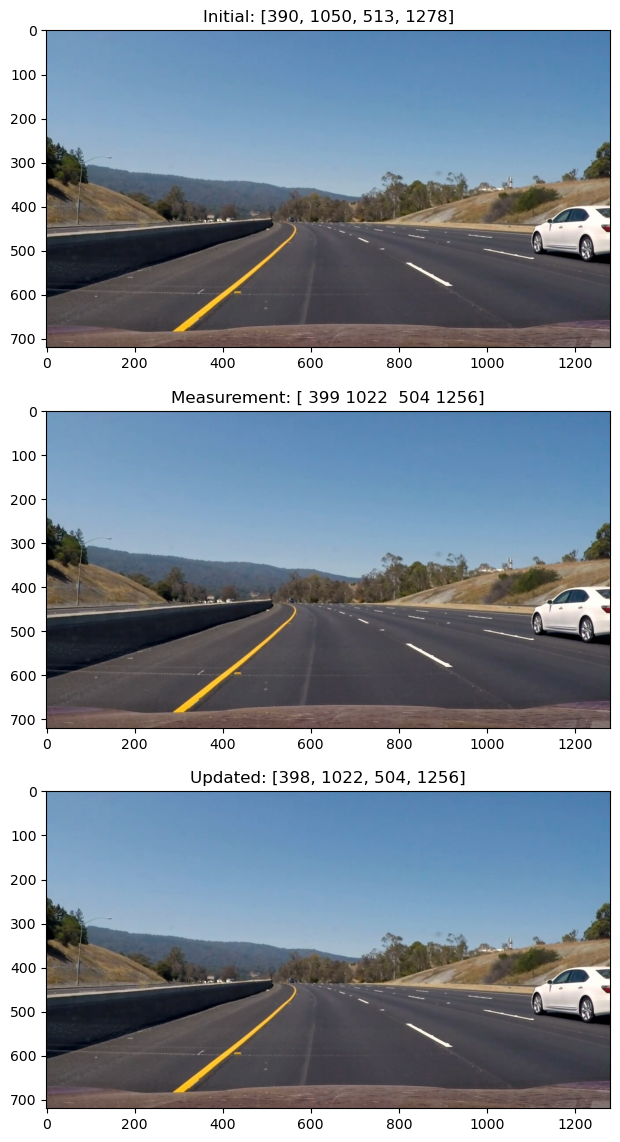

In [9]:
from numpy import dot
from scipy.linalg import inv, block_diag
import glob


class Tracker():                                                                  # class for Kalman Filter-based tracker
    def __init__(self):
        # Initializing the parametes for tracker (history)
        self.id = 0                                                               # tracker's id 
        self.box = []                                                             # list to store the coordinates for a bounding box 
        self.hits = 0                                                             # number of detection matches
        self.no_losses = 0                                                        # number of unmatched tracks (track loss)
        
        # Initializing the parameters:
        self.x_state=[] 
        self.dt = 1.   # time interval
        
        # Process matrix:
        self.F = np.array([[1, self.dt, 0,  0,  0,  0,  0, 0],
                           [0, 1,  0,  0,  0,  0,  0, 0],
                           [0, 0,  1,  self.dt, 0,  0,  0, 0],
                           [0, 0,  0,  1,  0,  0,  0, 0],
                           [0, 0,  0,  0,  1,  self.dt, 0, 0],
                           [0, 0,  0,  0,  0,  1,  0, 0],
                           [0, 0,  0,  0,  0,  0,  1, self.dt],
                           [0, 0,  0,  0,  0,  0,  0,  1]])
        
        
        # Measurement matrix:
        
        self.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 1, 0, 0, 0], 
                           [0, 0, 0, 0, 0, 0, 1, 0]])
        
        
        # Initialing the state covariance:
        self.L = 10.0
        self.P = np.diag(self.L*np.ones(8))
        
        
        # Initializing the process covariance
        self.Q_comp_mat = np.array([[self.dt**4/4., self.dt**3/2.],
                                    [self.dt**3/2., self.dt**2]])
        self.Q = block_diag(self.Q_comp_mat, self.Q_comp_mat, 
                            self.Q_comp_mat, self.Q_comp_mat)
        
        # Initializing the measurement covariance
        self.R_scaler = 1.0
        self.R_diag_array = self.R_scaler * np.array([self.L, self.L, self.L, self.L])
        self.R = np.diag(self.R_diag_array)


        # Here self.R_scaler represents the "magnitude" of measurement noise relative to state noise. 
        # A low self.R_scaler indicates a more reliable measurement. 
        
        
    def update_R(self):   
        R_diag_array = self.R_scaler * np.array([self.L, self.L, self.L, self.L])
        self.R = np.diag(R_diag_array)
         
        
    def kalman_filter(self, z): 
        
        # Implementing the Kalman Filter, including the predict and the update stages, with the measurement z
        
        x = self.x_state
        
        # Predict
        x = dot(self.F, x)
        self.P = dot(self.F, self.P).dot(self.F.T) + self.Q

        #Update
        S = dot(self.H, self.P).dot(self.H.T) + self.R
        K = dot(self.P, self.H.T).dot(inv(S)) # Kalman gain
        y = z - dot(self.H, x) # residual
        x += dot(K, y)
        self.P = self.P - dot(K, self.H).dot(self.P)
        self.x_state = x.astype(int) # converting to integer coordinates 
                                     #(pixel values)
        
    def predict_only(self):  

        # Implment only the predict stage. 
        # This is used for unmatched detections and unmatched tracks.

        x = self.x_state
        # Predict
        x = dot(self.F, x)
        self.P = dot(self.F, self.P).dot(self.F.T) + self.Q
        self.x_state = x.astype(int)
        
if __name__ == "__main__":

    
    # Creat an instance
    trk = Tracker() 
    # Test R_ratio   
    trk.R_scaler = 1.0/16
    # Update measurement noise covariance matrix
    trk.update_R()
    # Initial state
    x_init = np.array([390, 0, 1050, 0, 513, 0, 1278, 0])
    x_init_box = [x_init[0], x_init[2], x_init[4], x_init[6]]
    # Measurement
    z=np.array([399, 1022, 504, 1256])
    trk.x_state= x_init.T
    trk.kalman_filter(z.T)
    # Updated state
    x_update =trk.x_state
    x_updated_box = [x_update[0], x_update[2], x_update[4], x_update[6]]
    
    print('The initial state is: ', x_init)
    print('The measurement is: ', z)
    print('The update state is: ', x_update)
    
    # Visualize the Kalman filter process and the 
    # impact of measurement nosie convariance matrix

    images = [plt.imread(file) for file in glob.glob('test_images\\*.jpg')]
    
    img = images[1]
    plt.figure(figsize=(10, 14))


    # changed here
    #helpers.draw_box_label(img, x_init_box, box_color=(0, 255, 0))
    # draw_box_label(img, x_init_box, box_color=(0, 255, 0))
    draw_box_label(img.copy(), x_init_box, box_color=(0, 255, 0))
    ax = plt.subplot(3, 1, 1)
    plt.imshow(img)
    plt.title('Initial: '+str(x_init_box))

    
    # changed here
    #helpers.draw_box_label(img, z, box_color=(255, 0, 0))
    draw_box_label(img.copy(), z, box_color=(255, 0, 0))
    ax = plt.subplot(3, 1, 2)
    plt.imshow(img)
    plt.title('Measurement: '+str(z))
    
    #helpers.draw_box_label(img, x_updated_box)
    draw_box_label(img.copy(), x_updated_box)
    ax = plt.subplot(3, 1, 3)
    plt.imshow(img)
    plt.title('Updated: '+str(x_updated_box))
    plt.show()    

# **OBSERVATION:**

From the above output images, we can visualize the measurement noises in the Kalman filter process. 

The green bounding box gives the initial state of the car. 
The red bounding box gives the measurement values.
The aqua colored bounding box give sthe updated state. 

Here, the initial state value is 390
The measurement state value is 399 afetr 1 second
Updated state value is 398

If measurement noise is low, the updated state is very close to the measurement. So, the aqua bounding box completely overlaps the red bounding box.

Suppose, if measurement noise is high, the updated state is very close to the initial prediction. So, the aqua bounding box completely overlaps over the green bounding box.

From the output images, there is no complete overlapping of green and aqua bounding box. Which infers that the measurement noise is relatively lower.



# ***MAIN functions***

These functions, implementt the detection and tracking, including detection-track assignment and track management:

**HUNGARIAN ALGORITHM:**

The Hungarian method is a combinatorial optimization algorithm that solves the assignment problem in polynomial time and which anticipated later primal–dual methods.
(https://en.wikipedia.org/wiki/Hungarian_algorithm)


EXAMPLE:

Consider a company has 4 employees and there are four jobs to be done. Here, each employee is capable of doing any of the four jobs. But, the time taken to complete the work is different for different employees. Then Hungarian Algorithm concept is applied and the jobs are assigned to the emplyees in effecient manner so as to control the time and cost of the assignment.

Here, the analysis is carried out by taking all the values of time taken by the employees for different jobs into a tablular format or in form of matrix (cost matrix) and operations are performed till we optimise the assignment.

In the cost matrix, if a constant is added to every element of a row or a column, the optimum solution of the resulting assignment problem is the same as the original problem.

In this analysis, we implement Linear Assignment and Hungarian (Munkres) algorithm:


If multiple detections are identified, we need to assign each of them to a tracker. Here, we are using intersection over union (IOU) of a 'tracker bounding box' and 'detection bounding box' as a metric. 
Here, we analyse till maximizing/optimizing the sum of IOU assignment.



**Unmatched detections and trackers:**


Depending on the results of linear assignment, we make lists for unmatched detections and unmatched trackers. 



When a car enters into a frame and is first detected, it is not matched with any existing tracks. Hence this particular detection is categorized under unmatched detection. If any matching with an overlap less than iou_thrd, it denotes the existence of an untracked object. When the car leaves the frame, 
the previous used track has no more detections to consider. So, the track is considered as an unmatched track.

In this way, the tracker and the detection associated in the matching are added to the lists of unmatched trackers and unmatched detection.

We include two important design parameters, min_hits and max_age, in the pipeline. The parameter min_hits is the number of consecutive matches needed to establish a track. The parameter max_age is number of consecutive unmatched detections before a track is deleted. Both parameters need to be tuned to improve the tracking and detection performance.

In [10]:

from moviepy.editor import VideoFileClip
from collections import deque
from scipy.optimize import linear_sum_assignment as linear_assignment


frame_count = 0               # frame counter

max_age = 4                   # number of consecutive unmatched detection before the track is deleted

min_hits =1                   # number of consecutive matches needed to establish a track

tracker_list =[]              # list for trackers

track_id_list= deque(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K'])              # list for track ID

debug = True

def assign_detections_to_trackers(trackers, detections, iou_thrd = 0.3):
    IOU_mat= np.zeros((len(trackers),len(detections)),dtype=np.float32)
    for t,trk in enumerate(trackers):
        #trk = convert_to_cv2bbox(trk) 
        for d,det in enumerate(detections):
         #   det = convert_to_cv2bbox(det)
            IOU_mat[t,d] = box_iou2(trk,det) 
           
    # Here, we are using the Hungarian algorithm to solve the maximizing the sum of IOU assignment problem.
    
    matched_idx = linear_assignment(-IOU_mat)
    matched_idx = np.asarray(matched_idx)
    matched_idx = np.transpose(matched_idx)        

    unmatched_trackers, unmatched_detections = [], []
    for t,trk in enumerate(trackers):
        if(t not in matched_idx[:,0]):
            unmatched_trackers.append(t)

    for d, det in enumerate(detections):
        if(d not in matched_idx[:,1]):
            unmatched_detections.append(d)

    matches = []
   
    # To create trackers we consider any detection with an overlap less than iou_thrd to signifiy the existence of an untracked object
    
    for m in matched_idx:
        if(IOU_mat[m[0],m[1]]<iou_thrd):
            unmatched_trackers.append(m[0])
            unmatched_detections.append(m[1])
        else:
            matches.append(m.reshape(1,2))
    
    if(len(matches)==0):
        matches = np.empty((0,2),dtype=int)
    else:
        matches = np.concatenate(matches,axis=0)
    
    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)       
    


def pipeline(img):
    global frame_count
    global tracker_list
    global max_age
    global min_hits
    global track_id_list
    global debug
    
    frame_count+=1
    
    img_dim = (img.shape[1], img.shape[0])
    z_box = det.get_localization(img) # measurement
    # if debug:
    #    print('Frame:', frame_count)
       
    x_box =[]
    # if debug: 
    #     for i in range(len(z_box)):
    #        img1= draw_box_label(img.copy(), z_box[i], box_color=(255, 0, 0))
    #        plt.imshow(img1)
    #     plt.show()
    
    if len(tracker_list) > 0:
        for trk in tracker_list:
            x_box.append(trk.box)
    
    
    matched, unmatched_dets, unmatched_trks \
    = assign_detections_to_trackers(x_box, z_box, iou_thrd = 0.3)  
    # if debug:
    #      print('Detection: ', z_box)
    #      print('x_box: ', x_box)
    #      print('matched:', matched)
    #      print('unmatched_det:', unmatched_dets)
    #      print('unmatched_trks:', unmatched_trks)
    
         
    # Working on matched detections  
    # When the car is detected again in the second video frame, running the following assign_detections_to_trackers returns an one-element list , an empty list, 
    # for matched, unmatched_dets, and unmatched_trks, respectively.

    if matched.size >0:
        for trk_idx, det_idx in matched:
            z = z_box[det_idx]
            z = np.expand_dims(z, axis=0).T
            tmp_trk= tracker_list[trk_idx]
            tmp_trk.kalman_filter(z)
            xx = tmp_trk.x_state.T[0].tolist()
            xx =[xx[0], xx[2], xx[4], xx[6]]
            x_box[trk_idx] = xx
            tmp_trk.box =xx
            tmp_trk.hits += 1
            tmp_trk.no_losses = 0

    # The above code block carries out two important tasks, 
    # 1) carrying out the Kalman filter's prediction and update stages using the function tmp_trk.kalman_filter(); 
    # 2) increasing the hits of the track by one tmp_trk.hits +=1. 
    
    # In our analysis, trk.hits >= min_hits and trk.no_losses <=max_age.  So the track is fully established. As the result, the bounding box is annotated in the output image



    
    # Working on  unmatched detections 
    # if len(unmatched_dets)>0:
    #     for idx in unmatched_dets:
    #         z = z_box[idx]
    #         z = np.expand_dims(z, axis=0).T
    #         tmp_trk = Tracker() # Creating a new tracker
    #         x = np.array([[z[0], 0, z[1], 0, z[2], 0, z[3], 0]]).T
    #         tmp_trk.x_state = x
    #         # x = np.array([[z[0], 0, z[1], 0, z[2], 0, z[3], 0]]).T
    #         # tmp_trk.x_state = np.reshape(tmp_trk.x_state, x.shape)
    #         # tmp_trk.x_state = x
    #         tmp_trk.predict_only()
    #         xx = tmp_trk.x_state
    #         xx = xx.T[0].tolist()
    #         xx =[xx[0], xx[2], xx[4], xx[6]]
    #         tmp_trk.box = xx
    #         tmp_trk.id = track_id_list.popleft() 
    #         tracker_list.append(tmp_trk)
    #         x_box.append(xx)
    if len(unmatched_dets) > 0:
        for idx in unmatched_dets:
            z = z_box[idx]
            z = np.array([z[0], 0, z[1], 0, z[2], 0, z[3], 0]).reshape((8, 1))
            tmp_trk = Tracker()  # Creating a new tracker
            tmp_trk.x_state = z
            tmp_trk.predict_only()
            xx = tmp_trk.x_state
            xx = xx.T[0].tolist()
            xx = [xx[0], xx[2], xx[4], xx[6]]
            tmp_trk.box = xx
            tmp_trk.id = track_id_list.popleft()
            tracker_list.append(tmp_trk)
            x_box.append(xx)

    
    # Working with unmatched tracks       
    if len(unmatched_trks)>0:
        for trk_idx in unmatched_trks:
            tmp_trk = tracker_list[trk_idx]
            tmp_trk.no_losses += 1
            tmp_trk.predict_only()
            xx = tmp_trk.x_state
            xx = xx.T[0].tolist()
            xx =[xx[0], xx[2], xx[4], xx[6]]
            tmp_trk.box =xx
            x_box[trk_idx] = xx
                   
       
    # The list of tracks that are to be annotated: 
    good_tracker_list =[]
    for trk in tracker_list:
        if ((trk.hits >= min_hits) and (trk.no_losses <=max_age)):
             good_tracker_list.append(trk)
             x_cv2 = trk.box
            #  if debug:
            #      print('updated box: ', x_cv2)
            #      print()
             img= draw_box_label(img.copy(), x_cv2)  # Drawing the bounding boxes

    deleted_tracks = filter(lambda x: x.no_losses >max_age, tracker_list)  
    
    for trk in deleted_tracks:
            track_id_list.append(trk.id)
    
    tracker_list = [x for x in tracker_list if x.no_losses<=max_age]
    
    # if debug:
    #    print('Ending tracker_list: ',len(tracker_list))
    #    print('Ending good tracker_list: ',len(good_tracker_list))
    
       
    return img
    
if __name__ == "__main__":
  det = CarDetector()
  start=time.time()
  output = 'test_v7.mp4'
  clip1 = VideoFileClip("project_video.mp4")     
  clip = clip1.fl_image(pipeline)
  clip.write_videofile(output, audio=False)
  end  = time.time()
    
#     print(round(end-start, 2), 'Seconds to finish')
#   if debug: # testing on images
#         images = [plt.imread(file) for file in glob.glob('E:\\maths project\\VehicleVision\\test_images\\*.jpg')]
        
#         for i in range(len(images))[0:7]:
#              image = images[i]
#              image_box = pipeline(image)   
#              plt.imshow(image_box)
#              plt.show()
#   else:                         # test on a video file.
#     start=time.time()
#     output = 'test_v7.mp4'
#     clip1 = VideoFileClip("project_video.mp4")     
#     clip = clip1.fl_image(pipeline)
#     clip.write_videofile(output, audio=False)
#     end  = time.time()
    
#     print(round(end-start, 2), 'Seconds to finish')

t:  17%|█▋        | 208/1260 [02:06<04:12,  4.17it/s, now=None]

no detection!
Moviepy - Building video test_v7.mp4.
Moviepy - Writing video test_v7.mp4



no detection!
no detection!


t:   0%|          | 3/1260 [00:00<01:15, 16.71it/s, now=None]

no detection!


no detection!
no detection!


no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!
no detection!


no detection!
no detection!
no detection!
no detection!


no detection!
no detection!
no detection!
no detection!


no detection!
no detection!
no detection!
no detection!


no detection!
no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!
no detection!


t:   3%|▎         | 37/1260 [00:02<01:18, 15.64it/s, now=None]


no detection!
no detection!
no detection!
no detection!


t:   3%|▎         | 41/1260 [00:02<01:18, 15.60it/s, now=None]


no detection!
no detection!
no detection!
no detection!


t:   4%|▎         | 45/1260 [00:02<01:17, 15.77it/s, now=None]


no detection!
no detection!
no detection!
no detection!


t:   4%|▍         | 49/1260 [00:03<01:18, 15.42it/s, now=None]

no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!
no detection!


t:   8%|▊         | 105/1260 [00:07<01:19, 14.46it/s, now=None]

no detection!
wrong ratio or wrong size,  [426 230 441 257] , confidence:  0.3593139 ratio: 0.5553498704183636
no detection!


no detection!
[423 181 444 218] , confidence:  0.3220045 ratio: 0.5674142123750338
[424 170 446 208] , confidence:  0.36299512 ratio: 0.5787950539331755


no detection!
no detection!
[425 138 447 178] , confidence:  0.4599665 ratio: 0.5498625343664084


[421  97 454 154] , confidence:  0.47030228 ratio: 0.5788458165234169
[421  77 453 140] , confidence:  0.6479522 ratio: 0.5078558958895414
[420  62 451 119] , confidence:  0.5478165 ratio: 0.5437642518856342


[419  44 454 110] , confidence:  0.8098922 ratio: 0.5302226935312832
[425 166 450 207] , confidence:  0.48928967 ratio: 0.60960741282614
[414   6 454  77] , confidence:  0.49836966 ratio: 0.5633009435290803
[426 156 450 199] , confidence:  0.30405965 ratio: 0.5580097651708905
[414   1 450  54] , confidence:  0.37355953 ratio: 0.6791171477079797


no detection!
no detection!
[421  89 451 152] , confidence:  0.42298466 ratio: 0.47611490239644505


[421  78 452 148] , confidence:  0.47622022 ratio: 0.4427938865876303
[422  66 453 128] , confidence:  0.65439063 ratio: 0.4999193678438962
[421  48 455 110] , confidence:  0.5066918 ratio: 0.5482986615062087


[422  42 453 104] , confidence:  0.40916303 ratio: 0.4999193678438962
[424 233 448 275] , confidence:  0.40847215 ratio: 0.5712925493930017
[420  17 457  86] , confidence:  0.37483877 ratio: 0.5361541805535429
[420   4 457  69] , confidence:  0.4407938 ratio: 0.5691432087371173
[424 225 450 263] , confidence:  0.37928388 ratio: 0.684030518284662
[421 204 451 255] , confidence:  0.5713099 ratio: 0.588119976475201
wrong ratio or wrong size,  [420   3 454  40] , confidence:  0.30780974 ratio: 0.9186706295595786


[422 199 455 245] , confidence:  0.38895458 ratio: 0.7172353836122582
wrong ratio or wrong size,  [ 432 1209  527 1275] , confidence:  0.30954185 ratio: 1.4391758824420542
wrong ratio or wrong size,  [ 434 1202  523 1273] , confidence:  0.3448936 ratio: 1.2533445993522039


[422 295 447 330] , confidence:  0.3309011 ratio: 0.7140816909454442
[424 289 448 323] , confidence:  0.3356811 ratio: 0.7056748015289621
wrong ratio or wrong size,  [ 430 1194  528 1274] , confidence:  0.40858802 ratio: 1.2248468941382327
[422 273 449 321] , confidence:  0.31112877 ratio: 0.5623828369089773


[416  69 459 152] , confidence:  0.7910285 ratio: 0.5180098783279122
wrong ratio or wrong size,  [ 426 1193  527 1274] , confidence:  0.46527332 ratio: 1.2467596593013208
[411  49 461 139] , confidence:  0.7550983 ratio: 0.5554938340184423
[428 223 457 288] , confidence:  0.44948524 ratio: 0.4460852176588217
wrong ratio or wrong size,  [ 424 1188  525 1276] , confidence:  0.43810835 ratio: 1.147596863992728
[409  17 460 118] , confidence:  0.80713105 ratio: 0.5049005049005049
[424 205 456 276] , confidence:  0.656038 ratio: 0.4506407548232643
wrong ratio or wrong size,  [ 426 1184  525 1275] , confidence:  0.44070444 ratio: 1.0877925502692012


[411   5 461  84] , confidence:  0.7410761 ratio: 0.6328312871788381
[426 185 456 253] , confidence:  0.6923252 ratio: 0.44111160123511245
wrong ratio or wrong size,  [ 425 1180  524 1274] , confidence:  0.38894826 ratio: 1.053079459631954
wrong ratio or wrong size,  [ 419 1180  526 1279] , confidence:  0.46127048 ratio: 1.0806989193010808
[426 148 457 225] , confidence:  0.4514855 ratio: 0.4025451240098688
[425 134 458 212] , confidence:  0.55130565 ratio: 0.423022689398795
wrong ratio or wrong size,  [ 419 1182  524 1279] , confidence:  0.5257354 ratio: 1.082362643026492


[423 108 457 184] , confidence:  0.58933866 ratio: 0.44730956453098275
wrong ratio or wrong size,  [ 418 1182  526 1278] , confidence:  0.44423714 ratio: 1.1248828247057598
[428  82 460 154] , confidence:  0.39716193 ratio: 0.4443827246215803
wrong ratio or wrong size,  [ 419 1185  525 1280] , confidence:  0.4318106 ratio: 1.1156720345226818
[422  53 461 148] , confidence:  0.32121885 ratio: 0.41048310704136404
wrong ratio or wrong size,  [ 416 1184  526 1280] , confidence:  0.39017043 ratio: 1.1457139881262368
[426   3 466 104] , confidence:  0.34186897 ratio: 0.396000396000396
wrong ratio or wrong size,  [ 417 1178  524 1279] , confidence:  0.3548153 ratio: 1.0593010593010592


t:  12%|█▏        | 145/1260 [00:10<01:18, 14.15it/s, now=None]

wrong ratio or wrong size,  [ 419 1179  526 1280] , confidence:  0.40646946 ratio: 1.0593010593010592
wrong ratio or wrong size,  [ 418 1177  528 1280] , confidence:  0.4647118 ratio: 1.06785748956412
wrong ratio or wrong size,  [ 414 1179  525 1280] , confidence:  0.31637666 ratio: 1.0989010989010988


wrong ratio or wrong size,  [ 414 1175  526 1280] , confidence:  0.3050791 ratio: 1.0665650890391392
no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!


no detection!
no detection!
no detection!
no detection!


no detection!
no detection!
wrong ratio or wrong size,  [ 402 1130  525 1276] , confidence:  0.34853816 ratio: 0.8424080542428601


wrong ratio or wrong size,  [ 403 1127  528 1277] , confidence:  0.4143573 ratio: 0.8332777814812347
wrong ratio or wrong size,  [ 404 1127  527 1277] , confidence:  0.34929115 ratio: 0.8199453369775349
[ 406 1120  527 1276] , confidence:  0.40984005 ratio: 0.7755913082494712


[ 404 1117  527 1274] , confidence:  0.50817466 ratio: 0.7833895930195529
wrong ratio or wrong size,  [ 398 1118  527 1274] , confidence:  0.6232729 ratio: 0.8268700724312544
wrong ratio or wrong size,  [ 394 1122  524 1280] , confidence:  0.6705896 ratio: 0.8227327384342764


wrong ratio or wrong size,  [ 394 1119  524 1280] , confidence:  0.7208222 ratio: 0.8074032668778337
[ 394 1108  523 1279] , confidence:  0.786469 ratio: 0.754341851353722
[ 396 1110  526 1279] , confidence:  0.7905781 ratio: 0.7691852553103367


[ 401 1104  527 1278] , confidence:  0.7905287 ratio: 0.7240963163036608
[ 401 1098  528 1277] , confidence:  0.8142564 ratio: 0.7094575722026703
[ 402 1100  529 1279] , confidence:  0.8470143 ratio: 0.7094575722026703
[ 394 1094  527 1277] , confidence:  0.8605238 ratio: 0.7267362439210973


[ 393 1097  526 1279] , confidence:  0.8524277 ratio: 0.7307290808197352
[ 390 1092  518 1278] , confidence:  0.8344592 ratio: 0.6881350465028763
[ 391 1097  520 1277] , confidence:  0.8285747 ratio: 0.7166268540636632


[ 390 1092  516 1277] , confidence:  0.8399579 ratio: 0.681044267877412
[ 391 1090  515 1275] , confidence:  0.82295126 ratio: 0.6702340414031674
[ 391 1087  519 1276] , confidence:  0.84191597 ratio: 0.6772128458811704


[ 392 1084  519 1276] , confidence:  0.87057316 ratio: 0.6614238841726994
[ 393 1086  519 1275] , confidence:  0.86013824 ratio: 0.666631395164277
[ 395 1086  525 1276] , confidence:  0.8368334 ratio: 0.6841745171306773
[ 397 1089  523 1277] , confidence:  0.8457225 ratio: 0.6701771182383917


[ 394 1084  524 1276] , confidence:  0.85432696 ratio: 0.6770480704129993
[ 396 1082  522 1277] , confidence:  0.8464828 ratio: 0.6461207117583714
[ 392 1082  519 1276] , confidence:  0.8487191 ratio: 0.6546054327096542


[ 394 1078  520 1276] , confidence:  0.845339 ratio: 0.6363314984091712
[ 392 1080  519 1275] , confidence:  0.84264743 ratio: 0.6512486539151838
[ 390 1077  517 1276] , confidence:  0.8249809 ratio: 0.6381588864881163


[ 393 1076  517 1275] , confidence:  0.84411234 ratio: 0.6230842671222552
[ 394 1078  516 1276] , confidence:  0.8455312 ratio: 0.6161304984596738
[ 391 1076  513 1278] , confidence:  0.8792649 ratio: 0.6039304984901738


[ 389 1076  511 1278] , confidence:  0.8808715 ratio: 0.6039304984901738
[ 388 1077  509 1276] , confidence:  0.8845781 ratio: 0.6080096477563942
[ 385 1077  506 1276] , confidence:  0.8918398 ratio: 0.6080096477563942


[ 386 1073  505 1277] , confidence:  0.88832045 ratio: 0.5833047399637273
[ 387 1072  506 1279] , confidence:  0.865239 ratio: 0.5748514564513791
[ 388 1074  508 1278] , confidence:  0.87177694 ratio: 0.5882064604676241


[ 389 1070  510 1280] , confidence:  0.8420452 ratio: 0.576163039855245
[ 388 1071  509 1279] , confidence:  0.846106 ratio: 0.5817028027498679
[ 393 1069  511 1279] , confidence:  0.79585564 ratio: 0.5618780058092472
[ 396 1070  513 1279] , confidence:  0.79996574 ratio: 0.5597818286206402


t:  16%|█▋        | 207/1260 [00:14<01:12, 14.49it/s, now=None]

[ 399 1067  516 1277] , confidence:  0.777436 ratio: 0.5571163277939146
[ 401 1069  517 1278] , confidence:  0.7973356 ratio: 0.5549973685469595
[ 395 1070  512 1278] , confidence:  0.84388906 ratio: 0.562472958030864


[ 394 1071  513 1278] , confidence:  0.85931796 ratio: 0.5748514564513791
[ 389 1067  510 1279] , confidence:  0.8524136 ratio: 0.5707277958586859
[ 390 1066  510 1278] , confidence:  0.8421033 ratio: 0.5660110372152257


[ 391 1067  509 1277] , confidence:  0.844401 ratio: 0.5618780058092472
[ 389 1065  506 1278] , confidence:  0.8310531 ratio: 0.5492699873245388
[ 391 1056  509 1280] , confidence:  0.75491625 ratio: 0.5267621981161555
[ 404 1062  518 1274] , confidence:  0.7523772 ratio: 0.5377104853544644


t:  17%|█▋        | 217/1260 [00:15<01:11, 14.63it/s, now=None]

[ 392 1053  509 1279] , confidence:  0.73681676 ratio: 0.5176762090173002
[ 388 1053  509 1279] , confidence:  0.74171555 ratio: 0.5353745409495155
[ 406 1056  520 1273] , confidence:  0.708766 ratio: 0.5253214137597346


[ 402 1051  520 1275] , confidence:  0.74018437 ratio: 0.5267621981161555
[ 400 1051  520 1275] , confidence:  0.81256396 ratio: 0.5356903709655819
[ 388 1051  511 1279] , confidence:  0.79483706 ratio: 0.539450024121749


[ 402 1054  519 1275] , confidence:  0.7634268 ratio: 0.529387810506312
[ 387 1049  515 1279] , confidence:  0.76945096 ratio: 0.5564975435850615
[ 398 1056  519 1273] , confidence:  0.78573066 ratio: 0.557577991797613


[ 391 1047  513 1280] , confidence:  0.7427693 ratio: 0.5235826788549848
[ 391 1050  513 1279] , confidence:  0.77688956 ratio: 0.5327278284791057
[ 389 1046  513 1280] , confidence:  0.7552843 ratio: 0.5298918849621811
[427 120 453 221] , confidence:  0.3033194 ratio: 0.2574002574002574


[ 398 1052  518 1273] , confidence:  0.65373063 ratio: 0.5429618569295507
[ 392 1049  513 1280] , confidence:  0.6436879 ratio: 0.5237868490541535
[ 392 1048  514 1280] , confidence:  0.70706403 ratio: 0.5258394034739882


[ 390 1045  514 1280] , confidence:  0.6628571 ratio: 0.5276371218246032
[ 390 1044  514 1280] , confidence:  0.6628211 ratio: 0.5254014660395746
[ 392 1042  516 1280] , confidence:  0.53524256 ratio: 0.5209865131717155


[ 390 1030  510 1270] , confidence:  0.5469783 ratio: 0.4999791675346861
[ 393 1040  517 1280] , confidence:  0.5361191 ratio: 0.5166451397858423
[ 399 1029  513 1276] , confidence:  0.6211757 ratio: 0.4615197765272661
[ 389 1021  512 1271] , confidence:  0.66396844 ratio: 0.4919803207871685


t:  19%|█▉        | 239/1260 [00:16<01:12, 14.06it/s, now=None]

[ 389 1025  511 1272] , confidence:  0.6161895 ratio: 0.49390712926602165
[ 393 1037  509 1279] , confidence:  0.64436376 ratio: 0.4793190364034544
[ 392 1036  505 1278] , confidence:  0.69917035 ratio: 0.46692285442750303


[ 394 1039  504 1278] , confidence:  0.75593024 ratio: 0.460231789464876
[ 395 1038  507 1280] , confidence:  0.75682235 ratio: 0.46279079376885257
[ 395 1033  508 1280] , confidence:  0.7285393 ratio: 0.4574713574349217


[ 394 1031  507 1278] , confidence:  0.78690714 ratio: 0.4574713574349217
[ 397 1023  508 1279] , confidence:  0.7617235 ratio: 0.43357681340572635
[424  56 458 165] , confidence:  0.67475617 ratio: 0.31189799100999904
[424 119 454 198] , confidence:  0.5701789 ratio: 0.37969877230730287
[ 397 1025  508 1275] , confidence:  0.72704303 ratio: 0.4439822407103716
[422  41 457 138] , confidence:  0.5812218 ratio: 0.36078754767549737
[427   8 461  90] , confidence:  0.36931196 ratio: 0.4145835873673942


[ 399 1015  512 1278] , confidence:  0.7489687 ratio: 0.42964145849967683
[ 395 1020  506 1273] , confidence:  0.8044364 ratio: 0.4387178372396348
[ 397 1021  504 1272] , confidence:  0.8117636 ratio: 0.4262778375363531


[ 396 1021  504 1273] , confidence:  0.82958096 ratio: 0.42855442244355385
[ 396 1022  504 1264] , confidence:  0.82363236 ratio: 0.4462625511342507
[ 397 1020  507 1267] , confidence:  0.78580445 ratio: 0.44532610015788837


[ 396 1022  506 1266] , confidence:  0.8121362 ratio: 0.45080119667226753
[ 398 1023  505 1268] , confidence:  0.7610761 ratio: 0.43671686869923676
[ 398 1016  504 1269] , confidence:  0.8100178 ratio: 0.4189557724991107


[ 399 1016  503 1265] , confidence:  0.8062214 ratio: 0.41765390948154696
[ 397 1008  510 1272] , confidence:  0.76417816 ratio: 0.4280140903753646
[ 398 1017  503 1261] , confidence:  0.7693514 ratio: 0.4303102331871645


[ 398 1015  503 1264] , confidence:  0.7971007 ratio: 0.42166981245733104
[ 398 1014  501 1266] , confidence:  0.8413346 ratio: 0.40871393992301897
[ 397 1025  501 1264] , confidence:  0.8250936 ratio: 0.43512823731224637


[ 398 1025  501 1265] , confidence:  0.81473005 ratio: 0.4291487854672722
[ 400 1025  502 1267] , confidence:  0.751791 ratio: 0.42147018718234786
[ 399 1025  502 1263] , confidence:  0.77614456 ratio: 0.4327549262636024


[ 399 1022  501 1261] , confidence:  0.83015513 ratio: 0.42676038659470317
[ 399 1022  501 1258] , confidence:  0.7962571 ratio: 0.43218507690352104
[ 398 1022  501 1261] , confidence:  0.83993524 ratio: 0.43094431195347477


[ 399 1023  502 1260] , confidence:  0.7662687 ratio: 0.43458081937470994
[ 398 1021  503 1260] , confidence:  0.75201344 ratio: 0.43931216267101797
[ 400 1014  503 1253] , confidence:  0.65326047 ratio: 0.43094431195347477


[ 399 1019  503 1257] , confidence:  0.566112 ratio: 0.436956430402084
[430 143 454 195] , confidence:  0.33450925 ratio: 0.46144972120746014
[ 399 1003  509 1256] , confidence:  0.6594065 ratio: 0.43476542429153
[432  90 457 150] , confidence:  0.35700768 ratio: 0.41659723379436764
[ 399 1002  510 1253] , confidence:  0.6725361 ratio: 0.4422134576311701
[430  54 456 114] , confidence:  0.38475522 ratio: 0.43326112314614235


[ 399 1001  510 1251] , confidence:  0.7105445 ratio: 0.4439822407103716
[ 398 1022  504 1254] , confidence:  0.5597801 ratio: 0.45687685875608813
[ 399 1021  504 1256] , confidence:  0.5110686 ratio: 0.4467894983192205


[ 399 1014  504 1253] , confidence:  0.5590808 ratio: 0.43931216267101797
[ 399  998  510 1242] , confidence:  0.43682575 ratio: 0.45489938936928814
[ 400 1014  508 1244] , confidence:  0.5509727 ratio: 0.46954480239989566
[ 402  997  510 1239] , confidence:  0.68385905 ratio: 0.4462625511342507


[ 403  996  511 1238] , confidence:  0.72196835 ratio: 0.4462625511342507
[ 401 1011  508 1248] , confidence:  0.65670365 ratio: 0.4514577443989705
[ 403 1012  507 1246] , confidence:  0.5558898 ratio: 0.4444254519037648
[ 401 1011  507 1245] , confidence:  0.54600847 ratio: 0.45297209520960646


[ 401 1011  507 1246] , confidence:  0.49626815 ratio: 0.45104463639845116
[ 402 1013  508 1245] , confidence:  0.34361565 ratio: 0.45687685875608813
no detection!


[424  94 457 161] , confidence:  0.385298 ratio: 0.4924638113714371
[ 402 1010  509 1239] , confidence:  0.3242813 ratio: 0.4672285053054452
[421  75 459 154] , confidence:  0.4564277 ratio: 0.48095177825591695
[ 403 1013  508 1243] , confidence:  0.40402174 ratio: 0.4565018912221208
[422  55 462 128] , confidence:  0.6580763 ratio: 0.5478701547733187
[ 406 1009  509 1237] , confidence:  0.5382084 ratio: 0.4517345730450419


[ 405 1011  509 1238] , confidence:  0.6126325 ratio: 0.45812959781507423
[425  41 462 116] , confidence:  0.5609556 ratio: 0.49326756432475666
[425   6 466  76] , confidence:  0.44372216 ratio: 0.5856306241965433
[ 406 1008  508 1233] , confidence:  0.6518019 ratio: 0.45331318608061866
[425   6 465  80] , confidence:  0.34801725 ratio: 0.5404675043912984
[ 406 1004  508 1232] , confidence:  0.51073766 ratio: 0.44734880049120657


[432   4 463  56] , confidence:  0.54479825 ratio: 0.5960392232263027
[ 406 1004  507 1232] , confidence:  0.50524324 ratio: 0.4429630279373712
[ 407 1002  508 1226] , confidence:  0.48249474 ratio: 0.45087272889603147
[ 406 1000  509 1221] , confidence:  0.4880907 ratio: 0.4660422605311977


[ 406 1001  509 1222] , confidence:  0.34874755 ratio: 0.4660422605311977
[ 406  999  509 1220] , confidence:  0.3161096 ratio: 0.4660422605311977
[ 406 1008  513 1211] , confidence:  0.30985337 ratio: 0.527067632136348
[ 407 1008  514 1210] , confidence:  0.30796131 ratio: 0.5296767486758082


no detection!
[ 404 1006  513 1212] , confidence:  0.3974769 ratio: 0.5291005291005291
[428 157 455 206] , confidence:  0.41324666 ratio: 0.5509079779636809
[ 406  987  506 1214] , confidence:  0.3408881 ratio: 0.44050922866834064


[ 405 1006  513 1210] , confidence:  0.3450527 ratio: 0.5293858144208617
[428 146 455 192] , confidence:  0.31240585 ratio: 0.5868289502282112
[ 405  983  506 1213] , confidence:  0.3752659 ratio: 0.43911134298508764
[427  98 457 157] , confidence:  0.5177825 ratio: 0.5083884087442806
[427 123 454 173] , confidence:  0.3187732 ratio: 0.5398920215956808


[ 405  979  505 1212] , confidence:  0.45737734 ratio: 0.4291661302090039
[416  84 461 147] , confidence:  0.3482169 ratio: 0.7141723535946676
[ 406  980  506 1211] , confidence:  0.39015377 ratio: 0.4328816934331847
no detection!


[425  16 461  86] , confidence:  0.41255426 ratio: 0.5142122553920868
[416   9 464  79] , confidence:  0.47305006 ratio: 0.6856163405227824
no detection!


no detection!
[ 406 1004  514 1208] , confidence:  0.30764738 ratio: 0.5293858144208617
no detection!


no detection!
no detection!
no detection!
no detection!


t:  25%|██▌       | 321/1260 [00:22<01:05, 14.29it/s, now=None]

[427 297 449 334] , confidence:  0.32379135 ratio: 0.5944339367738449
[ 403  994  514 1204] , confidence:  0.32324538 ratio: 0.5285462597019189
no detection!
no detection!


no detection!
no detection!
no detection!


[429 237 451 283] , confidence:  0.316506 ratio: 0.47815692240817215
[428 225 452 275] , confidence:  0.42892584 ratio: 0.47990401919616077
[428 212 453 261] , confidence:  0.31658465 ratio: 0.5100999795960008


[427 190 455 248] , confidence:  0.36770904 ratio: 0.4826754007929667
no detection!
[432 140 460 197] , confidence:  0.5946466 ratio: 0.49114190492895987


[432 123 459 184] , confidence:  0.44656864 ratio: 0.44255040157351255
[ 411 1014  505 1190] , confidence:  0.33734038 ratio: 0.5340605647406398
[435  81 463 163] , confidence:  0.47297302 ratio: 0.3414217778319717
[ 412 1007  503 1192] , confidence:  0.3242017 ratio: 0.49186530457813094
no detection!
no detection!


t:  27%|██▋       | 337/1260 [00:23<01:02, 14.87it/s, now=None]


no detection!
no detection!
no detection!
no detection!


t:  27%|██▋       | 341/1260 [00:23<01:00, 15.13it/s, now=None]


no detection!
no detection!
no detection!
no detection!


t:  27%|██▋       | 345/1260 [00:24<01:00, 15.14it/s, now=None]


no detection!
no detection!
no detection!
[ 407  984  490 1153] , confidence:  0.32177618 ratio: 0.49109520146736885


t:  28%|██▊       | 349/1260 [00:24<00:59, 15.35it/s, now=None]


no detection!
[ 406  983  490 1154] , confidence:  0.34934613 ratio: 0.4911993450675399
[ 404  984  492 1158] , confidence:  0.32580522 ratio: 0.5057180621803344
[ 406  985  493 1152] , confidence:  0.30161488 ratio: 0.520926890605353


t:  28%|██▊       | 353/1260 [00:24<00:57, 15.65it/s, now=None]

[ 405  983  491 1158] , confidence:  0.4026665 ratio: 0.4914004914004914
[ 405  980  491 1150] , confidence:  0.46575537 ratio: 0.5058525969060643
[434 136 458 184] , confidence:  0.31977877 ratio: 0.49989585503020206
[ 406  979  494 1150] , confidence:  0.4832442 ratio: 0.5145897900707561


[ 405  983  492 1153] , confidence:  0.5407675 ratio: 0.5117346038468326
wrong ratio or wrong size,  [441  85 461 134] , confidence:  0.3547968 ratio: 0.40807998367680065
[ 406  980  492 1151] , confidence:  0.6106472 ratio: 0.5028945675691481
[ 406  980  490 1150] , confidence:  0.6973158 ratio: 0.494088583024528


[ 407  976  491 1150] , confidence:  0.53281283 ratio: 0.4827308775357738
[ 408  977  490 1149] , confidence:  0.54217565 ratio: 0.476716469972676
[ 406  976  491 1153] , confidence:  0.5806476 ratio: 0.4801988588215355


[ 407  981  493 1143] , confidence:  0.5362719 ratio: 0.5308314301586322
[ 407  978  494 1147] , confidence:  0.52227664 ratio: 0.5147624400923022
[ 408  979  494 1142] , confidence:  0.40543517 ratio: 0.5275749953990553


[ 408  972  491 1139] , confidence:  0.61860025 ratio: 0.4969762289683253
[ 407  972  492 1142] , confidence:  0.5333093 ratio: 0.4999705899652962
[ 408  972  491 1137] , confidence:  0.5890242 ratio: 0.5029998181928368


[ 407  971  492 1138] , confidence:  0.7001285 ratio: 0.5089515597868391
[ 409  968  492 1138] , confidence:  0.6735789 ratio: 0.4882065760837598
[ 408  970  491 1138] , confidence:  0.6555745 ratio: 0.49401821320159517
[435 217 456 262] , confidence:  0.36066866 ratio: 0.4665629860031104
[ 410  968  491 1137] , confidence:  0.6153292 ratio: 0.4792615821549021


[ 409  964  492 1137] , confidence:  0.68755215 ratio: 0.47974105543032197
[448   5 479  87] , confidence:  0.31641617 ratio: 0.37800268259968295
[ 408  963  493 1135] , confidence:  0.61384326 ratio: 0.49415731643509103
[ 408  956  492 1132] , confidence:  0.6676928 ratio: 0.47724561104482704


[ 408  953  494 1129] , confidence:  0.5389427 ratio: 0.48860860178398957
[439 150 461 199] , confidence:  0.41706082 ratio: 0.4488879820444807
[441 143 463 191] , confidence:  0.61159146 ratio: 0.45823786711101855
[ 407  955  494 1125] , confidence:  0.4616655 ratio: 0.5117346038468326
[ 408  951  492 1124] , confidence:  0.5613628 ratio: 0.48552106814634993
[441 130 463 185] , confidence:  0.5344754 ratio: 0.39992728594800947
[ 409  950  492 1122] , confidence:  0.5719253 ratio: 0.4825300854601477


t:  30%|███       | 379/1260 [00:26<00:57, 15.23it/s, now=None]


[ 408  954  493 1122] , confidence:  0.618378 ratio: 0.5059222665317541
[444  79 467 129] , confidence:  0.4784189 ratio: 0.45990801839632073
[450  67 475 129] , confidence:  0.3706775 ratio: 0.4031607805192711
[ 407  954  492 1122] , confidence:  0.80972594 ratio: 0.5059222665317541
[443  63 468 110] , confidence:  0.46270946 ratio: 0.5318017443097214
[449  55 474 114] , confidence:  0.40410426 ratio: 0.42365700728690053
[ 406  947  489 1123] , confidence:  0.8715603 ratio: 0.47156411567524575
[ 407  945  489 1121] , confidence:  0.83951014 ratio: 0.46588262030566446
[448   3 475  60] , confidence:  0.3570072 ratio: 0.4736011226100684


t:  30%|███       | 383/1260 [00:26<00:56, 15.41it/s, now=None]


[ 407  944  488 1120] , confidence:  0.8636954 ratio: 0.46020112493608323
[ 408  943  489 1115] , confidence:  0.8026813 ratio: 0.47090285448520436
[ 408  943  489 1112] , confidence:  0.8658158 ratio: 0.4792615821549021
[ 407  944  489 1114] , confidence:  0.8767391 ratio: 0.4823245691429916


t:  31%|███       | 387/1260 [00:27<00:57, 15.29it/s, now=None]


[ 406  939  488 1109] , confidence:  0.8308397 ratio: 0.4823245691429916
[ 406  939  487 1107] , confidence:  0.831625 ratio: 0.48211415987143624
[ 408  936  484 1106] , confidence:  0.8562529 ratio: 0.44703252749838246
[ 407  937  485 1102] , confidence:  0.8542962 ratio: 0.47269862432579846


t:  31%|███       | 391/1260 [00:27<00:57, 15.19it/s, now=None]

[ 407  941  486 1105] , confidence:  0.86682534 ratio: 0.4816779464666789
[ 406  941  488 1100] , confidence:  0.8550715 ratio: 0.5156908370542733
[ 406  936  485 1101] , confidence:  0.85811657 ratio: 0.4787588630992061


[ 408  942  484 1093] , confidence:  0.8556397 ratio: 0.5032779286139991
[ 407  939  485 1092] , confidence:  0.8159115 ratio: 0.5097706032285472
[ 408  941  483 1091] , confidence:  0.82439727 ratio: 0.4999666688887408


[ 408  939  486 1089] , confidence:  0.7710785 ratio: 0.5199653356442904
[ 405  937  486 1089] , confidence:  0.7416991 ratio: 0.5328596802841918
[ 405  921  485 1089] , confidence:  0.63887405 ratio: 0.4761621332063568


[ 406  923  484 1083] , confidence:  0.72383666 ratio: 0.4874695331541779
[ 404  923  484 1081] , confidence:  0.77497363 ratio: 0.5062970698057085
[ 402  924  485 1087] , confidence:  0.6860421 ratio: 0.5091712164897859
[ 405  920  486 1088] , confidence:  0.77471566 ratio: 0.48211415987143624


[ 405  922  484 1083] , confidence:  0.8240492 ratio: 0.49065275448729895
[ 405  924  484 1082] , confidence:  0.79640806 ratio: 0.4999683564331372
[ 403  922  482 1086] , confidence:  0.8476266 ratio: 0.4816779464666789


[ 404  919  482 1087] , confidence:  0.8805835 ratio: 0.4642580798761979
[ 406  921  483 1082] , confidence:  0.883739 ratio: 0.47823116576610153
[ 406  922  484 1085] , confidence:  0.83117205 ratio: 0.4784982516410036


[ 404  917  483 1085] , confidence:  0.86665183 ratio: 0.4702101065412773
[ 405  919  483 1080] , confidence:  0.8977908 ratio: 0.4844419601267002
[ 406  921  482 1078] , confidence:  0.8802871 ratio: 0.4840456021909433
[ 405  921  482 1079] , confidence:  0.8981494 ratio: 0.48731092968799444


[ 403  922  483 1079] , confidence:  0.9010038 ratio: 0.5095216865167824
[ 403  924  484 1078] , confidence:  0.9059562 ratio: 0.5259398740341537
[ 404  919  482 1079] , confidence:  0.917371 ratio: 0.4874695331541779
[ 404  921  482 1080] , confidence:  0.904691 ratio: 0.49053518646626


[ 405  920  481 1077] , confidence:  0.93003035 ratio: 0.4840456021909433
[ 405  922  481 1075] , confidence:  0.93477374 ratio: 0.4966995621201229
[ 405  919  481 1076] , confidence:  0.93788004 ratio: 0.4840456021909433


[ 405  919  482 1074] , confidence:  0.9210839 ratio: 0.49674214566802144
[ 405  912  483 1076] , confidence:  0.92955124 ratio: 0.47558075727089816
[ 406  910  481 1076] , confidence:  0.9244175 ratio: 0.45178001325221373
[ 405  914  482 1075] , confidence:  0.92287225 ratio: 0.47823116576610153


[ 406  914  483 1067] , confidence:  0.9074665 ratio: 0.503235082674335
[ 407  912  483 1068] , confidence:  0.9142095 ratio: 0.4871482597269406
[ 407  915  480 1066] , confidence:  0.92380434 ratio: 0.4834116945897623


[ 407  920  482 1067] , confidence:  0.91135615 ratio: 0.5101693762329094
[ 406  918  481 1066] , confidence:  0.9328665 ratio: 0.5067225187487332
[ 408  914  482 1063] , confidence:  0.92900443 ratio: 0.4966109657069996


[ 407  918  482 1065] , confidence:  0.925686 ratio: 0.5101693762329094
[ 407  920  482 1064] , confidence:  0.91921526 ratio: 0.5207971668634123
[ 407  916  481 1063] , confidence:  0.91392535 ratio: 0.5033671178831373


[ 407  912  480 1062] , confidence:  0.9359607 ratio: 0.486634224385041
[ 406  914  480 1061] , confidence:  0.9404734 ratio: 0.5033671178831373
[ 407  920  481 1057] , confidence:  0.93529767 ratio: 0.5401065615648493


[ 406  920  483 1054] , confidence:  0.93926966 ratio: 0.5745839862696814
[ 406  922  483 1052] , confidence:  0.92774856 ratio: 0.5922621336820245
[ 407  919  482 1056] , confidence:  0.91166717 ratio: 0.5474052988832933


[ 408  916  482 1051] , confidence:  0.9186747 ratio: 0.5481075475890675
[ 407  908  480 1045] , confidence:  0.91020495 ratio: 0.5328078242464054
[ 407  911  480 1045] , confidence:  0.91277605 ratio: 0.5447354675024252


[ 407  905  479 1043] , confidence:  0.93332154 ratio: 0.5217013259908703
[ 406  912  479 1043] , confidence:  0.92298967 ratio: 0.5572093733302802
[ 406  908  479 1043] , confidence:  0.90718144 ratio: 0.5407006888378639
[ 406  905  481 1043] , confidence:  0.88533974 ratio: 0.5434388812404899


t:  35%|███▌      | 447/1260 [00:31<00:54, 15.01it/s, now=None]


[ 406  904  481 1042] , confidence:  0.8804217 ratio: 0.5434388812404899
[ 406  905  481 1040] , confidence:  0.9105013 ratio: 0.5555144063402712
[ 405  904  482 1037] , confidence:  0.8878667 ratio: 0.5789038418164049
[ 405  907  481 1038] , confidence:  0.90260106 ratio: 0.5801083886726205


t:  36%|███▌      | 451/1260 [00:31<00:54, 14.96it/s, now=None]

[ 406  909  481 1038] , confidence:  0.8817414 ratio: 0.5813502829238044
[ 407  906  480 1036] , confidence:  0.89682734 ratio: 0.5614952695946466
[ 406  899  479 1040] , confidence:  0.90987825 ratio: 0.5176937805829375
[ 408  902  480 1040] , confidence:  0.86382854 ratio: 0.5217013259908703


[ 408  900  480 1039] , confidence:  0.8498793 ratio: 0.5179483490396375
[ 407  898  482 1040] , confidence:  0.83732504 ratio: 0.528131821702697
[ 405  898  484 1039] , confidence:  0.77552795 ratio: 0.5602439543294803
[ 406  891  483 1042] , confidence:  0.824844 ratio: 0.509900006622078


t:  36%|███▋      | 459/1260 [00:32<00:53, 15.08it/s, now=None]


[ 405  891  484 1037] , confidence:  0.8089361 ratio: 0.5410588315868776
[ 406  892  483 1036] , confidence:  0.86296356 ratio: 0.5346850913131033
[ 406  889  484 1037] , confidence:  0.8327313 ratio: 0.5269914194986826
[ 406  897  482 1034] , confidence:  0.8862976 ratio: 0.5547040362017371


t:  37%|███▋      | 463/1260 [00:32<00:53, 14.87it/s, now=None]

[ 406  900  478 1035] , confidence:  0.8643072 ratio: 0.5332938300866603
[ 408  892  479 1034] , confidence:  0.81060034 ratio: 0.49996479121188653
[ 407  891  479 1037] , confidence:  0.8527968 ratio: 0.4931169098006986


[ 411  902  479 1033] , confidence:  0.8511845 ratio: 0.5190443477597131
[ 412  903  480 1034] , confidence:  0.8458621 ratio: 0.5190443477597131
[ 412  901  481 1032] , confidence:  0.838541 ratio: 0.5266773528738264
[ 413  903  481 1030] , confidence:  0.69827026 ratio: 0.5353909141012518


[ 411  901  480 1036] , confidence:  0.77014756 ratio: 0.5110732538330495
[ 411  900  483 1037] , confidence:  0.8118932 ratio: 0.5255090869279615
[ 409  900  483 1036] , confidence:  0.83481413 ratio: 0.5440776413499008
[ 409  900  483 1035] , confidence:  0.83396626 ratio: 0.5481075475890675


[ 409  897  481 1037] , confidence:  0.8407973 ratio: 0.514248982215556
[ 408  893  478 1037] , confidence:  0.87625134 ratio: 0.4860773557391848
[ 408  888  478 1034] , confidence:  0.8871747 ratio: 0.4794192178617903
[ 407  892  476 1033] , confidence:  0.8786895 ratio: 0.4893269980852422


[ 409  894  475 1036] , confidence:  0.90155977 ratio: 0.4647560030983734
[ 408  894  475 1034] , confidence:  0.89865065 ratio: 0.4785372473394758
[ 408  893  473 1033] , confidence:  0.8621187 ratio: 0.46425255338904364
[ 408  895  474 1036] , confidence:  0.85056424 ratio: 0.4680519112119708


[ 409  891  475 1033] , confidence:  0.84962153 ratio: 0.4647560030983734
[ 409  897  477 1029] , confidence:  0.8409134 ratio: 0.5151124914779184
[ 410  897  476 1031] , confidence:  0.8665502 ratio: 0.49250055965972694
[ 410  898  475 1030] , confidence:  0.88030857 ratio: 0.49238694038330433


[ 409  898  475 1023] , confidence:  0.8912734 ratio: 0.5279577633789296
[ 409  896  474 1024] , confidence:  0.9086002 ratio: 0.507772830247637
[ 410  897  475 1027] , confidence:  0.9161535 ratio: 0.4999615414198908
[ 409  896  476 1026] , confidence:  0.88609254 ratio: 0.5153449734635798


[ 409  895  476 1027] , confidence:  0.9069865 ratio: 0.5075373077797137
[ 409  900  475 1025] , confidence:  0.88244873 ratio: 0.5279577633789296
[ 408  898  476 1026] , confidence:  0.89044416 ratio: 0.5312084993359895
[ 409  891  479 1028] , confidence:  0.88766253 ratio: 0.5109116122910736


[ 409  891  476 1027] , confidence:  0.90039873 ratio: 0.49261083743842365
[ 409  895  476 1028] , confidence:  0.9140324 ratio: 0.5037215246973912
[ 410  903  476 1032] , confidence:  0.9058043 ratio: 0.5115882489729479


[ 409  903  476 1026] , confidence:  0.87963337 ratio: 0.5446711649459394
[ 410  898  475 1026] , confidence:  0.90311956 ratio: 0.507772830247637
[ 409  898  474 1025] , confidence:  0.9091025 ratio: 0.5117707267144319
[ 409  897  474 1027] , confidence:  0.91103333 ratio: 0.4999615414198908


[ 409  898  472 1020] , confidence:  0.90594614 ratio: 0.5163511187607573
[ 404  897  470 1020] , confidence:  0.8916349 ratio: 0.5365417445736119
[ 405  891  473 1022] , confidence:  0.8922333 ratio: 0.5190443477597131
[ 404  893  472 1020] , confidence:  0.8813337 ratio: 0.5353909141012518


t:  40%|████      | 505/1260 [00:35<00:51, 14.69it/s, now=None]


[ 403  891  472 1019] , confidence:  0.858883 ratio: 0.5390203890321069
[ 402  892  472 1017] , confidence:  0.8482372 ratio: 0.5599552035837133
[ 404  895  473 1015] , confidence:  0.84249085 ratio: 0.5749520873260562
[ 403  890  472 1014] , confidence:  0.8468096 ratio: 0.5564067413918232


t:  40%|████      | 509/1260 [00:35<00:51, 14.66it/s, now=None]


[ 404  889  471 1011] , confidence:  0.82092196 ratio: 0.5491353167773133
[ 402  891  470 1012] , confidence:  0.86365086 ratio: 0.5619370299975208
[ 402  889  470 1015] , confidence:  0.8999227 ratio: 0.539639711134037
wrong ratio or wrong size,  [ 420 1235  463 1278] , confidence:  0.33445817 ratio: 0.9997674959311789
[ 405  891  471 1014] , confidence:  0.8822593 ratio: 0.5365417445736119


t:  41%|████      | 513/1260 [00:35<00:50, 14.86it/s, now=None]


[ 406  886  472 1012] , confidence:  0.87139 ratio: 0.5237679549242124
[ 404  886  473 1015] , confidence:  0.8272957 ratio: 0.5348422602899
[ 403  881  471 1018] , confidence:  0.85084087 ratio: 0.49631413765418586
[ 405  881  473 1012] , confidence:  0.7996512 ratio: 0.5190443477597131


t:  41%|████      | 517/1260 [00:35<00:49, 15.08it/s, now=None]

[ 405  881  471 1014] , confidence:  0.8323453 ratio: 0.4962032929854899
[ 406  886  471 1012] , confidence:  0.82920766 ratio: 0.5158320768193
[ 404  886  471 1012] , confidence:  0.8607168 ratio: 0.5317038330291246


[ 403  885  472 1012] , confidence:  0.8429824 ratio: 0.5432643098968585
[ 404  885  475 1012] , confidence:  0.82974374 ratio: 0.5590111014880718
[400 745 427 817] , confidence:  0.3533464 ratio: 0.37494792389945836
[ 401  889  472 1011] , confidence:  0.8072387 ratio: 0.5819195147938694


[ 402  889  470 1012] , confidence:  0.8438495 ratio: 0.5528005853182668
[ 406  891  469 1012] , confidence:  0.88005096 ratio: 0.5206181307329972
[ 406  891  471 1014] , confidence:  0.8765978 ratio: 0.5284123242012845


[ 406  892  469 1013] , confidence:  0.8915375 ratio: 0.5206181307329972
[ 406  890  470 1012] , confidence:  0.8872371 ratio: 0.5245471682648963
[ 403  891  468 1013] , confidence:  0.8488073 ratio: 0.5327432177690353


[ 405  891  468 1008] , confidence:  0.89938587 ratio: 0.5384155200410221
[ 407  887  471 1006] , confidence:  0.9048865 ratio: 0.5377699352995546
[ 408  888  476 1011] , confidence:  0.84515476 ratio: 0.5528005853182668


[ 410  892  477 1011] , confidence:  0.819431 ratio: 0.5629779010167213
[ 409  893  475 1014] , confidence:  0.83213365 ratio: 0.5454094702917114
[ 410  889  474 1009] , confidence:  0.80697227 ratio: 0.533288892592284
[ 408  886  473 1008] , confidence:  0.84193707 ratio: 0.5327432177690353


[ 407  889  471 1006] , confidence:  0.88197494 ratio: 0.5469617981369114
[ 407  893  471 1007] , confidence:  0.879916 ratio: 0.5613542671695465
[ 405  892  469 1005] , confidence:  0.85695434 ratio: 0.5663215644633218
[ 406  894  468 1006] , confidence:  0.83156204 ratio: 0.5535220069636639


[ 406  893  467 1005] , confidence:  0.8573097 ratio: 0.5445942326577984
[ 405  893  467 1007] , confidence:  0.84845614 ratio: 0.5438119463204982
[ 406  890  467 1009] , confidence:  0.83798224 ratio: 0.512561969582388


[ 407  889  467 1009] , confidence:  0.82601005 ratio: 0.4999583368052662
[ 408  887  468 1010] , confidence:  0.8232275 ratio: 0.48776522233964714
[ 408  889  468 1010] , confidence:  0.8297766 ratio: 0.4958267911742831
[ 410  888  470 1008] , confidence:  0.7974023 ratio: 0.4999583368052662


t:  43%|████▎     | 547/1260 [00:38<00:47, 14.92it/s, now=None]


[ 408  888  468 1007] , confidence:  0.82714725 ratio: 0.5041593143433325
[ 407  889  469 1010] , confidence:  0.8210118 ratio: 0.5123543508800925
[ 407  891  467 1011] , confidence:  0.86430615 ratio: 0.4999583368052662
[ 404  887  465 1013] , confidence:  0.8619074 ratio: 0.4840885643996508


t:  44%|████▎     | 551/1260 [00:38<00:47, 15.07it/s, now=None]


[ 405  886  464 1010] , confidence:  0.87103754 ratio: 0.4757680832190952
[ 404  890  461 1007] , confidence:  0.87500846 ratio: 0.48713785146568667
[ 405  889  463 1004] , confidence:  0.8605773 ratio: 0.5043039735675159
[ 408  891  462 1004] , confidence:  0.8391301 ratio: 0.4778338200159278


t:  44%|████▍     | 555/1260 [00:38<00:46, 15.11it/s, now=None]


[ 409  890  463 1001] , confidence:  0.84030604 ratio: 0.48644266282316906
[409 887 466 999] , confidence:  0.7946994 ratio: 0.5088831354343362
[ 406  886  467 1001] , confidence:  0.7810995 ratio: 0.5303886618554908
[ 406  889  466 1001] , confidence:  0.77346253 ratio: 0.5356664583519328


t:  44%|████▍     | 559/1260 [00:38<00:46, 15.09it/s, now=None]

[ 402  886  461 1001] , confidence:  0.86090744 ratio: 0.5129988696635075
[ 395  888  452 1001] , confidence:  0.68598485 ratio: 0.504380143350146
[ 395  886  452 1003] , confidence:  0.67570126 ratio: 0.48713785146568667
[422 158 447 209] , confidence:  0.53007543 ratio: 0.4900999803960008


[ 395  886  450 1006] , confidence:  0.5668657 ratio: 0.458295142071494
[422 150 443 195] , confidence:  0.4641876 ratio: 0.4665629860031104
[ 399  887  455 1003] , confidence:  0.7757194 ratio: 0.4827170071545556
wrong ratio or wrong size,  [424 147 444 189] , confidence:  0.3698793 ratio: 0.47607712449416806
[ 409  890  462 1003] , confidence:  0.8158493 ratio: 0.46898504557118836
[425 145 447 191] , confidence:  0.31386644 ratio: 0.47815692240817215
[ 410  889  467 1001] , confidence:  0.74543154 ratio: 0.5088831354343362
[428  92 450 136] , confidence:  0.41679728 ratio: 0.49988638945694164


[410 873 466 992] , confidence:  0.7778265 ratio: 0.4705486933871103
[431  81 453 124] , confidence:  0.3648767 ratio: 0.5115089514066496
[ 414  890  471 1004] , confidence:  0.7197763 ratio: 0.4999561441978774
[432  80 453 120] , confidence:  0.5683495 ratio: 0.5248687828042989
[ 412  889  471 1005] , confidence:  0.80644417 ratio: 0.5085768468235496
[432  82 454 129] , confidence:  0.6174952 ratio: 0.4679855349925548


[ 412  885  468 1002] , confidence:  0.7839165 ratio: 0.4785915733697974
[430  66 455 118] , confidence:  0.7195488 ratio: 0.4806767929244376
[432   6 457  56] , confidence:  0.36512634 ratio: 0.4999000199960008
[ 412  886  466 1002] , confidence:  0.7844159 ratio: 0.4654771140418929
[429  59 453 107] , confidence:  0.5699128 ratio: 0.49989585503020206
[410 889 462 999] , confidence:  0.8360581 ratio: 0.47268430142714296
[430  54 453  99] , confidence:  0.33349934 ratio: 0.5109975560986447
[411 891 461 999] , confidence:  0.7956766 ratio: 0.4629200999907416


[406 877 462 992] , confidence:  0.7833673 ratio: 0.48691418137553255
[ 410  889  460 1000] , confidence:  0.7683087 ratio: 0.4504098729844158
[411 890 461 999] , confidence:  0.77852714 ratio: 0.4586735161911751
[407 877 461 992] , confidence:  0.7783072 ratio: 0.4695243891835492


t:  46%|████▌     | 577/1260 [00:40<00:45, 14.89it/s, now=None]


[407 880 463 993] , confidence:  0.7688112 ratio: 0.49553136890540656
[409 883 464 990] , confidence:  0.78578365 ratio: 0.5139706569479487
[412 887 465 984] , confidence:  0.79234666 ratio: 0.5463354293371817
wrong ratio or wrong size,  [418 762 438 808] , confidence:  0.35565504 ratio: 0.4346881112801565
[409 883 464 988] , confidence:  0.75079453 ratio: 0.5237596419388629


t:  46%|████▌     | 581/1260 [00:40<00:46, 14.47it/s, now=None]

[412 889 462 985] , confidence:  0.76151145 ratio: 0.5207790855119259
[413 884 461 987] , confidence:  0.74633014 ratio: 0.46597417726434326
[413 889 463 983] , confidence:  0.76350605 ratio: 0.5318583129454313


[416 888 465 981] , confidence:  0.82086754 ratio: 0.5268250725728416
[417 891 467 994] , confidence:  0.7487263 ratio: 0.4853897679836909
[416 895 465 995] , confidence:  0.7786272 ratio: 0.48995100489951005
[416 894 466 995] , confidence:  0.73996437 ratio: 0.495000495000495


[414 887 463 985] , confidence:  0.7216169 ratio: 0.49994898479746963
wrong ratio or wrong size,  [420 756 440 807] , confidence:  0.3038866 ratio: 0.39207998431680063
[414 887 462 985] , confidence:  0.74430364 ratio: 0.48974594429139884
[412 883 459 986] , confidence:  0.78843045 ratio: 0.45626638190466945


[413 883 459 985] , confidence:  0.8195569 ratio: 0.4509361827271836
[412 882 460 987] , confidence:  0.7929308 ratio: 0.4570993238739168
[411 881 460 988] , confidence:  0.7948726 ratio: 0.45790113073544525
[411 882 459 988] , confidence:  0.7407908 ratio: 0.45278747287991694


t:  47%|████▋     | 595/1260 [00:41<00:46, 14.32it/s, now=None]

[413 894 463 991] , confidence:  0.6267905 ratio: 0.5154107823935676
[412 885 459 985] , confidence:  0.70153296 ratio: 0.46995300469953
[428 148 450 210] , confidence:  0.42636845 ratio: 0.35478148685695854
[414 898 461 991] , confidence:  0.7224206 ratio: 0.505322008386195
wrong ratio or wrong size,  [424 767 442 806] , confidence:  0.31588686 ratio: 0.4614201486798257


[412 886 459 986] , confidence:  0.7390917 ratio: 0.46995300469953
[432  83 457 148] , confidence:  0.626814 ratio: 0.3845562221196739
[413 884 459 986] , confidence:  0.7281734 ratio: 0.4509361827271836
[432  73 453 131] , confidence:  0.6535631 ratio: 0.3620065505947251
[414 895 461 993] , confidence:  0.7869653 ratio: 0.479542903785328
[432  68 453 127] , confidence:  0.56523776 ratio: 0.35587188612099646
[414 896 461 990] , confidence:  0.7166065 ratio: 0.49994681416870546


[413 898 459 992] , confidence:  0.7675671 ratio: 0.4893096479097968
[433   9 455  76] , confidence:  0.31358135 ratio: 0.32830920758095805
[414 897 459 992] , confidence:  0.75976086 ratio: 0.473634354278497
[412 896 458 992] , confidence:  0.69596547 ratio: 0.47911675867097175
[414 884 460 983] , confidence:  0.79909277 ratio: 0.46459953540046456


[419 898 463 992] , confidence:  0.7254745 ratio: 0.46803531539197957
[419 774 440 812] , confidence:  0.30419892 ratio: 0.5524861878453039
[421 899 465 992] , confidence:  0.8137232 ratio: 0.4730674121062251
wrong ratio or wrong size,  [421 778 440 810] , confidence:  0.31363806 ratio: 0.5935645110902843
[419 890 460 981] , confidence:  0.8508217 ratio: 0.4504999450609823
wrong ratio or wrong size,  [423 780 440 806] , confidence:  0.38815057 ratio: 0.6535947712418301
[419 889 459 980] , confidence:  0.84670305 ratio: 0.43951214152290957
wrong ratio or wrong size,  [423 778 440 808] , confidence:  0.3362522 ratio: 0.56647784071976


[419 889 459 979] , confidence:  0.8366521 ratio: 0.4443950672147539
wrong ratio or wrong size,  [422 778 439 808] , confidence:  0.32172495 ratio: 0.56647784071976
[420 891 461 977] , confidence:  0.85774845 ratio: 0.47668875712126496
wrong ratio or wrong size,  [424 780 441 810] , confidence:  0.33425778 ratio: 0.56647784071976
[420 893 462 976] , confidence:  0.87290627 ratio: 0.5059631369714492


[421 889 464 979] , confidence:  0.87750965 ratio: 0.4777246972558604
[422 889 466 981] , confidence:  0.82749367 ratio: 0.47820889033800673
[422 889 466 982] , confidence:  0.78200006 ratio: 0.4730674121062251


[422 888 466 981] , confidence:  0.7486085 ratio: 0.4730674121062251
[421 885 468 984] , confidence:  0.74470675 ratio: 0.47469952530047466
[421 886 467 984] , confidence:  0.78433686 ratio: 0.4693398632792572
[422 887 468 985] , confidence:  0.8236948 ratio: 0.4693398632792572


[421 888 467 984] , confidence:  0.84560406 ratio: 0.47911675867097175
[421 887 466 984] , confidence:  0.8550906 ratio: 0.46386970415421086
[421 889 465 983] , confidence:  0.8715209 ratio: 0.46803531539197957


[420 894 463 982] , confidence:  0.8359756 ratio: 0.4885808430860129
[420 893 463 981] , confidence:  0.8173725 ratio: 0.4885808430860129
[420 886 468 980] , confidence:  0.8597818 ratio: 0.5105839804276141


[420 888 467 981] , confidence:  0.8693762 ratio: 0.505322008386195
[419 885 467 983] , confidence:  0.89789534 ratio: 0.48974594429139884
[420 887 467 983] , confidence:  0.85739565 ratio: 0.48953234038121024


[422 889 467 982] , confidence:  0.8507521 ratio: 0.4838189441995484
[418 890 462 981] , confidence:  0.86065763 ratio: 0.4834633556752005
[417 891 460 982] , confidence:  0.81489277 ratio: 0.4724755521371278


[415 883 459 984] , confidence:  0.8892077 ratio: 0.4356004356004356
[416 884 458 980] , confidence:  0.9058283 ratio: 0.4374544318300177
[417 884 459 981] , confidence:  0.89403415 ratio: 0.43294505721059684


[420 886 467 981] , confidence:  0.8650087 ratio: 0.49468477002420796
[421 883 467 979] , confidence:  0.8361374 ratio: 0.47911675867097175
[423 880 471 977] , confidence:  0.69587237 ratio: 0.49479435109782494


[424 881 471 977] , confidence:  0.8103005 ratio: 0.48953234038121024
[422 881 468 980] , confidence:  0.84293103 ratio: 0.46459953540046456
[421 890 466 976] , confidence:  0.83970916 ratio: 0.5231949773282176


[418 885 460 976] , confidence:  0.79466534 ratio: 0.461487748599055
[418 887 460 975] , confidence:  0.82465625 ratio: 0.4772184978979661
[417 884 460 975] , confidence:  0.8638211 ratio: 0.4724755521371278


[418 884 460 971] , confidence:  0.82237136 ratio: 0.4827031375703942
[419 882 459 971] , confidence:  0.8356913 ratio: 0.44938770924615207
[420 882 460 973] , confidence:  0.8575627 ratio: 0.43951214152290957


[419 882 461 971] , confidence:  0.83676803 ratio: 0.4718570947084597
[418 877 461 970] , confidence:  0.8741652 ratio: 0.4623158800129018
[417 874 463 969] , confidence:  0.8604169 ratio: 0.4841595621513525
[417 876 462 967] , confidence:  0.79747593 ratio: 0.49445115921327326


t:  52%|█████▏    | 651/1260 [00:45<00:44, 13.84it/s, now=None]

[416 873 464 968] , confidence:  0.7903904 ratio: 0.5052099778970635
[417 873 464 967] , confidence:  0.8550885 ratio: 0.49994681416870546
[419 874 464 967] , confidence:  0.87840605 ratio: 0.4838189441995484


[419 874 465 967] , confidence:  0.88331914 ratio: 0.4945704762928717
[418 873 464 965] , confidence:  0.8819636 ratio: 0.4999456580806434
[419 875 461 965] , confidence:  0.8637638 ratio: 0.4666148205754916


[419 876 461 963] , confidence:  0.8596722 ratio: 0.4827031375703942
[418 869 460 961] , confidence:  0.85446954 ratio: 0.45647212259537007
[418 867 461 960] , confidence:  0.83150417 ratio: 0.4623158800129018


[417 867 463 960] , confidence:  0.8268409 ratio: 0.4945704762928717
[419 873 462 958] , confidence:  0.8860597 ratio: 0.5058228443712504
[419 872 461 956] , confidence:  0.829891 ratio: 0.4999404832758005
[417 872 461 958] , confidence:  0.8118014 ratio: 0.5115684222764795


[417 870 461 956] , confidence:  0.7717193 ratio: 0.5115684222764795
[417 869 463 957] , confidence:  0.76231176 ratio: 0.5226678786501534
[419 869 463 956] , confidence:  0.8280049 ratio: 0.5056890012642224
[419 870 463 956] , confidence:  0.8328065 ratio: 0.5115684222764795


[418 869 461 957] , confidence:  0.8245774 ratio: 0.4885808430860129
[418 867 461 956] , confidence:  0.7859627 ratio: 0.4830917874396135
[419 869 459 954] , confidence:  0.78175354 ratio: 0.4705328784848841


[418 866 459 957] , confidence:  0.787358 ratio: 0.4504999450609823
[418 870 459 952] , confidence:  0.7348375 ratio: 0.4999390318253871
[417 869 459 952] , confidence:  0.6872933 ratio: 0.5059631369714492


[419 867 459 953] , confidence:  0.72505844 ratio: 0.46506220206952675
[418 865 459 956] , confidence:  0.7927214 ratio: 0.4504999450609823
[418 867 460 954] , confidence:  0.7384635 ratio: 0.4827031375703942


[418 867 461 954] , confidence:  0.7091612 ratio: 0.4941960694173083
[417 867 461 951] , confidence:  0.7910804 ratio: 0.5237471729556005
[418 869 460 948] , confidence:  0.7085312 ratio: 0.531578281230224


[417 867 461 948] , confidence:  0.7468411 ratio: 0.5431428218738427
[418 867 460 948] , confidence:  0.78777814 ratio: 0.5184545117886681
[418 867 459 947] , confidence:  0.79756194 ratio: 0.5124359455068116


[420 867 459 946] , confidence:  0.79250705 ratio: 0.4936084039994937
[420 864 459 950] , confidence:  0.7629688 ratio: 0.4534356470177886
[419 865 458 948] , confidence:  0.7740923 ratio: 0.46982291290205996
[418 865 457 949] , confidence:  0.77963245 ratio: 0.4642304487561004
wrong ratio or wrong size,  [ 459 1175  647 1277] , confidence:  0.3805035 ratio: 1.8429565728850112


t:  55%|█████▍    | 687/1260 [00:47<00:40, 13.99it/s, now=None]


[419 864 457 947] , confidence:  0.7835542 ratio: 0.4577761715455969
wrong ratio or wrong size,  [ 451 1165  650 1279] , confidence:  0.50074434 ratio: 1.7454609244803088
[419 865 457 948] , confidence:  0.8100829 ratio: 0.4577761715455969
wrong ratio or wrong size,  [ 449 1157  647 1279] , confidence:  0.51902086 ratio: 1.622817801819523
[419 864 458 950] , confidence:  0.7886371 ratio: 0.4534356470177886
wrong ratio or wrong size,  [ 447 1148  646 1280] , confidence:  0.52843076 ratio: 1.5074615559427318
[419 865 458 948] , confidence:  0.78247344 ratio: 0.46982291290205996


t:  55%|█████▍    | 691/1260 [00:48<00:40, 14.05it/s, now=None]


[418 865 459 947] , confidence:  0.8157421 ratio: 0.4999390318253871
wrong ratio or wrong size,  [ 435 1135  643 1280] , confidence:  0.33468527 ratio: 1.4343838355975451
[418 865 460 946] , confidence:  0.8071893 ratio: 0.5184545117886681
wrong ratio or wrong size,  [ 428 1131  646 1274] , confidence:  0.62965983 ratio: 1.5243689252499826
[417 864 458 948] , confidence:  0.8280922 ratio: 0.48803713843590046
wrong ratio or wrong size,  [ 420 1129  645 1277] , confidence:  0.6148786 ratio: 1.5201675562461996
[418 864 458 945] , confidence:  0.80501586 ratio: 0.4937662017034934
wrong ratio or wrong size,  [ 418 1120  639 1275] , confidence:  0.635565 ratio: 1.4257144700341915


t:  55%|█████▌    | 695/1260 [00:48<00:39, 14.39it/s, now=None]


[419 865 458 948] , confidence:  0.81577003 ratio: 0.46982291290205996
wrong ratio or wrong size,  [ 411 1111  640 1271] , confidence:  0.76915324 ratio: 1.431160552465471
[419 865 458 948] , confidence:  0.83411354 ratio: 0.46982291290205996
wrong ratio or wrong size,  [ 400 1106  653 1273] , confidence:  0.7124384 ratio: 1.5148793485420036
[419 864 459 952] , confidence:  0.80721486 ratio: 0.45449380752187246
wrong ratio or wrong size,  [ 398 1102  656 1272] , confidence:  0.7267398 ratio: 1.5175577907181932
[419 865 460 950] , confidence:  0.84280413 ratio: 0.4822962004470062
wrong ratio or wrong size,  [ 394 1092  643 1272] , confidence:  0.7521597 ratio: 1.3832564857507916


t:  55%|█████▌    | 699/1260 [00:48<00:38, 14.74it/s, now=None]

[419 864 459 947] , confidence:  0.8653694 ratio: 0.481869654258523
wrong ratio or wrong size,  [ 394 1084  647 1275] , confidence:  0.69078904 ratio: 1.3245379823045915
[418 864 461 947] , confidence:  0.8644265 ratio: 0.5180098783279122
wrong ratio or wrong size,  [ 395 1078  651 1276] , confidence:  0.6995654 ratio: 1.2928639967678401
[418 866 461 946] , confidence:  0.8632472 ratio: 0.5374328208973878
wrong ratio or wrong size,  [ 390 1067  652 1277] , confidence:  0.65748143 ratio: 1.247559640017142


[417 865 461 947] , confidence:  0.88003206 ratio: 0.5365199365930984
wrong ratio or wrong size,  [ 395 1052  651 1276] , confidence:  0.7045112 ratio: 1.1428061247265748
[417 865 461 947] , confidence:  0.89406276 ratio: 0.5365199365930984
wrong ratio or wrong size,  [ 395 1050  647 1278] , confidence:  0.7706226 ratio: 1.1052146835665102
[417 865 461 946] , confidence:  0.8936608 ratio: 0.5431428218738427
wrong ratio or wrong size,  [ 395 1055  661 1280] , confidence:  0.7357283 ratio: 1.1821696813474958


[418 865 460 944] , confidence:  0.9104874 ratio: 0.531578281230224
wrong ratio or wrong size,  [ 397 1044  641 1278] , confidence:  0.66033596 ratio: 1.0426904833126789
[419 866 460 947] , confidence:  0.87978876 ratio: 0.5061103567460807
wrong ratio or wrong size,  [ 394 1038  655 1280] , confidence:  0.56201255 ratio: 1.0784678319077725
[419 866 458 944] , confidence:  0.90156347 ratio: 0.49993590565312135
wrong ratio or wrong size,  [ 395 1033  654 1280] , confidence:  0.58411974 ratio: 1.0485405449172098


[420 865 458 947] , confidence:  0.87555987 ratio: 0.4633581270576759
wrong ratio or wrong size,  [ 399 1030  657 1280] , confidence:  0.5415718 ratio: 1.031958721651134
[418 865 457 944] , confidence:  0.8792763 ratio: 0.4936084039994937
wrong ratio or wrong size,  [ 376 1028  654 1278] , confidence:  0.6528621 ratio: 1.1119555217791288
[418 863 458 944] , confidence:  0.9141807 ratio: 0.4937662017034934
wrong ratio or wrong size,  [ 387 1033  648 1274] , confidence:  0.6959928 ratio: 1.0829426164889424


[417 861 459 943] , confidence:  0.936089 ratio: 0.5121326667479575
wrong ratio or wrong size,  [ 403 1031  646 1280] , confidence:  0.6143549 ratio: 0.9758644231155376
[417 859 459 944] , confidence:  0.9407399 ratio: 0.4940595224091283
wrong ratio or wrong size,  [ 393 1035  640 1276] , confidence:  0.6907215 ratio: 1.0248537405086926
[416 860 458 944] , confidence:  0.93940985 ratio: 0.4999404832758005
wrong ratio or wrong size,  [ 407 1029  625 1280] , confidence:  0.70497006 ratio: 0.8684912951675232


[417 862 462 943] , confidence:  0.91378725 ratio: 0.55548697691643
wrong ratio or wrong size,  [ 406 1012  635 1280] , confidence:  0.73121756 ratio: 0.8544457296369539
[418 861 462 947] , confidence:  0.92966396 ratio: 0.5115684222764795
wrong ratio or wrong size,  [ 404 1005  636 1280] , confidence:  0.7629624 ratio: 0.8436056870659249
[418 861 462 946] , confidence:  0.9205864 ratio: 0.5175861663333725
[ 405  995  631 1280] , confidence:  0.822748 ratio: 0.792954633170766


[418 859 458 945] , confidence:  0.9089336 ratio: 0.46506220206952675
[ 401  992  628 1280] , confidence:  0.8221474 ratio: 0.7881670775320302
[417 861 458 945] , confidence:  0.9195457 ratio: 0.48803713843590046
[ 404  992  632 1280] , confidence:  0.79420465 ratio: 0.7916391791951669
[416 862 457 947] , confidence:  0.91306883 ratio: 0.4822962004470062
[ 406  989  629 1280] , confidence:  0.838037 ratio: 0.7662966908353666
[418 862 457 946] , confidence:  0.8995504 ratio: 0.4642304487561004
[ 405  983  630 1277] , confidence:  0.81927043 ratio: 0.7652800925138601


t:  57%|█████▋    | 721/1260 [00:50<00:37, 14.23it/s, now=None]

[418 861 457 946] , confidence:  0.8908439 ratio: 0.458769556522762
[ 402 1001  607 1280] , confidence:  0.8176029 ratio: 0.7347406902978388
[417 861 457 947] , confidence:  0.8956023 ratio: 0.46506220206952675
[ 405  995  600 1275] , confidence:  0.82760346 ratio: 0.6964036998678619
[416 863 457 945] , confidence:  0.8982825 ratio: 0.4999390318253871
[ 404  988  602 1277] , confidence:  0.82630795 ratio: 0.6850974014739974


[415 862 457 947] , confidence:  0.89960504 ratio: 0.4940595224091283
[ 401  982  604 1280] , confidence:  0.8296226 ratio: 0.6811851951276803
[414 864 456 949] , confidence:  0.9169585 ratio: 0.4940595224091283
[ 402  978  601 1279] , confidence:  0.7944297 ratio: 0.661107604398525
[416 866 457 945] , confidence:  0.8882101 ratio: 0.5189216554866473
[ 401  976  601 1276] , confidence:  0.8317666 ratio: 0.6666444451851605


[414 866 457 945] , confidence:  0.89878213 ratio: 0.5442349069738007
[ 404  973  598 1273] , confidence:  0.80188257 ratio: 0.6466451118296057
[414 867 456 947] , confidence:  0.9209809 ratio: 0.5249343832020997
[ 405  972  598 1273] , confidence:  0.82227504 ratio: 0.6411747118035945
wrong ratio or wrong size,  [ 432 1077  612 1276] , confidence:  0.32147074 ratio: 0.9044771619516607
[415 864 459 946] , confidence:  0.9121228 ratio: 0.5365199365930984
[ 406  977  592 1271] , confidence:  0.749592 ratio: 0.632631543144791


[413 867 458 948] , confidence:  0.92200863 ratio: 0.55548697691643
[ 404  975  594 1272] , confidence:  0.8000315 ratio: 0.63970910070368
[412 867 459 947] , confidence:  0.9195329 ratio: 0.5874265716785402
[ 406  975  578 1272] , confidence:  0.705573 ratio: 0.5791050806370156
[412 866 458 948] , confidence:  0.9076365 ratio: 0.5609072064382392
[ 406  963  603 1275] , confidence:  0.741687 ratio: 0.6313900195506554


[413 864 458 949] , confidence:  0.9021393 ratio: 0.5293494882954947
[ 405  968  590 1275] , confidence:  0.65577066 ratio: 0.6025862349760595
[414 863 459 951] , confidence:  0.89820886 ratio: 0.5113055334621065
[ 407  972  588 1275] , confidence:  0.68844223 ratio: 0.5973400217814594
[415 862 459 952] , confidence:  0.8993934 ratio: 0.48883457393622926
[ 409  979  583 1270] , confidence:  0.7001626 ratio: 0.597917597333425


[412 861 460 959] , confidence:  0.9060778 ratio: 0.48974594429139884
[ 408  988  583 1275] , confidence:  0.76008886 ratio: 0.6097348524441657
[414 863 461 961] , confidence:  0.8898829 ratio: 0.479542903785328
[ 410  966  574 1258] , confidence:  0.758706 ratio: 0.5616246018971953
[415 866 462 961] , confidence:  0.90406346 ratio: 0.49468477002420796
[ 406  963  578 1262] , confidence:  0.6882626 ratio: 0.5752315976054313


[416 867 461 961] , confidence:  0.9110351 ratio: 0.47867248165088816
[ 404  962  576 1260] , confidence:  0.72332686 ratio: 0.5771618402067045
[415 867 462 963] , confidence:  0.9097706 ratio: 0.48953234038121024
[ 407  960  579 1263] , confidence:  0.7604069 ratio: 0.5676380317481271
[416 869 464 965] , confidence:  0.8997883 ratio: 0.4999479220914488
[ 409  960  580 1262] , confidence:  0.7390604 ratio: 0.5662064170060594


[416 869 463 966] , confidence:  0.91570765 ratio: 0.4844861354499536
[ 411  961  579 1261] , confidence:  0.74883926 ratio: 0.5599813339555348
[413 868 464 965] , confidence:  0.895996 ratio: 0.525718998041439
[ 408  955  577 1263] , confidence:  0.79047513 ratio: 0.5486834843024577
[415 870 462 970] , confidence:  0.8935584 ratio: 0.46995300469953
[ 409  955  578 1261] , confidence:  0.82469666 ratio: 0.5522695336753701


[414 867 464 971] , confidence:  0.8994179 ratio: 0.4807230074031343
[ 407  953  577 1263] , confidence:  0.81571907 ratio: 0.5483694074384697
[413 866 465 973] , confidence:  0.8976722 ratio: 0.485935893841697
[ 407  954  575 1259] , confidence:  0.7987289 ratio: 0.5508016130618668
[414 865 462 971] , confidence:  0.90978765 ratio: 0.45278747287991694
[ 403  953  578 1272] , confidence:  0.79411393 ratio: 0.5485721450738221
[414 865 460 975] , confidence:  0.90580946 ratio: 0.4181438051086265
[ 406  952  571 1253] , confidence:  0.8228175 ratio: 0.548154546360586


t:  59%|█████▉    | 749/1260 [00:52<00:35, 14.36it/s, now=None]


[408 869 459 975] , confidence:  0.9171851 ratio: 0.48108668993491177
[ 406  950  568 1251] , confidence:  0.83643645 ratio: 0.5381881000631208
[412 870 461 974] , confidence:  0.9134058 ratio: 0.4711085472550716
[ 406  953  572 1252] , confidence:  0.85236907 ratio: 0.5551653790843116
[412 872 464 975] , confidence:  0.9051538 ratio: 0.5048053587030386
[ 407  954  570 1251] , confidence:  0.863542 ratio: 0.5488030706036834
[412 874 464 976] , confidence:  0.9213371 ratio: 0.5097539456915988
[ 407  950  568 1250] , confidence:  0.86655223 ratio: 0.5366487783740542


t:  60%|█████▉    | 753/1260 [00:52<00:35, 14.39it/s, now=None]

[414 880 464 974] , confidence:  0.91907316 ratio: 0.5318583129454313
[ 408  949  569 1243] , confidence:  0.8436837 ratio: 0.5476004217543621
[415 879 464 972] , confidence:  0.92217165 ratio: 0.5268250725728416
[ 409  953  568 1242] , confidence:  0.8372994 ratio: 0.5501539739109373
[414 878 462 973] , confidence:  0.9413594 ratio: 0.5052099778970635
[ 409  948  566 1241] , confidence:  0.8307487 ratio: 0.5358178901743968


[411 878 462 975] , confidence:  0.93282336 ratio: 0.525718998041439
[ 404  953  569 1245] , confidence:  0.8426801 ratio: 0.565049142152666
[412 881 462 975] , confidence:  0.93263346 ratio: 0.5318583129454313
[ 408  945  564 1235] , confidence:  0.8316534 ratio: 0.5379124857763525
[412 879 461 975] , confidence:  0.9346878 ratio: 0.5103635038016873
[ 407  940  564 1235] , confidence:  0.84807676 ratio: 0.5321853496491644


[412 878 461 976] , confidence:  0.925839 ratio: 0.49994898479746963
[ 407  934  563 1236] , confidence:  0.84502697 ratio: 0.5165391874441244
[413 877 463 975] , confidence:  0.9178589 ratio: 0.5101520253035404
[ 404  925  560 1233] , confidence:  0.84698176 ratio: 0.5064770624330379
[412 876 464 975] , confidence:  0.9333599 ratio: 0.5251994748005252
[ 405  934  562 1234] , confidence:  0.80488706 ratio: 0.523315889470351


[413 879 464 971] , confidence:  0.9300525 ratio: 0.554287577437235
[ 405  921  560 1233] , confidence:  0.81033224 ratio: 0.49677894939264766
[414 877 463 974] , confidence:  0.93298924 ratio: 0.5051025667456963
[ 406  929  559 1225] , confidence:  0.81396496 ratio: 0.5168744299179082
[412 878 463 977] , confidence:  0.9154984 ratio: 0.515099484900515
[ 408  921  556 1222] , confidence:  0.84275645 ratio: 0.4916780173416166
[411 881 465 971] , confidence:  0.9174726 ratio: 0.5999333407399178
[ 407  923  555 1220] , confidence:  0.85394526 ratio: 0.4982997205481297


[415 881 467 968] , confidence:  0.918699 ratio: 0.5976324560395356
[ 409  924  554 1211] , confidence:  0.86351633 ratio: 0.5052088777394516
[416 881 465 968] , confidence:  0.9110363 ratio: 0.5631536604987932
[ 411  921  555 1205] , confidence:  0.8405861 ratio: 0.5070244005492764
[417 881 464 960] , confidence:  0.9272689 ratio: 0.5948614099481078
[ 412  934  552 1212] , confidence:  0.83521616 ratio: 0.5035790079493544
[418 883 462 958] , confidence:  0.9214004 ratio: 0.5865884548726836
[ 414  933  554 1199] , confidence:  0.8405621 ratio: 0.5262960039096275


[420 883 464 960] , confidence:  0.91151184 ratio: 0.5713543695623945
[ 413  932  552 1199] , confidence:  0.85037965 ratio: 0.5205797535672821
[418 882 463 962] , confidence:  0.9097446 ratio: 0.562429696287964
[ 414  933  550 1195] , confidence:  0.88152826 ratio: 0.5190641578565703
[417 882 463 966] , confidence:  0.8934686 ratio: 0.5475538626354005
[ 412  926  550 1194] , confidence:  0.8706666 ratio: 0.5149061602179024


[418 884 463 962] , confidence:  0.86954314 ratio: 0.5768491219074477
[ 412  919  550 1190] , confidence:  0.8513597 ratio: 0.5092063023504668
[417 881 462 959] , confidence:  0.88343656 ratio: 0.5768491219074477
[ 414  925  549 1184] , confidence:  0.81759 ratio: 0.5212153970889155
[417 884 463 958] , confidence:  0.860002 ratio: 0.6215376300499932
[ 414  928  547 1187] , confidence:  0.84330314 ratio: 0.5134936875024131


[ 414  920  547 1183] , confidence:  0.8582613 ratio: 0.5056841945173187
[418 883 466 955] , confidence:  0.8448137 ratio: 0.6665740869323704
[ 413  919  547 1181] , confidence:  0.8746414 ratio: 0.5114308614175032
[417 885 468 956] , confidence:  0.81869984 ratio: 0.7182087029995775
[ 412  912  551 1179] , confidence:  0.8525165 ratio: 0.5205797535672821
[418 884 467 955] , confidence:  0.812559 ratio: 0.6900436558231234


[ 412  917  546 1178] , confidence:  0.85740334 ratio: 0.5133902915597104
[418 883 467 954] , confidence:  0.8530766 ratio: 0.6900436558231234
[ 414  916  546 1174] , confidence:  0.8546377 ratio: 0.5116080772063099
[418 885 466 950] , confidence:  0.8325367 ratio: 0.7383479464697739
[ 414  912  543 1175] , confidence:  0.876919 ratio: 0.49047564731379034
[417 885 461 952] , confidence:  0.83180016 ratio: 0.6566184151619161
[ 415  922  542 1167] , confidence:  0.8491571 ratio: 0.5183461899514306
[417 889 462 954] , confidence:  0.83300346 ratio: 0.692201199815413


[ 413  904  543 1167] , confidence:  0.85574013 ratio: 0.49427778411467244
[417 887 463 955] , confidence:  0.75170434 ratio: 0.6763711218938391
[ 414  900  543 1169] , confidence:  0.87013775 ratio: 0.4795360767257723
[418 888 464 957] , confidence:  0.6249098 ratio: 0.6665700623098101
[ 411  896  543 1165] , confidence:  0.8495317 ratio: 0.49068807851009255
[417 892 462 957] , confidence:  0.6463276 ratio: 0.692201199815413


[ 412  893  543 1167] , confidence:  0.863154 ratio: 0.47808474143279445
[419 889 463 953] , confidence:  0.6806173 ratio: 0.6873925949070457
[ 412  896  543 1161] , confidence:  0.87297356 ratio: 0.49432096902003697
[421 889 464 949] , confidence:  0.6402197 ratio: 0.7165472421263123
[ 412  892  542 1166] , confidence:  0.8886037 ratio: 0.474435239589796
[421 888 465 949] , confidence:  0.55318505 ratio: 0.7211932470086871


[ 413  898  542 1157] , confidence:  0.8723872 ratio: 0.49805026832940813
[421 887 469 950] , confidence:  0.51019627 ratio: 0.7617838438343121
[ 418  913  539 1152] , confidence:  0.84351933 ratio: 0.5062549684113635
[421 889 466 946] , confidence:  0.5182611 ratio: 0.7893352043501141
wrong ratio or wrong size,  [421 893 507 957] , confidence:  0.46440443 ratio: 1.3435400718637711
[ 416  906  539 1153] , confidence:  0.8431409 ratio: 0.4979555483583661
[420 889 463 946] , confidence:  0.4904849 ratio: 0.7542536397123312
[ 414  901  537 1151] , confidence:  0.8616999 ratio: 0.4919803207871685
[420 889 460 945] , confidence:  0.4672839 ratio: 0.7141581860382075


t:  63%|██████▎   | 793/1260 [00:55<00:32, 14.43it/s, now=None]


[ 415  899  539 1150] , confidence:  0.8522056 ratio: 0.49400422293932517
[422 891 463 944] , confidence:  0.47362387 ratio: 0.7734389737785324
[ 416  910  535 1149] , confidence:  0.86275107 ratio: 0.4978871176938204
[420 889 463 943] , confidence:  0.647932 ratio: 0.7961488613219775
wrong ratio or wrong size,  [421 898 503 958] , confidence:  0.33075416 ratio: 1.3664389268455257
[ 416  909  539 1145] , confidence:  0.8740582 ratio: 0.5211643574424812
[422 890 461 942] , confidence:  0.6278735 ratio: 0.7498557969621227
wrong ratio or wrong size,  [422 899 502 960] , confidence:  0.33883938 ratio: 1.311260449106704
[ 417  912  538 1141] , confidence:  0.8593033 ratio: 0.5283612069341951
[423 894 458 942] , confidence:  0.5532097 ratio: 0.7290147885857113
wrong ratio or wrong size,  [422 898 503 959] , confidence:  0.3810853 ratio: 1.3276512047205378


t:  63%|██████▎   | 797/1260 [00:55<00:31, 14.53it/s, now=None]

[ 417  911  539 1140] , confidence:  0.88130295 ratio: 0.5327278284791057
[422 891 459 938] , confidence:  0.49844873 ratio: 0.7870665815783876
[ 418  908  537 1132] , confidence:  0.8721845 ratio: 0.5312262845408687
[423 895 458 943] , confidence:  0.4596022 ratio: 0.7290147885857113
[ 416  904  534 1127] , confidence:  0.84976155 ratio: 0.5291242545177347
[422 893 455 935] , confidence:  0.34325844 ratio: 0.7855272554153774


[ 415  903  532 1131] , confidence:  0.8625573 ratio: 0.5131353887987369
[ 416  904  531 1125] , confidence:  0.8615733 ratio: 0.5203384462241528
wrong ratio or wrong size,  [420 891 455 934] , confidence:  0.39603493 ratio: 0.8137642408742153
[ 415  902  532 1122] , confidence:  0.8774935 ratio: 0.5317940093632108
[419 893 455 938] , confidence:  0.33849186 ratio: 0.7998222617196179


[ 415  896  532 1118] , confidence:  0.8349173 ratio: 0.5270032881401739
[ 416  888  535 1110] , confidence:  0.8305851 ratio: 0.5360118913562453
[ 416  887  535 1113] , confidence:  0.85535806 ratio: 0.5265253749834078


[ 417  899  532 1118] , confidence:  0.868061 ratio: 0.5250901785306608
[ 416  888  533 1104] , confidence:  0.8372402 ratio: 0.5416415906670987
[ 415  895  532 1110] , confidence:  0.8223547 ratio: 0.5441607367099205


[ 414  886  531 1091] , confidence:  0.7438813 ratio: 0.570703868103995
[ 414  884  530 1092] , confidence:  0.8083417 ratio: 0.557665496851113
[ 414  885  528 1091] , confidence:  0.8302275 ratio: 0.5533711955730305


[ 414  883  527 1090] , confidence:  0.79750425 ratio: 0.5458673494034105
[ 412  899  525 1106] , confidence:  0.7403466 ratio: 0.5458673494034105
[ 415  882  526 1085] , confidence:  0.7142386 ratio: 0.5467710950199498


[ 416  884  527 1084] , confidence:  0.7126211 ratio: 0.5549722513874307
[ 415  882  527 1083] , confidence:  0.69996333 ratio: 0.5571862096413114
[ 414  890  528 1097] , confidence:  0.6975354 ratio: 0.5506980339114053


[ 415  896  526 1099] , confidence:  0.6752494 ratio: 0.5467710950199498
[ 415  884  525 1080] , confidence:  0.5780241 ratio: 0.5611958573542166
[ 416  882  525 1081] , confidence:  0.5750135 ratio: 0.5477111702929501
[ 419  887  530 1083] , confidence:  0.55045825 ratio: 0.5662976378756186


[ 413  882  522 1091] , confidence:  0.6262423 ratio: 0.5215061480311947
[ 412  885  522 1093] , confidence:  0.67696524 ratio: 0.5288207297726071
[ 419  882  527 1078] , confidence:  0.6383675 ratio: 0.5509922963114127


[ 419  884  529 1073] , confidence:  0.71040714 ratio: 0.5819797894291308
[ 420  885  530 1072] , confidence:  0.6506745 ratio: 0.5882038393668788
[ 419  882  528 1071] , confidence:  0.7090781 ratio: 0.5766890640706841


[ 420  882  529 1069] , confidence:  0.6195464 ratio: 0.5828565317362708
[ 419  885  528 1069] , confidence:  0.6293152 ratio: 0.592359110917885
[ 419  883  527 1069] , confidence:  0.55691403 ratio: 0.5806139454868018


[ 418  901  517 1062] , confidence:  0.55986834 ratio: 0.6148686416992734
[ 417  898  517 1060] , confidence:  0.5626889 ratio: 0.6172458490216653
[ 417  880  526 1063] , confidence:  0.60237455 ratio: 0.5955958690781925


[ 418  893  514 1058] , confidence:  0.5176406 ratio: 0.5817829222471366
[ 417  894  514 1057] , confidence:  0.49775445 ratio: 0.5950555180663764
[ 414  892  514 1052] , confidence:  0.54807776 ratio: 0.6249609399412537


[ 413  893  512 1050] , confidence:  0.526358 ratio: 0.6305330870645183
[ 415  892  512 1052] , confidence:  0.57193005 ratio: 0.6062121117430161
[ 415  886  514 1050] , confidence:  0.52540743 ratio: 0.6036217303822938


[ 415  886  515 1049] , confidence:  0.52354294 ratio: 0.6134592969756457
[ 415  885  511 1047] , confidence:  0.44126707 ratio: 0.5925560150607988
[ 414  879  508 1038] , confidence:  0.47383526 ratio: 0.5911577888183134


[ 412  881  508 1034] , confidence:  0.46161643 ratio: 0.6274099732043658
[ 413  877  507 1038] , confidence:  0.54216486 ratio: 0.5838146698962797
[ 414  876  508 1037] , confidence:  0.56389606 ratio: 0.5838146698962797


[ 411  875  509 1030] , confidence:  0.5568887 ratio: 0.6322172763047545
[ 410  877  509 1027] , confidence:  0.58549726 ratio: 0.6599560029331378
[ 410  876  505 1030] , confidence:  0.5160209 ratio: 0.6168430621388222


[ 410  874  504 1032] , confidence:  0.5793487 ratio: 0.5948990570217075
[ 413  894  479 1019] , confidence:  0.33254895 ratio: 0.5279577633789296
[ 410  873  507 1029] , confidence:  0.48658913 ratio: 0.6217550157041216
[ 409  875  505 1026] , confidence:  0.46672493 ratio: 0.6357194887755778
[ 416  910  474 1010] , confidence:  0.31096825 ratio: 0.57994200579942


[ 410  870  503 1030] , confidence:  0.46708554 ratio: 0.581213674145366
[ 414  909  469 1013] , confidence:  0.35188425 ratio: 0.5287953081434478
[ 413  869  505 1026] , confidence:  0.5275325 ratio: 0.5859499394942997
[ 413  906  464 1014] , confidence:  0.3422122 ratio: 0.4721785019905564
[ 410  914  469 1017] , confidence:  0.5407752 ratio: 0.5727599262207552
[ 409  874  506 1025] , confidence:  0.40643212 ratio: 0.6423415667836567


[ 411  916  470 1019] , confidence:  0.46306175 ratio: 0.5727599262207552
[ 415  854  506 1008] , confidence:  0.4319568 ratio: 0.5908707226803455
[ 408  905  464 1023] , confidence:  0.51645184 ratio: 0.4745360562664181
[ 412  864  505 1033] , confidence:  0.4584503 ratio: 0.5502632980297024
[ 404  887  473 1034] , confidence:  0.6942057 ratio: 0.4693558261342766
[ 410  855  505 1005] , confidence:  0.40711895 ratio: 0.6332911139257383
[ 408  902  467 1032] , confidence:  0.55168784 ratio: 0.453811245288824
[ 415  855  506 1010] , confidence:  0.5411912 ratio: 0.5870588994258436


t:  68%|██████▊   | 859/1260 [01:00<00:27, 14.58it/s, now=None]

[ 414  852  507 1010] , confidence:  0.52917266 ratio: 0.5885703436491362
[ 411  909  470 1031] , confidence:  0.45779833 ratio: 0.48356692074420127
[ 410  852  507 1011] , confidence:  0.5309945 ratio: 0.6100245267593234
[ 410  912  471 1030] , confidence:  0.44393495 ratio: 0.5169053470044911
[ 412  854  507 1010] , confidence:  0.6220579 ratio: 0.6089353246586757
[ 417  987  467 1054] , confidence:  0.42661083 ratio: 0.7461572899567228
[ 411  918  467 1030] , confidence:  0.3880738 ratio: 0.49995536112847067


[ 412  855  505 1013] , confidence:  0.71567243 ratio: 0.5885703436491362
[ 417  986  467 1055] , confidence:  0.62932765 ratio: 0.7245326764237067
[ 412  915  467 1021] , confidence:  0.49252564 ratio: 0.5188189793415715
[ 412  854  504 1008] , confidence:  0.758701 ratio: 0.5973638075449647
[ 412  983  463 1060] , confidence:  0.6933849 ratio: 0.662251655629139
[ 409  914  466 1024] , confidence:  0.52329934 ratio: 0.5181347150259067
[ 413  854  504 1001] , confidence:  0.7353344 ratio: 0.6190055098292634
[ 410  987  463 1061] , confidence:  0.5937421 ratio: 0.7161194433184704
[ 408  924  464 1027] , confidence:  0.42514473 ratio: 0.5436365401417338


[412 852 503 998] , confidence:  0.7193452 ratio: 0.6232449832203274
[ 408  983  463 1063] , confidence:  0.6597633 ratio: 0.6874140732408448
[ 406  921  465 1034] , confidence:  0.47550175 ratio: 0.5220776922396247
[ 413  982  465 1063] , confidence:  0.74186546 ratio: 0.6418960622145413
[ 414  855  503 1000] , confidence:  0.7200883 ratio: 0.613750775808565
[ 406  906  468 1037] , confidence:  0.53583795 ratio: 0.47324631707503245
[ 413  982  469 1065] , confidence:  0.73784906 ratio: 0.6746175159619322
[411 855 504 996] , confidence:  0.57920474 ratio: 0.6595276930714135
[ 405  897  472 1042] , confidence:  0.54960895 ratio: 0.4620371008895939


[414 854 505 996] , confidence:  0.6379541 ratio: 0.6407999436659391
[ 412  979  468 1064] , confidence:  0.5527229 ratio: 0.6587460298788378
[ 406  886  469 1053] , confidence:  0.51397806 ratio: 0.37722292078318664
[415 853 505 997] , confidence:  0.66748786 ratio: 0.6249566002360948
[ 407  893  469 1051] , confidence:  0.4701657 ratio: 0.3923802290994241
[ 413  980  464 1064] , confidence:  0.4231484 ratio: 0.6070705868349006
[416 853 506 997] , confidence:  0.6527898 ratio: 0.6249566002360948
[ 406  901  474 1051] , confidence:  0.47127926 ratio: 0.45330311312579163
[ 412  984  463 1060] , confidence:  0.46211004 ratio: 0.6709643467964741


[415 852 504 990] , confidence:  0.70919293 ratio: 0.6448808057387146
[ 406  897  477 1052] , confidence:  0.50291795 ratio: 0.4580349654860977
[ 412  983  465 1060] , confidence:  0.4632742 ratio: 0.688222308791066
[413 850 503 993] , confidence:  0.6560671 ratio: 0.6293266205160478
[ 404  886  476 1059] , confidence:  0.57251793 ratio: 0.41616091555401424
[ 411  977  466 1063] , confidence:  0.47672057 ratio: 0.6394605278455993
[414 852 502 995] , confidence:  0.6908612 ratio: 0.6153415845045801
[ 405  887  475 1056] , confidence:  0.54535156 ratio: 0.41417667593633517
[ 411  977  472 1062] , confidence:  0.47630158 ratio: 0.7175626396894482
wrong ratio or wrong size,  [407 777 422 810] , confidence:  0.35149288 ratio: 0.4544077552256892
[411 851 503 995] , confidence:  0.5291877 ratio: 0.6388445246857858
[ 413  979  464 1066] , confidence:  0.4987721 ratio: 0.5861395241926215
[ 405  888  466 1054] , confidence:  0.49202114 ratio: 0.36744774411180053
wrong ratio or wrong size,  [407 

[411 850 504 992] , confidence:  0.55764574 ratio: 0.6548834589113444
[ 405  898  469 1055] , confidence:  0.50569034 ratio: 0.4076173492134259
[ 412  974  469 1066] , confidence:  0.45293066 ratio: 0.6194978806651451
wrong ratio or wrong size,  [407 783 422 813] , confidence:  0.3239942 ratio: 0.49983338887037654
[411 854 505 986] , confidence:  0.58040226 ratio: 0.7120672676312401
[ 411  971  468 1066] , confidence:  0.5144593 ratio: 0.5999368487527629
[ 406  910  472 1058] , confidence:  0.43968627 ratio: 0.44591581649888523
[414 854 502 984] , confidence:  0.6553565 ratio: 0.6768710099223137
[ 405  905  466 1049] , confidence:  0.6456713 ratio: 0.42358169571557536
[ 411  973  464 1065] , confidence:  0.49194276 ratio: 0.5760243451798717
wrong ratio or wrong size,  [407 780 421 807] , confidence:  0.43944663 ratio: 0.518326545723806
wrong ratio or wrong size,  [407 846 424 869] , confidence:  0.39053938 ratio: 0.7388092133854846
wrong ratio or wrong size,  [419 820 453 854] , confid

[417 848 500 986] , confidence:  0.76527137 ratio: 0.6014056952394754
[ 406  921  459 1042] , confidence:  0.65201557 ratio: 0.43798033220395005
[ 411  965  464 1067] , confidence:  0.54363525 ratio: 0.5195569061856681
[412 876 482 982] , confidence:  0.4557681 ratio: 0.6603150646165455
wrong ratio or wrong size,  [408 852 424 874] , confidence:  0.34095702 ratio: 0.7269422989550204
wrong ratio or wrong size,  [419 821 451 855] , confidence:  0.32323414 ratio: 0.9408997353719495
wrong ratio or wrong size,  [407 785 422 807] , confidence:  0.30514053 ratio: 0.6815084052703316
[418 848 498 985] , confidence:  0.80158323 ratio: 0.5838989854755128
[ 410  963  466 1069] , confidence:  0.76569194 ratio: 0.5282520516932364
[ 406  930  456 1034] , confidence:  0.6992772 ratio: 0.4807230074031343
wrong ratio or wrong size,  [408 782 422 807] , confidence:  0.42202717 ratio: 0.5597760895641744
wrong ratio or wrong size,  [408 846 425 870] , confidence:  0.39818326 ratio: 0.7080383173677633
wrong

[ 406  955  473 1074] , confidence:  0.7680206 ratio: 0.5629779010167213
[415 852 500 976] , confidence:  0.59599864 ratio: 0.685428594468188
[ 406  922  461 1058] , confidence:  0.4893657 ratio: 0.40438203073303436
wrong ratio or wrong size,  [407 780 422 807] , confidence:  0.41061315 ratio: 0.5553498704183636
wrong ratio or wrong size,  [416 819 456 855] , confidence:  0.33625975 ratio: 1.1108025548458762
wrong ratio or wrong size,  [408 842 425 868] , confidence:  0.33618093 ratio: 0.6535947712418301
[ 404  954  470 1073] , confidence:  0.8147252 ratio: 0.5545752457776657
[414 846 499 980] , confidence:  0.7217091 ratio: 0.6342810238041937
wrong ratio or wrong size,  [407 781 422 806] , confidence:  0.5518201 ratio: 0.5997600959616153
[ 404  916  457 1057] , confidence:  0.4233014 ratio: 0.3758598680944614
wrong ratio or wrong size,  [416 812 455 852] , confidence:  0.3587878 ratio: 0.9747563109222694
wrong ratio or wrong size,  [407 836 425 864] , confidence:  0.3520868 ratio: 0.6

[ 405  954  472 1078] , confidence:  0.847459 ratio: 0.5402790097572776
[416 842 497 977] , confidence:  0.7590867 ratio: 0.5999555588474929
[ 407  925  456 1052] , confidence:  0.4255326 ratio: 0.3857963939847256
wrong ratio or wrong size,  [409 784 422 809] , confidence:  0.37421238 ratio: 0.5197920831667333
[ 405  956  479 1079] , confidence:  0.85739815 ratio: 0.6015771075522315
[415 842 499 978] , confidence:  0.67864275 ratio: 0.6176016469377252
[ 407  959  479 1079] , confidence:  0.86583996 ratio: 0.5999500041663195
[417 842 499 976] , confidence:  0.71030474 ratio: 0.6118946347287516
wrong ratio or wrong size,  [410 781 425 810] , confidence:  0.38255426 ratio: 0.5170630816959669
[ 410  942  454 1035] , confidence:  0.36628282 ratio: 0.4730674121062251


[ 406  956  480 1078] , confidence:  0.88657326 ratio: 0.6065076633062864
[416 839 498 975] , confidence:  0.73453444 ratio: 0.6028968458201603
wrong ratio or wrong size,  [409 778 424 809] , confidence:  0.404998 ratio: 0.4837149306675266
[ 410  953  454 1032] , confidence:  0.32337368 ratio: 0.5568915327173775
[ 405  953  481 1081] , confidence:  0.8496891 ratio: 0.5937036169049293
[420 837 499 977] , confidence:  0.7664731 ratio: 0.5642454110420685
wrong ratio or wrong size,  [410 779 425 808] , confidence:  0.34175962 ratio: 0.5170630816959669
[ 406  952  482 1080] , confidence:  0.8395694 ratio: 0.5937036169049293
[420 840 498 976] , confidence:  0.6973059 ratio: 0.5734872435850306
[ 405  953  482 1080] , confidence:  0.8660051 ratio: 0.6062514762617116
[418 842 498 976] , confidence:  0.6683986 ratio: 0.5969703753451235
wrong ratio or wrong size,  [409 780 424 808] , confidence:  0.39332283 ratio: 0.5355230274901821


t:  71%|███████   | 891/1260 [01:02<00:25, 14.31it/s, now=None]


[ 405  953  482 1079] , confidence:  0.88056415 ratio: 0.6110626140782477
[407 839 495 977] , confidence:  0.64008653 ratio: 0.6376349539888414
[ 405  954  479 1083] , confidence:  0.921836 ratio: 0.5735989458181536
[416 840 498 974] , confidence:  0.737216 ratio: 0.6118946347287516
wrong ratio or wrong size,  [409 786 423 808] , confidence:  0.31331256 ratio: 0.6360745115856429
[ 406  954  480 1084] , confidence:  0.92180896 ratio: 0.5691869856164911
[414 840 499 976] , confidence:  0.7232641 ratio: 0.6249540474965076
wrong ratio or wrong size,  [409 778 424 803] , confidence:  0.35231933 ratio: 0.5997600959616153
[ 406  953  480 1086] , confidence:  0.91565686 ratio: 0.5563491466807008
[415 840 500 975] , confidence:  0.7385615 ratio: 0.6295829938523073
wrong ratio or wrong size,  [408 777 424 803] , confidence:  0.43001717 ratio: 0.6151480199923106


t:  71%|███████   | 895/1260 [01:02<00:25, 14.57it/s, now=None]

[ 406  954  482 1087] , confidence:  0.905328 ratio: 0.5713856101045035
[406 841 496 971] , confidence:  0.73691446 ratio: 0.6922544419660026
wrong ratio or wrong size,  [409 777 424 802] , confidence:  0.38254726 ratio: 0.5997600959616153
[ 406  959  482 1089] , confidence:  0.9082144 ratio: 0.58457041766018
[413 842 499 976] , confidence:  0.7078823 ratio: 0.6417431534960079
wrong ratio or wrong size,  [409 780 424 802] , confidence:  0.34271166 ratio: 0.6815084052703316
[ 404  957  481 1093] , confidence:  0.9125748 ratio: 0.5661348430262481
[406 835 496 976] , confidence:  0.74982375 ratio: 0.6382526061981421


[ 405  960  482 1094] , confidence:  0.91643614 ratio: 0.5745839862696814
[406 838 497 971] , confidence:  0.71701306 ratio: 0.6841590857830239
wrong ratio or wrong size,  [408 778 424 803] , confidence:  0.30044898 ratio: 0.6397441023590563
[ 405  962  482 1095] , confidence:  0.9232303 ratio: 0.5789038418164049
[406 836 496 971] , confidence:  0.67137915 ratio: 0.6666172876083254
wrong ratio or wrong size,  [407 780 422 803] , confidence:  0.36810133 ratio: 0.651890482398957
[ 406  964  482 1100] , confidence:  0.90529066 ratio: 0.5587824424674657
[413 839 500 974] , confidence:  0.6596393 ratio: 0.6443967113547145
wrong ratio or wrong size,  [411 786 425 805] , confidence:  0.34011775 ratio: 0.7364544976328248
[ 405  965  483 1097] , confidence:  0.92039675 ratio: 0.5908643284599652
[416 835 498 975] , confidence:  0.75148505 ratio: 0.5856724519677167


[ 405  963  483 1099] , confidence:  0.9247948 ratio: 0.5734872435850306
[413 832 497 974] , confidence:  0.6706604 ratio: 0.5915076403070206
[ 406  965  483 1099] , confidence:  0.9306227 ratio: 0.5745839862696814
[407 831 495 973] , confidence:  0.69642174 ratio: 0.6196746707978312
[ 401  962  482 1101] , confidence:  0.933327 ratio: 0.5826918926695922
[407 827 496 974] , confidence:  0.7331641 ratio: 0.6054009931297191


[ 401  960  483 1105] , confidence:  0.92935395 ratio: 0.5654782428798014
[406 828 498 975] , confidence:  0.75094205 ratio: 0.6258077681790355
wrong ratio or wrong size,  [409 776 424 803] , confidence:  0.3188068 ratio: 0.5553498704183636
[ 400  960  482 1105] , confidence:  0.92833513 ratio: 0.5654782428798014
[406 826 498 974] , confidence:  0.78714013 ratio: 0.621579622998446
wrong ratio or wrong size,  [407 781 422 802] , confidence:  0.31430462 ratio: 0.7139457401237506
[ 400  961  482 1108] , confidence:  0.92226094 ratio: 0.5577851846813142
[405 824 497 972] , confidence:  0.80085355 ratio: 0.621579622998446
wrong ratio or wrong size,  [408 777 424 803] , confidence:  0.3224944 ratio: 0.6151480199923106
[ 404  964  484 1110] , confidence:  0.9296215 ratio: 0.5479076775563317
[404 832 500 968] , confidence:  0.7059408 ratio: 0.7058304536431145


t:  72%|███████▏  | 909/1260 [01:03<00:24, 14.58it/s, now=None]

[ 403  960  486 1113] , confidence:  0.908359 ratio: 0.5424482059996079
[407 835 494 959] , confidence:  0.68202907 ratio: 0.7015563261027337
wrong ratio or wrong size,  [411 786 426 806] , confidence:  0.40456468 ratio: 0.7496251874062968
[ 405  957  487 1114] , confidence:  0.9046101 ratio: 0.5222597286797019
[416 826 498 958] , confidence:  0.7203182 ratio: 0.621165063252784
wrong ratio or wrong size,  [411 783 426 805] , confidence:  0.40291396 ratio: 0.6815084052703316
[ 406  958  486 1116] , confidence:  0.89729863 ratio: 0.5062970698057085
[418 824 499 959] , confidence:  0.7848587 ratio: 0.5999555588474929
[417 850 476 948] , confidence:  0.5666605 ratio: 0.6019793898581777


[ 406  960  487 1116] , confidence:  0.9126943 ratio: 0.5191974873405552
[416 824 498 961] , confidence:  0.7491356 ratio: 0.5984964601124005
[ 406  957  486 1115] , confidence:  0.90450585 ratio: 0.5062970698057085
[418 825 500 961] , confidence:  0.742133 ratio: 0.6028968458201603
[416 844 482 947] , confidence:  0.41654778 ratio: 0.640714493738472
[ 406  956  487 1119] , confidence:  0.8988748 ratio: 0.49690203055027304
[416 826 499 957] , confidence:  0.7074113 ratio: 0.6335394244714144
wrong ratio or wrong size,  [411 778 427 803] , confidence:  0.3997782 ratio: 0.6397441023590563
wrong ratio or wrong size,  [419 789 441 812] , confidence:  0.33817336 ratio: 0.9561060408518035


[ 406  963  487 1116] , confidence:  0.9129218 ratio: 0.5293771648911836
[415 823 499 957] , confidence:  0.7072621 ratio: 0.6268188941123797
wrong ratio or wrong size,  [410 779 426 804] , confidence:  0.40793124 ratio: 0.6397441023590563
[ 406  961  487 1118] , confidence:  0.91726774 ratio: 0.5158907075982422
[416 821 498 959] , confidence:  0.7187642 ratio: 0.5941598434896023
wrong ratio or wrong size,  [411 781 427 804] , confidence:  0.35027018 ratio: 0.6953498478922208
[ 406  964  486 1122] , confidence:  0.93256915 ratio: 0.5062970698057085
[412 820 499 961] , confidence:  0.5859173 ratio: 0.6169775193248707
wrong ratio or wrong size,  [410 782 425 803] , confidence:  0.3783612 ratio: 0.7139457401237506


[ 406  963  487 1123] , confidence:  0.93082994 ratio: 0.5062183613524155
[414 819 497 961] , confidence:  0.670541 ratio: 0.5844658826843181
[ 405  964  488 1129] , confidence:  0.9248948 ratio: 0.5029998181928368
[408 823 494 962] , confidence:  0.6925645 ratio: 0.618660528019567
wrong ratio or wrong size,  [411 783 426 806] , confidence:  0.4291849 ratio: 0.651890482398957
[ 406  961  487 1131] , confidence:  0.9363225 ratio: 0.4764425622022234
[415 820 497 960] , confidence:  0.7558711 ratio: 0.5856724519677167


[ 407  964  488 1132] , confidence:  0.91517556 ratio: 0.48211415987143624
[416 822 497 961] , confidence:  0.78389883 ratio: 0.5826918926695922
[ 405  965  489 1128] , confidence:  0.8976583 ratio: 0.5153058094595424
[416 822 497 955] , confidence:  0.7499581 ratio: 0.6089767686640103
[ 404  962  489 1130] , confidence:  0.9114974 ratio: 0.5059222665317541
[414 819 498 955] , confidence:  0.7365455 ratio: 0.6176016469377252
wrong ratio or wrong size,  [411 783 426 805] , confidence:  0.39334217 ratio: 0.6815084052703316


[ 405  962  490 1131] , confidence:  0.8701224 ratio: 0.5029288207798356
[414 821 498 956] , confidence:  0.7555534 ratio: 0.6221761351011037
wrong ratio or wrong size,  [410 781 425 804] , confidence:  0.5126163 ratio: 0.651890482398957
[ 407  967  489 1135] , confidence:  0.8677466 ratio: 0.48806618653651573
[414 818 499 963] , confidence:  0.755239 ratio: 0.5861664712778429
wrong ratio or wrong size,  [411 780 427 804] , confidence:  0.47528994 ratio: 0.6663890045814244
[ 407  963  489 1138] , confidence:  0.83222103 ratio: 0.46854465459116623
[412 815 499 959] , confidence:  0.6881927 ratio: 0.6041247135615583
wrong ratio or wrong size,  [412 780 427 803] , confidence:  0.46247053 ratio: 0.651890482398957
[ 406  968  488 1142] , confidence:  0.8810929 ratio: 0.4712372852134935
[413 820 498 959] , confidence:  0.64330924 ratio: 0.6114668009495721
wrong ratio or wrong size,  [412 785 427 805] , confidence:  0.32615936 ratio: 0.7496251874062968


[ 406  970  487 1140] , confidence:  0.9103321 ratio: 0.4764425622022234
[411 825 491 958] , confidence:  0.6815258 ratio: 0.6014585369521089
wrong ratio or wrong size,  [412 786 426 805] , confidence:  0.4129847 ratio: 0.7364544976328248
wrong ratio or wrong size,  [417 827 463 884] , confidence:  0.3201474 ratio: 0.8068759866690055
[ 406  970  489 1140] , confidence:  0.8900157 ratio: 0.4882065760837598
[410 822 492 958] , confidence:  0.72387034 ratio: 0.6028968458201603
wrong ratio or wrong size,  [411 781 426 802] , confidence:  0.477935 ratio: 0.7139457401237506
[417 824 465 884] , confidence:  0.32685667 ratio: 0.7998666888851859
[ 406  976  488 1144] , confidence:  0.89002013 ratio: 0.48806618653651573
[414 823 498 948] , confidence:  0.73326635 ratio: 0.6719462443004559
wrong ratio or wrong size,  [413 781 427 803] , confidence:  0.46483728 ratio: 0.6360745115856429
wrong ratio or wrong size,  [420 791 444 816] , confidence:  0.30713573 ratio: 0.9596161535385845


[ 406  979  488 1147] , confidence:  0.8391651 ratio: 0.48806618653651573
[412 819 498 955] , confidence:  0.69009566 ratio: 0.6323064480552901
wrong ratio or wrong size,  [412 779 426 803] , confidence:  0.4331015 ratio: 0.5830903790087463
[ 406  972  489 1153] , confidence:  0.7939086 ratio: 0.45853820230926473
[415 822 498 954] , confidence:  0.6583919 ratio: 0.6287402469509886
wrong ratio or wrong size,  [413 779 427 802] , confidence:  0.3360367 ratio: 0.6084311169056932
[ 406  972  490 1155] , confidence:  0.7960768 ratio: 0.4589913119501667
[415 821 497 951] , confidence:  0.66268235 ratio: 0.6307207137912468


[ 405  973  490 1151] , confidence:  0.7862174 ratio: 0.47750126397393405
[414 818 498 952] , confidence:  0.65278894 ratio: 0.6268188941123797
wrong ratio or wrong size,  [413 781 427 802] , confidence:  0.42720044 ratio: 0.6663493574488338
[416 822 498 952] , confidence:  0.8213067 ratio: 0.6307207137912468
[ 405  973  489 1152] , confidence:  0.8103452 ratio: 0.4692475280710575
wrong ratio or wrong size,  [411 776 425 799] , confidence:  0.48958167 ratio: 0.6084311169056932
wrong ratio or wrong size,  [407 717 422 742] , confidence:  0.37338284 ratio: 0.5997600959616153
[418 827 463 889] , confidence:  0.33209845 ratio: 0.725689404934688
[ 406  970  488 1154] , confidence:  0.7745818 ratio: 0.44562795500244556
[417 821 497 953] , confidence:  0.7400139 ratio: 0.6060146958563746
wrong ratio or wrong size,  [412 776 427 801] , confidence:  0.52126044 ratio: 0.5997600959616153
[417 825 466 893] , confidence:  0.40402788 ratio: 0.7204822820173503


[ 405  973  488 1157] , confidence:  0.6741822 ratio: 0.45106244225857295
[416 818 498 953] , confidence:  0.6149618 ratio: 0.6073624175986965
[417 824 470 898] , confidence:  0.40744412 ratio: 0.7161194433184704
wrong ratio or wrong size,  [412 778 428 802] , confidence:  0.39777243 ratio: 0.6663890045814244
[ 406  975  488 1155] , confidence:  0.64898723 ratio: 0.4555302483195378
[410 821 489 952] , confidence:  0.5989419 ratio: 0.6030074040149608
wrong ratio or wrong size,  [412 776 427 800] , confidence:  0.51120305 ratio: 0.6247396917950854
[415 824 471 900] , confidence:  0.4134047 ratio: 0.7367451651098539
wrong ratio or wrong size,  [409 710 423 733] , confidence:  0.37592304 ratio: 0.6084311169056932
[410 822 488 953] , confidence:  0.6683399 ratio: 0.5953743989008473
[ 405  977  489 1157] , confidence:  0.65926063 ratio: 0.46664074218098994
wrong ratio or wrong size,  [414 780 428 802] , confidence:  0.46744964 ratio: 0.6360745115856429
[415 826 467 897] , confidence:  0.3399

t:  75%|███████▍  | 941/1260 [01:05<00:21, 14.66it/s, now=None]


[414 823 473 945] , confidence:  0.6917101 ratio: 0.48356692074420127
[ 405  978  488 1154] , confidence:  0.66587484 ratio: 0.47156411567524575
wrong ratio or wrong size,  [412 781 426 800] , confidence:  0.37924546 ratio: 0.7364544976328248
wrong ratio or wrong size,  [410 711 424 736] , confidence:  0.37882957 ratio: 0.5597760895641744
[415 822 463 902] , confidence:  0.32069066 ratio: 0.5999250093738282
[418 818 497 950] , confidence:  0.7295508 ratio: 0.5984395121581699
[ 406  983  488 1155] , confidence:  0.653758 ratio: 0.476716469972676
[417 825 470 945] , confidence:  0.57052475 ratio: 0.44162986417798517
wrong ratio or wrong size,  [413 776 427 799] , confidence:  0.39965302 ratio: 0.6084311169056932
wrong ratio or wrong size,  [411 713 424 738] , confidence:  0.3832903 ratio: 0.5197920831667333
[416 814 467 907] , confidence:  0.3426667 ratio: 0.5483281367594882
[417 817 497 951] , confidence:  0.6853786 ratio: 0.5969703753451235
[ 407 1004  486 1160] , confidence:  0.634484

t:  75%|███████▌  | 945/1260 [01:06<00:21, 14.80it/s, now=None]

[417 819 497 949] , confidence:  0.728189 ratio: 0.615337281747558
[ 408 1008  486 1161] , confidence:  0.648122 ratio: 0.5097706032285472
[415 825 467 944] , confidence:  0.590964 ratio: 0.43693807243088817
wrong ratio or wrong size,  [412 777 427 800] , confidence:  0.48186165 ratio: 0.651890482398957
wrong ratio or wrong size,  [411 718 425 742] , confidence:  0.38110682 ratio: 0.5830903790087463
[417 821 497 947] , confidence:  0.754144 ratio: 0.6348702483929847
[ 407 1008  487 1161] , confidence:  0.68048424 ratio: 0.5228416443369714
wrong ratio or wrong size,  [411 777 426 800] , confidence:  0.5474591 ratio: 0.651890482398957
wrong ratio or wrong size,  [411 716 425 740] , confidence:  0.47860557 ratio: 0.5830903790087463
[414 819 497 950] , confidence:  0.6318721 ratio: 0.6335394244714144
[ 407 1002  489 1165] , confidence:  0.60757333 ratio: 0.5030366235200294
wrong ratio or wrong size,  [410 778 425 802] , confidence:  0.43600133 ratio: 0.6247396917950854
wrong ratio or wrong

[412 816 478 951] , confidence:  0.6158159 ratio: 0.48885267757943857
[ 406 1003  487 1165] , confidence:  0.46403676 ratio: 0.49996913770754897
wrong ratio or wrong size,  [412 778 426 803] , confidence:  0.434402 ratio: 0.5597760895641744
wrong ratio or wrong size,  [412 717 425 741] , confidence:  0.3328221 ratio: 0.5414410662224073
wrong ratio or wrong size,  [412 713 426 738] , confidence:  0.49629006 ratio: 0.5597760895641744
[408 808 483 928] , confidence:  0.47403926 ratio: 0.6249479210065828
[ 406 1002  484 1169] , confidence:  0.46981075 ratio: 0.46703790192204064
wrong ratio or wrong size,  [412 776 426 799] , confidence:  0.46920383 ratio: 0.6084311169056932
[410 814 482 952] , confidence:  0.46980223 ratio: 0.5217013259908703
wrong ratio or wrong size,  [412 711 425 737] , confidence:  0.3813562 ratio: 0.4998077662437524
wrong ratio or wrong size,  [411 778 425 803] , confidence:  0.36547312 ratio: 0.5597760895641744
[ 406 1005  484 1167] , confidence:  0.31697562 ratio: 0

[413 813 497 954] , confidence:  0.41328657 ratio: 0.5957024324515993
wrong ratio or wrong size,  [412 713 425 736] , confidence:  0.30618173 ratio: 0.5649717514124294
[409 812 486 954] , confidence:  0.49445015 ratio: 0.5422153369481023
[ 406 1007  482 1168] , confidence:  0.4870519 ratio: 0.4720203714055028
wrong ratio or wrong size,  [411 778 424 801] , confidence:  0.41801396 ratio: 0.5649717514124294
wrong ratio or wrong size,  [412 715 425 741] , confidence:  0.39112756 ratio: 0.4998077662437524
[ 405 1001  486 1176] , confidence:  0.64587885 ratio: 0.4628306953888349
[409 819 478 952] , confidence:  0.5140837 ratio: 0.5187579881211939
wrong ratio or wrong size,  [410 777 425 803] , confidence:  0.3231078 ratio: 0.5767012687427912


[ 407  998  485 1181] , confidence:  0.7260048 ratio: 0.4262062182394405
[407 814 486 957] , confidence:  0.5190019 ratio: 0.5524089224529753
wrong ratio or wrong size,  [410 712 425 740] , confidence:  0.3268099 ratio: 0.5355230274901821
[ 408 1001  487 1184] , confidence:  0.6892628 ratio: 0.4316704005245615
[407 804 486 930] , confidence:  0.4104417 ratio: 0.6269343702880723
[ 406  999  490 1188] , confidence:  0.53136915 ratio: 0.44442093010951805
[409 816 477 951] , confidence:  0.4484795 ratio: 0.5036663950818459


[ 407 1007  490 1195] , confidence:  0.59535646 ratio: 0.44146587947449606
[408 815 480 954] , confidence:  0.4226201 ratio: 0.5179483490396375
wrong ratio or wrong size,  [412 781 426 802] , confidence:  0.32451528 ratio: 0.6663493574488338
wrong ratio or wrong size,  [412 717 425 741] , confidence:  0.3186465 ratio: 0.5414410662224073
[415 819 496 948] , confidence:  0.5439719 ratio: 0.6278583055577087
[408 808 482 925] , confidence:  0.49600968 ratio: 0.6324245790958037
[ 407 1010  492 1194] , confidence:  0.45054233 ratio: 0.4619314167708277
[ 407 1010  493 1194] , confidence:  0.51319176 ratio: 0.4673659040269551
[412 815 497 953] , confidence:  0.47359937 ratio: 0.6158973987392219
wrong ratio or wrong size,  [412 779 426 801] , confidence:  0.36109796 ratio: 0.6360745115856429


[416 818 496 952] , confidence:  0.67658734 ratio: 0.5969703753451235
[ 407 1014  492 1197] , confidence:  0.51172113 ratio: 0.4644554942352877
[411 815 477 912] , confidence:  0.4118798 ratio: 0.6803422327595093
wrong ratio or wrong size,  [413 782 427 801] , confidence:  0.30968207 ratio: 0.7364544976328248
[416 815 495 952] , confidence:  0.5097027 ratio: 0.5766002481570689
[ 407 1016  490 1201] , confidence:  0.46673542 ratio: 0.4486243986811524
[410 811 481 922] , confidence:  0.35209078 ratio: 0.6395820196378704
[ 428 1204  460 1268] , confidence:  0.3428303 ratio: 0.49992188720512415
[ 405 1022  492 1197] , confidence:  0.65208864 ratio: 0.4971144506028227
[413 816 495 951] , confidence:  0.45954078 ratio: 0.6073624175986965


[417 819 494 951] , confidence:  0.5775647 ratio: 0.5832891447617605
[ 406 1027  493 1198] , confidence:  0.5441009 ratio: 0.5087421788199521
[409 808 479 914] , confidence:  0.39299688 ratio: 0.6603150646165455
wrong ratio or wrong size,  [414 783 426 801] , confidence:  0.3394775 ratio: 0.6662965019433648
wrong ratio or wrong size,  [412 720 425 742] , confidence:  0.3059875 ratio: 0.5906406179009541
[ 404 1024  491 1200] , confidence:  0.5178865 ratio: 0.49429009715357086
wrong ratio or wrong size,  [414 783 426 801] , confidence:  0.43018273 ratio: 0.6662965019433648
[409 818 489 948] , confidence:  0.4076628 ratio: 0.615337281747558
wrong ratio or wrong size,  [412 718 425 738] , confidence:  0.37905258 ratio: 0.6496751624187905
wrong ratio or wrong size,  [410 819 479 902] , confidence:  0.37770265 ratio: 0.8312251535959523
[ 418 1199  448 1274] , confidence:  0.3107414 ratio: 0.39994667377682974
[416 820 495 951] , confidence:  0.6742321 ratio: 0.6030074040149608
[ 405 1022  493

[419 823 494 949] , confidence:  0.66311073 ratio: 0.5951908578684231
[ 406 1025  492 1206] , confidence:  0.5246466 ratio: 0.47511187227225016
[419 824 494 947] , confidence:  0.6962287 ratio: 0.6097065279245589
[ 405 1024  493 1206] , confidence:  0.38325202 ratio: 0.48348991813636616
wrong ratio or wrong size,  [412 717 424 738] , confidence:  0.34393564 ratio: 0.5711565920990004
[412 819 473 898] , confidence:  0.32472584 ratio: 0.7720541703581825
[419 821 495 949] , confidence:  0.74761283 ratio: 0.5937036169049293
[413 816 476 900] , confidence:  0.39238936 ratio: 0.7499107249137007
[ 405 1025  493 1209] , confidence:  0.37768313 ratio: 0.4782348785392099
wrong ratio or wrong size,  [412 716 423 737] , confidence:  0.31642362 ratio: 0.5235602094240838
[412 818 497 956] , confidence:  0.6259326 ratio: 0.6158973987392219
wrong ratio or wrong size,  [411 715 423 736] , confidence:  0.42458168 ratio: 0.5711565920990004
wrong ratio or wrong size,  [412 637 424 654] , confidence:  0.37

t:  77%|███████▋  | 971/1260 [01:07<00:20, 14.42it/s, now=None]

[412 818 497 954] , confidence:  0.54410857 ratio: 0.6249540474965076
wrong ratio or wrong size,  [411 714 423 733] , confidence:  0.37902114 ratio: 0.6312467122567069
[ 393 1009  496 1213] , confidence:  0.34793162 ratio: 0.5048772119013774
[414 819 496 951] , confidence:  0.50440943 ratio: 0.621165063252784
wrong ratio or wrong size,  [411 711 423 734] , confidence:  0.4956141 ratio: 0.5215123859191656
[ 393 1009  495 1213] , confidence:  0.3312817 ratio: 0.49997549139748054
[414 818 496 953] , confidence:  0.60409373 ratio: 0.6073624175986965
[ 424 1213  458 1275] , confidence:  0.4863092 ratio: 0.5482986615062087
[ 405 1027  492 1206] , confidence:  0.32895666 ratio: 0.48600636835930955
[406 815 492 954] , confidence:  0.6330353 ratio: 0.618660528019567
[ 423 1218  456 1276] , confidence:  0.6288257 ratio: 0.5688674366488536
wrong ratio or wrong size,  [411 717 422 733] , confidence:  0.3274656 ratio: 0.6870705808869456


[417 820 495 951] , confidence:  0.6859162 ratio: 0.5953743989008473
[ 424 1217  458 1277] , confidence:  0.4155896 ratio: 0.56657223796034
[418 819 495 948] , confidence:  0.6807151 ratio: 0.5968529571351059
[417 822 494 952] , confidence:  0.7373298 ratio: 0.5922621336820245
[ 403 1035  491 1219] , confidence:  0.33895153 ratio: 0.4782348785392099


[419 822 494 949] , confidence:  0.74554855 ratio: 0.5905046846704983
[419 822 495 949] , confidence:  0.7215693 ratio: 0.598378080466105
[419 834 469 941] , confidence:  0.35168362 ratio: 0.46724605177086254
wrong ratio or wrong size,  [411 720 424 741] , confidence:  0.3483195 ratio: 0.6187529747739171
wrong ratio or wrong size,  [ 425 1236  460 1278] , confidence:  0.3424576 ratio: 0.8331349678647941
[419 823 495 948] , confidence:  0.72429425 ratio: 0.6079513638908887
[418 832 471 942] , confidence:  0.31425074 ratio: 0.4817743841468957


[422 822 494 946] , confidence:  0.7666926 ratio: 0.5805983388436416
wrong ratio or wrong size,  [410 717 422 736] , confidence:  0.40718603 ratio: 0.6312467122567069
[421 837 467 938] , confidence:  0.3704037 ratio: 0.4554004554004554
wrong ratio or wrong size,  [410 792 421 807] , confidence:  0.344206 ratio: 0.7328447701532312
[421 823 492 949] , confidence:  0.76151776 ratio: 0.5634473454487738
[420 836 470 942] , confidence:  0.40775862 ratio: 0.47165361758324686
wrong ratio or wrong size,  [410 715 423 737] , confidence:  0.38138184 ratio: 0.5906406179009541
[420 822 494 951] , confidence:  0.7131339 ratio: 0.5735989458181536
wrong ratio or wrong size,  [410 710 422 733] , confidence:  0.38249403 ratio: 0.5215123859191656
[414 823 484 945] , confidence:  0.5198496 ratio: 0.5737234652897303
wrong ratio or wrong size,  [409 713 421 734] , confidence:  0.4358483 ratio: 0.5711565920990004


t:  78%|███████▊  | 985/1260 [01:08<00:18, 14.90it/s, now=None]


[415 820 482 945] , confidence:  0.5756623 ratio: 0.5359571234301256
wrong ratio or wrong size,  [410 713 421 733] , confidence:  0.36548522 ratio: 0.5497251374312843
[415 821 483 948] , confidence:  0.59526896 ratio: 0.5353909141012518
[ 400 1012  504 1248] , confidence:  0.30245072 ratio: 0.44065929409770777
[420 818 492 952] , confidence:  0.5580787 ratio: 0.5372733378106112
[ 399 1017  503 1249] , confidence:  0.34493175 ratio: 0.4482565406663506
[421 816 493 952] , confidence:  0.6109508 ratio: 0.5293728402323359
[419 829 471 945] , confidence:  0.49136886 ratio: 0.44823722092923024
[ 399 1027  504 1250] , confidence:  0.42757246 ratio: 0.4708309044437469


t:  78%|███████▊  | 989/1260 [01:09<00:17, 15.22it/s, now=None]


[420 818 491 950] , confidence:  0.4575002 ratio: 0.5378380425725324
[ 400 1030  503 1248] , confidence:  0.37074685 ratio: 0.47245539195449754
wrong ratio or wrong size,  [410 710 422 733] , confidence:  0.3070385 ratio: 0.5215123859191656
[ 399 1028  503 1247] , confidence:  0.52422845 ratio: 0.47486416145381494
[416 821 491 955] , confidence:  0.49205726 ratio: 0.5596597268860534
[ 400 1032  502 1255] , confidence:  0.49082547 ratio: 0.4573785928882113
[411 819 489 953] , confidence:  0.4790953 ratio: 0.5820461159614955
[ 400 1029  503 1256] , confidence:  0.594171 ratio: 0.45372450552839083
[414 822 485 951] , confidence:  0.58271664 ratio: 0.5503449345012015


t:  79%|███████▉  | 993/1260 [01:09<00:17, 15.11it/s, now=None]


[ 402 1031  503 1260] , confidence:  0.55874234 ratio: 0.44102877603598095
[414 824 483 946] , confidence:  0.49655816 ratio: 0.5655274157855913
wrong ratio or wrong size,  [409 786 421 802] , confidence:  0.32283837 ratio: 0.7495315427857588
[421 823 490 943] , confidence:  0.54345673 ratio: 0.5749520873260562
wrong ratio or wrong size,  [409 783 420 799] , confidence:  0.42935047 ratio: 0.6870705808869456
[ 403 1037  504 1275] , confidence:  0.37899455 ratio: 0.42435191798663924
[421 828 491 939] , confidence:  0.6933857 ratio: 0.6305738221781821
wrong ratio or wrong size,  [403 789 415 803] , confidence:  0.35536113 ratio: 0.8565310492505354
[421 828 491 935] , confidence:  0.71432143 ratio: 0.6541444724792075
wrong ratio or wrong size,  [404 792 415 805] , confidence:  0.31210834 ratio: 0.8455034588777863
[417 827 458 891] , confidence:  0.3096859 ratio: 0.6405249179815653


t:  79%|███████▉  | 997/1260 [01:09<00:17, 15.26it/s, now=None]

[419 826 489 942] , confidence:  0.6168856 ratio: 0.6033962589431945
[413 824 461 892] , confidence:  0.43319127 ratio: 0.7057785619761799
wrong ratio or wrong size,  [409 785 419 801] , confidence:  0.42967352 ratio: 0.6246096189881324
[418 831 478 933] , confidence:  0.58539593 ratio: 0.5881776296441525
wrong ratio or wrong size,  [409 785 419 800] , confidence:  0.42764285 ratio: 0.6662225183211192
[413 824 463 899] , confidence:  0.36577412 ratio: 0.6665777896280496
[ 401 1030  502 1270] , confidence:  0.30196235 ratio: 0.4208157993416941
[414 832 486 935] , confidence:  0.5758671 ratio: 0.6989612658965149
wrong ratio or wrong size,  [412 710 423 730] , confidence:  0.3218921 ratio: 0.5497251374312843


[415 830 485 936] , confidence:  0.6474288 ratio: 0.6603150646165455
wrong ratio or wrong size,  [412 711 423 730] , confidence:  0.38045788 ratio: 0.578642819568648
wrong ratio or wrong size,  [409 787 420 801] , confidence:  0.3314195 ratio: 0.7851534618129907
[412 825 487 946] , confidence:  0.70522106 ratio: 0.6197834889678538
wrong ratio or wrong size,  [411 711 422 731] , confidence:  0.33357188 ratio: 0.5497251374312843
wrong ratio or wrong size,  [408 786 419 802] , confidence:  0.32056785 ratio: 0.6870705808869456
[412 821 487 948] , confidence:  0.69833964 ratio: 0.5905046846704983
wrong ratio or wrong size,  [410 713 421 733] , confidence:  0.48845974 ratio: 0.5497251374312843
wrong ratio or wrong size,  [408 787 419 802] , confidence:  0.41857225 ratio: 0.7328447701532312
[ 400 1054  504 1272] , confidence:  0.3826387 ratio: 0.4770423375074538


[407 823 487 949] , confidence:  0.8038346 ratio: 0.6348702483929847
wrong ratio or wrong size,  [408 710 420 731] , confidence:  0.5283317 ratio: 0.5711565920990004
wrong ratio or wrong size,  [405 787 417 802] , confidence:  0.44009414 ratio: 0.7994670219853431
wrong ratio or wrong size,  [400 821 472 905] , confidence:  0.35360715 ratio: 0.8570408284728008
wrong ratio or wrong size,  [406 649 419 669] , confidence:  0.30895668 ratio: 0.6496751624187905
[ 396 1044  504 1275] , confidence:  0.30498204 ratio: 0.4675122289078395
[404 824 485 944] , confidence:  0.88443726 ratio: 0.6749437546871094
wrong ratio or wrong size,  [405 785 416 800] , confidence:  0.48806548 ratio: 0.7328447701532312
wrong ratio or wrong size,  [408 715 420 733] , confidence:  0.40214437 ratio: 0.6662965019433648
wrong ratio or wrong size,  [406 646 419 665] , confidence:  0.40085095 ratio: 0.6838506049447659
wrong ratio or wrong size,  [399 821 471 907] , confidence:  0.3998708 ratio: 0.8371119637251482
[ 395

[410 820 487 951] , confidence:  0.76368403 ratio: 0.5877413937867338
[ 394 1059  501 1280] , confidence:  0.33824417 ratio: 0.48414098909551606
wrong ratio or wrong size,  [410 709 421 728] , confidence:  0.32774633 ratio: 0.578642819568648
wrong ratio or wrong size,  [406 790 418 804] , confidence:  0.30834204 ratio: 0.8565310492505354
[415 825 486 947] , confidence:  0.62885034 ratio: 0.5819195147938694
wrong ratio or wrong size,  [406 784 418 798] , confidence:  0.41854843 ratio: 0.8565310492505354
[ 388 1052  499 1280] , confidence:  0.41534284 ratio: 0.4868207534757248
[411 819 475 904] , confidence:  0.40251854 ratio: 0.7528526055758146
[413 825 487 948] , confidence:  0.66275084 ratio: 0.6015771075522315
wrong ratio or wrong size,  [409 786 420 799] , confidence:  0.4601933 ratio: 0.8455034588777863
[ 396 1061  509 1279] , confidence:  0.4192143 ratio: 0.5183248474840604
wrong ratio or wrong size,  [414 711 424 730] , confidence:  0.37762082 ratio: 0.5260389268805892
wrong rati

[413 822 487 948] , confidence:  0.685226 ratio: 0.5872549797635108
[ 391 1063  501 1279] , confidence:  0.40806338 ratio: 0.5092356835331698
wrong ratio or wrong size,  [414 713 425 731] , confidence:  0.40682954 ratio: 0.6107717934480843
wrong ratio or wrong size,  [409 789 421 801] , confidence:  0.39599633 ratio: 0.9991673605328892
[410 825 470 903] , confidence:  0.3727997 ratio: 0.7691321625432637
[412 824 486 950] , confidence:  0.6712796 ratio: 0.5872549797635108
[ 393 1054  505 1280] , confidence:  0.43548197 ratio: 0.4955532941020309
wrong ratio or wrong size,  [407 788 418 801] , confidence:  0.38441342 ratio: 0.8455034588777863
[412 825 466 898] , confidence:  0.31416267 ratio: 0.7396247089439802
[413 824 486 950] , confidence:  0.7395266 ratio: 0.5793191016585985
[ 400 1063  513 1276] , confidence:  0.4957004 ratio: 0.5304915262194263
wrong ratio or wrong size,  [408 787 420 802] , confidence:  0.37630454 ratio: 0.7994670219853431
wrong ratio or wrong size,  [410 712 422 7

[413 826 484 946] , confidence:  0.78097665 ratio: 0.591617365219565
[ 393 1059  506 1279] , confidence:  0.59514415 ratio: 0.5136130175901096
wrong ratio or wrong size,  [410 711 421 731] , confidence:  0.46982342 ratio: 0.5497251374312843
wrong ratio or wrong size,  [407 787 419 803] , confidence:  0.43859443 ratio: 0.7495315427857588
[409 822 465 895] , confidence:  0.38729194 ratio: 0.7670182166826461
wrong ratio or wrong size,  [409 646 421 667] , confidence:  0.35486302 ratio: 0.5711565920990004
[410 827 483 942] , confidence:  0.78882307 ratio: 0.6347274150073906
[ 403 1065  514 1277] , confidence:  0.56760484 ratio: 0.5235602094240838
[407 816 475 906] , confidence:  0.5015723 ratio: 0.7554716142650816
wrong ratio or wrong size,  [409 786 422 802] , confidence:  0.42228496 ratio: 0.8119925046845721
[421 276 442 321] , confidence:  0.3751343 ratio: 0.4665629860031104
wrong ratio or wrong size,  [412 714 422 733] , confidence:  0.30224505 ratio: 0.5260389268805892
[411 828 483 94

[412 825 484 941] , confidence:  0.8057262 ratio: 0.6206361520558572
[ 400 1066  514 1277] , confidence:  0.49918783 ratio: 0.5402587555092176
wrong ratio or wrong size,  [410 823 471 897] , confidence:  0.48658237 ratio: 0.8242129441967301
[423 236 444 276] , confidence:  0.41037813 ratio: 0.5248687828042989
wrong ratio or wrong size,  [409 787 420 802] , confidence:  0.37726393 ratio: 0.7328447701532312
wrong ratio or wrong size,  [408 644 420 666] , confidence:  0.3373014 ratio: 0.5452067242162653
[409 822 483 945] , confidence:  0.842478 ratio: 0.6015771075522315
[ 400 1068  514 1277] , confidence:  0.5845258 ratio: 0.5454284483995981
[406 818 471 905] , confidence:  0.47178403 ratio: 0.7470405700494196
wrong ratio or wrong size,  [410 639 422 663] , confidence:  0.43004394 ratio: 0.4997917534360683
[422 219 446 275] , confidence:  0.4083369 ratio: 0.42849491162292447
wrong ratio or wrong size,  [407 784 419 801] , confidence:  0.38101944 ratio: 0.7054673721340388
wrong ratio or wr

[412 825 481 944] , confidence:  0.71966356 ratio: 0.5797832114948324
[ 401 1072  514 1277] , confidence:  0.63758516 ratio: 0.5511926247500122
[408 817 472 900] , confidence:  0.43912902 ratio: 0.7709914468136368
wrong ratio or wrong size,  [405 784 417 800] , confidence:  0.31434035 ratio: 0.7495315427857588
[409 823 480 946] , confidence:  0.793017 ratio: 0.5771888464352491
[ 390 1070  502 1280] , confidence:  0.5579588 ratio: 0.5333079377172516
[408 819 468 905] , confidence:  0.45514876 ratio: 0.6975933031042901
[424 151 448 206] , confidence:  0.44967365 ratio: 0.43628431194328304
wrong ratio or wrong size,  [404 787 416 803] , confidence:  0.3513239 ratio: 0.7495315427857588
wrong ratio or wrong size,  [408 714 418 733] , confidence:  0.3320826 ratio: 0.5260389268805892
wrong ratio or wrong size,  [411 643 422 665] , confidence:  0.3110362 ratio: 0.4997728305315765
[408 821 487 945] , confidence:  0.71291 ratio: 0.6370453995645512
[426 126 447 185] , confidence:  0.61993366 rati

[409 826 488 949] , confidence:  0.7554748 ratio: 0.6422242094138688
[428  83 456 148] , confidence:  0.55523837 ratio: 0.43070296877403474
[ 392 1067  506 1280] , confidence:  0.5000904 ratio: 0.5351861414957044
wrong ratio or wrong size,  [402 781 414 798] , confidence:  0.42681533 ratio: 0.7054673721340388
wrong ratio or wrong size,  [407 817 474 899] , confidence:  0.41678742 ratio: 0.816973539812218
[408 821 488 947] , confidence:  0.7465694 ratio: 0.6348702483929847
[426  58 453 122] , confidence:  0.71845686 ratio: 0.4218090923293235
[ 391 1068  505 1279] , confidence:  0.59020007 ratio: 0.5402587555092176
wrong ratio or wrong size,  [406 815 479 906] , confidence:  0.35086071 ratio: 0.8021096582793099
wrong ratio or wrong size,  [402 784 415 800] , confidence:  0.33574194 ratio: 0.8119925046845721
[407 821 486 941] , confidence:  0.7228675 ratio: 0.6582784767936005
[426   4 459  88] , confidence:  0.64221907 ratio: 0.39281037971670035
[ 391 1068  504 1279] , confidence:  0.5382

[405 823 485 938] , confidence:  0.8112179 ratio: 0.6955916876793322
[ 391 1074  505 1279] , confidence:  0.6138905 ratio: 0.5560704355885079
[411 829 482 938] , confidence:  0.6692568 ratio: 0.6513163929914686
[ 392 1073  505 1278] , confidence:  0.64924324 ratio: 0.5511926247500122
wrong ratio or wrong size,  [411 822 477 897] , confidence:  0.5113196 ratio: 0.8798826823090254
wrong ratio or wrong size,  [405 784 417 799] , confidence:  0.3581289 ratio: 0.7994670219853431
[ 410 1079  520 1273] , confidence:  0.6960104 ratio: 0.5669810834493068
[415 832 480 937] , confidence:  0.55854446 ratio: 0.618988667745929
wrong ratio or wrong size,  [416 826 477 890] , confidence:  0.47515765 ratio: 0.952976097484768
wrong ratio or wrong size,  [405 784 416 799] , confidence:  0.38194376 ratio: 0.7328447701532312


[ 409 1078  521 1274] , confidence:  0.7233235 ratio: 0.5713994183970206
wrong ratio or wrong size,  [418 824 479 894] , confidence:  0.5589341 ratio: 0.8713040994143693
[416 838 477 934] , confidence:  0.4878753 ratio: 0.6353504843245495
wrong ratio or wrong size,  [401 778 413 794] , confidence:  0.4196676 ratio: 0.7495315427857588
[ 408 1080  520 1273] , confidence:  0.71382433 ratio: 0.5802808144655718
[414 813 483 907] , confidence:  0.53615946 ratio: 0.7339644718646952
wrong ratio or wrong size,  [401 780 413 797] , confidence:  0.41242257 ratio: 0.7054673721340388
[ 395 1076  510 1277] , confidence:  0.76051676 ratio: 0.5721108402567037
wrong ratio or wrong size,  [413 817 481 900] , confidence:  0.5398881 ratio: 0.8191784122394892
[414 835 480 934] , confidence:  0.3826221 ratio: 0.6665993334006666


[ 397 1080  511 1277] , confidence:  0.77319115 ratio: 0.5786508299071114
[408 802 487 921] , confidence:  0.49795875 ratio: 0.6638097638853877
wrong ratio or wrong size,  [403 779 415 797] , confidence:  0.40452573 ratio: 0.6662965019433648
[ 405 1079  518 1274] , confidence:  0.7345809 ratio: 0.5794574637198092
[408 809 486 920] , confidence:  0.5719254 ratio: 0.7026394018556886
wrong ratio or wrong size,  [403 779 414 797] , confidence:  0.36929348 ratio: 0.6107717934480843
[ 409 1079  518 1275] , confidence:  0.7019317 ratio: 0.5560940768328146
[408 813 484 920] , confidence:  0.665733 ratio: 0.710213998691711
wrong ratio or wrong size,  [405 782 416 801] , confidence:  0.39834753 ratio: 0.578642819568648
[ 395 1081  509 1278] , confidence:  0.78132695 ratio: 0.5786508299071114
[412 814 482 916] , confidence:  0.6234624 ratio: 0.6862072345848446
wrong ratio or wrong size,  [404 781 417 801] , confidence:  0.34607795 ratio: 0.6496751624187905


[ 393 1082  506 1278] , confidence:  0.73979235 ratio: 0.5765011989184226
[411 814 482 916] , confidence:  0.6678048 ratio: 0.6960101950789138
wrong ratio or wrong size,  [402 779 415 798] , confidence:  0.38689718 ratio: 0.6838506049447659
[ 396 1087  510 1277] , confidence:  0.772033 ratio: 0.599968422714594
[408 790 488 930] , confidence:  0.62154675 ratio: 0.5713877580172845
wrong ratio or wrong size,  [403 778 414 798] , confidence:  0.41752848 ratio: 0.5497251374312843
[ 396 1088  512 1276] , confidence:  0.77173895 ratio: 0.6169884580607414
[405 782 490 933] , confidence:  0.47288567 ratio: 0.5628766306867096
wrong ratio or wrong size,  [402 775 413 798] , confidence:  0.47237897 ratio: 0.47805302042590175


[ 393 1088  508 1276] , confidence:  0.74908626 ratio: 0.6116695920429764
[407 787 489 929] , confidence:  0.5289516 ratio: 0.5774241250616154
wrong ratio or wrong size,  [402 769 414 794] , confidence:  0.5262148 ratio: 0.47980807676929227
[ 404 1087  520 1275] , confidence:  0.8056697 ratio: 0.6169884580607414
wrong ratio or wrong size,  [405 779 415 796] , confidence:  0.3767438 ratio: 0.5878894767783656
[409 789 485 929] , confidence:  0.3703093 ratio: 0.5428183701164203
[ 390 1083  506 1277] , confidence:  0.7782352 ratio: 0.5979073243647235
[408 805 485 919] , confidence:  0.4925565 ratio: 0.6753793526883607
wrong ratio or wrong size,  [403 777 415 797] , confidence:  0.4593481 ratio: 0.5997001499250374


[ 402 1086  519 1275] , confidence:  0.80044436 ratio: 0.6190148669382572
[409 812 484 919] , confidence:  0.59228146 ratio: 0.7008690776562938
wrong ratio or wrong size,  [401 778 413 795] , confidence:  0.46501577 ratio: 0.7054673721340388
[ 406 1089  523 1273] , confidence:  0.8489407 ratio: 0.635835008966904
[407 807 486 918] , confidence:  0.5809126 ratio: 0.7116475993153769
wrong ratio or wrong size,  [402 778 414 797] , confidence:  0.44967115 ratio: 0.6312467122567069
[ 397 1092  520 1274] , confidence:  0.80856 ratio: 0.6757870446678754
[407 806 484 924] , confidence:  0.7289884 ratio: 0.6524870773663248
wrong ratio or wrong size,  [402 774 414 793] , confidence:  0.44571036 ratio: 0.6312467122567069
[ 395 1091  514 1278] , confidence:  0.8203296 ratio: 0.6363296080423507
[408 810 482 921] , confidence:  0.7842066 ratio: 0.6666066120169354
wrong ratio or wrong size,  [401 774 413 793] , confidence:  0.58403146 ratio: 0.6312467122567069


[ 384 1086  502 1277] , confidence:  0.83121324 ratio: 0.6177687032092561
[401 813 477 924] , confidence:  0.7626453 ratio: 0.6846230069363121
wrong ratio or wrong size,  [399 778 412 797] , confidence:  0.5086905 ratio: 0.6838506049447659
[ 393 1092  511 1277] , confidence:  0.8294251 ratio: 0.6378033619804335
[408 814 481 917] , confidence:  0.7670558 ratio: 0.7086690612561887
wrong ratio or wrong size,  [402 772 415 791] , confidence:  0.61192685 ratio: 0.6838506049447659
[ 391 1093  509 1276] , confidence:  0.79794836 ratio: 0.6447735096442818
[406 803 481 923] , confidence:  0.7797654 ratio: 0.6249479210065828
wrong ratio or wrong size,  [401 778 413 796] , confidence:  0.5714556 ratio: 0.6662965019433648
[436  86 457 145] , confidence:  0.4172448 ratio: 0.35587188612099646


[404 808 480 925] , confidence:  0.78581214 ratio: 0.6495171352875823
[ 390 1092  510 1277] , confidence:  0.7842717 ratio: 0.6486135884546782
wrong ratio or wrong size,  [398 773 410 793] , confidence:  0.65406036 ratio: 0.5997001499250374
wrong ratio or wrong size,  [403 725 414 742] , confidence:  0.41394553 ratio: 0.6466784244562022
[429  58 452 126] , confidence:  0.34419015 ratio: 0.33818556094691954
[402 799 481 931] , confidence:  0.79672927 ratio: 0.5984395121581699
[ 388 1097  510 1275] , confidence:  0.7906747 ratio: 0.685354755350823
wrong ratio or wrong size,  [397 778 409 795] , confidence:  0.50531733 ratio: 0.7054673721340388
wrong ratio or wrong size,  [401 724 412 741] , confidence:  0.33838862 ratio: 0.6466784244562022
[403 795 479 931] , confidence:  0.8483911 ratio: 0.5587824424674657
[ 388 1095  511 1274] , confidence:  0.79984874 ratio: 0.6871124518183342
wrong ratio or wrong size,  [399 778 411 796] , confidence:  0.38479087 ratio: 0.6662965019433648
[405 803 48

[405 809 480 920] , confidence:  0.8053913 ratio: 0.6756148094766237
[ 388 1094  512 1273] , confidence:  0.772329 ratio: 0.6926987319144182
wrong ratio or wrong size,  [406 782 416 798] , confidence:  0.34613687 ratio: 0.6246096189881324
[403 805 481 922] , confidence:  0.85900944 ratio: 0.6666096914793607
[ 392 1100  521 1271] , confidence:  0.7050625 ratio: 0.754341851353722
[ 400 1097  524 1272] , confidence:  0.8018929 ratio: 0.7085309410890807
[407 815 479 912] , confidence:  0.7856817 ratio: 0.7421915266467374
wrong ratio or wrong size,  [408 785 418 801] , confidence:  0.4353623 ratio: 0.6246096189881324
wrong ratio or wrong size,  [407 720 418 738] , confidence:  0.33759418 ratio: 0.6107717934480843


[ 400 1096  524 1271] , confidence:  0.83119327 ratio: 0.7085309410890807
[410 815 483 912] , confidence:  0.77847344 ratio: 0.7524997422946088
wrong ratio or wrong size,  [409 782 418 796] , confidence:  0.41475615 ratio: 0.6423982869379015
[ 389 1099  517 1274] , confidence:  0.8302493 ratio: 0.7313867778984059
[412 812 484 916] , confidence:  0.51714295 ratio: 0.6922411306605134
[ 391 1098  520 1275] , confidence:  0.82802176 ratio: 0.7287723857409186
[413 813 486 913] , confidence:  0.6204052 ratio: 0.7299270072992701


[ 395 1103  522 1275] , confidence:  0.84361696 ratio: 0.7383291669089007
[413 811 485 911] , confidence:  0.57080865 ratio: 0.7199280071992801
[ 399 1106  525 1276] , confidence:  0.8152623 ratio: 0.741132874536792
[413 816 484 908] , confidence:  0.5354359 ratio: 0.7716552548636018
wrong ratio or wrong size,  [408 722 419 742] , confidence:  0.3381445 ratio: 0.5497251374312843
wrong ratio or wrong size,  [409 786 417 799] , confidence:  0.3047566 ratio: 0.6149116064565718
[ 398 1102  525 1275] , confidence:  0.8284389 ratio: 0.7340616149355529
[422 806 491 924] , confidence:  0.6180016 ratio: 0.584696212185408
wrong ratio or wrong size,  [408 789 417 802] , confidence:  0.37965325 ratio: 0.6917755572636434
wrong ratio or wrong size,  [409 724 420 741] , confidence:  0.3146138 ratio: 0.6466784244562022


[ 404 1100  529 1276] , confidence:  0.84039384 ratio: 0.7101869211976592
[419 808 494 927] , confidence:  0.5232727 ratio: 0.6301991429291656
wrong ratio or wrong size,  [410 723 422 742] , confidence:  0.38199154 ratio: 0.6312467122567069
wrong ratio or wrong size,  [408 779 417 792] , confidence:  0.35422012 ratio: 0.6917755572636434
[ 404 1097  528 1275] , confidence:  0.8477495 ratio: 0.6965900792090333
[418 811 494 922] , confidence:  0.48214164 ratio: 0.6846230069363121
wrong ratio or wrong size,  [409 789 419 805] , confidence:  0.40492767 ratio: 0.6246096189881324
wrong ratio or wrong size,  [409 717 421 737] , confidence:  0.3373837 ratio: 0.5997001499250374
[ 393 1105  521 1275] , confidence:  0.8263651 ratio: 0.7528968884183284
[406 809 487 916] , confidence:  0.71223456 ratio: 0.7569386038687973
wrong ratio or wrong size,  [409 786 418 800] , confidence:  0.4418642 ratio: 0.6423982869379015
wrong ratio or wrong size,  [408 718 419 736] , confidence:  0.40189016 ratio: 0.61

wrong ratio or wrong size,  [406 815 486 910] , confidence:  0.8044455 ratio: 0.8420166298284391
[ 391 1102  515 1276] , confidence:  0.80133724 ratio: 0.7126027239813805
wrong ratio or wrong size,  [408 712 419 732] , confidence:  0.4887368 ratio: 0.5497251374312843
wrong ratio or wrong size,  [408 786 417 801] , confidence:  0.3618502 ratio: 0.5996002664890073
wrong ratio or wrong size,  [405 816 483 909] , confidence:  0.86104697 ratio: 0.8386195032792172
[ 393 1102  515 1277] , confidence:  0.8258656 ratio: 0.697103022684418
wrong ratio or wrong size,  [404 715 415 735] , confidence:  0.5489439 ratio: 0.5497251374312843
wrong ratio or wrong size,  [406 789 415 803] , confidence:  0.38574392 ratio: 0.6423982869379015
wrong ratio or wrong size,  [408 646 420 666] , confidence:  0.3816417 ratio: 0.5997001499250374
[404 811 483 914] , confidence:  0.88382757 ratio: 0.7669158334142316
[ 389 1104  511 1277] , confidence:  0.80620927 ratio: 0.705161551355413
wrong ratio or wrong size,  [4

[404 810 485 914] , confidence:  0.87456983 ratio: 0.7787712719930775
[ 388 1106  514 1278] , confidence:  0.82578313 ratio: 0.732515551421429
wrong ratio or wrong size,  [404 712 415 730] , confidence:  0.47035882 ratio: 0.6107717934480843
wrong ratio or wrong size,  [407 650 420 669] , confidence:  0.37045828 ratio: 0.6838506049447659
wrong ratio or wrong size,  [407 792 417 805] , confidence:  0.31724402 ratio: 0.7686395080707148
[405 810 482 915] , confidence:  0.8543054 ratio: 0.7332634987144081
[ 389 1098  512 1278] , confidence:  0.8107453 ratio: 0.6832953724793067
wrong ratio or wrong size,  [401 717 412 734] , confidence:  0.35811782 ratio: 0.6466784244562022
wrong ratio or wrong size,  [407 648 419 667] , confidence:  0.31915808 ratio: 0.6312467122567069
[404 809 485 914] , confidence:  0.8450542 ratio: 0.7713551090372345
[ 391 1102  514 1276] , confidence:  0.78670996 ratio: 0.7068559278202402
wrong ratio or wrong size,  [402 712 414 732] , confidence:  0.46092382 ratio: 0.5

[405 811 485 913] , confidence:  0.83745044 ratio: 0.7842368395255367
[ 392 1109  518 1276] , confidence:  0.76035887 ratio: 0.7544458415663733
wrong ratio or wrong size,  [403 712 414 732] , confidence:  0.46702605 ratio: 0.5497251374312843
[405 810 484 915] , confidence:  0.8575377 ratio: 0.7523093038758213
[ 393 1109  517 1276] , confidence:  0.73316866 ratio: 0.7424705107478594
wrong ratio or wrong size,  [401 713 412 731] , confidence:  0.5134542 ratio: 0.6107717934480843
wrong ratio or wrong size,  [406 651 418 669] , confidence:  0.3429614 ratio: 0.6662965019433648
[404 811 484 917] , confidence:  0.84799486 ratio: 0.7546457881331949
[ 394 1109  518 1277] , confidence:  0.6908772 ratio: 0.7380513064698531
wrong ratio or wrong size,  [400 712 412 730] , confidence:  0.5322371 ratio: 0.6662965019433648
wrong ratio or wrong size,  [407 652 418 670] , confidence:  0.3628909 ratio: 0.6107717934480843


[404 807 483 917] , confidence:  0.84607875 ratio: 0.7181165348604672
[ 393 1113  519 1277] , confidence:  0.6946995 ratio: 0.7682458386683739
wrong ratio or wrong size,  [400 714 412 732] , confidence:  0.44205415 ratio: 0.6662965019433648
wrong ratio or wrong size,  [405 650 418 668] , confidence:  0.3541925 ratio: 0.7218212104386451
[403 808 483 917] , confidence:  0.8542569 ratio: 0.7338776259058801
wrong ratio or wrong size,  [ 393 1116  523 1277] , confidence:  0.7160185 ratio: 0.8074032668778337
wrong ratio or wrong size,  [399 713 411 731] , confidence:  0.4424826 ratio: 0.6662965019433648
wrong ratio or wrong size,  [406 652 418 670] , confidence:  0.34638953 ratio: 0.6662965019433648
[404 808 483 916] , confidence:  0.8506941 ratio: 0.7314137579853717
[ 392 1113  522 1277] , confidence:  0.7726645 ratio: 0.792634595451497
wrong ratio or wrong size,  [398 716 410 730] , confidence:  0.323729 ratio: 0.8565310492505354


[403 808 482 915] , confidence:  0.8543781 ratio: 0.7382487617979627
[ 393 1114  520 1276] , confidence:  0.7133562 ratio: 0.783902228257515
wrong ratio or wrong size,  [397 715 410 731] , confidence:  0.48433933 ratio: 0.8119925046845721
[406 815 481 912] , confidence:  0.7968233 ratio: 0.7731161735903515
wrong ratio or wrong size,  [ 397 1122  525 1279] , confidence:  0.70003074 ratio: 0.8152346984268518
wrong ratio or wrong size,  [403 716 414 733] , confidence:  0.42144608 ratio: 0.6466784244562022
wrong ratio or wrong size,  [404 813 484 912] , confidence:  0.8045477 ratio: 0.8079991920008079
wrong ratio or wrong size,  [ 397 1125  526 1280] , confidence:  0.70783204 ratio: 0.8322043739113606
wrong ratio or wrong size,  [403 713 414 731] , confidence:  0.47350356 ratio: 0.6107717934480843
[405 813 484 913] , confidence:  0.81512374 ratio: 0.78992100789921
wrong ratio or wrong size,  [ 394 1119  523 1280] , confidence:  0.69654125 ratio: 0.801192472517235
wrong ratio or wrong size,

[406 815 482 911] , confidence:  0.8149071 ratio: 0.7915842099781273
wrong ratio or wrong size,  [ 392 1118  521 1279] , confidence:  0.73123306 ratio: 0.801192472517235
wrong ratio or wrong size,  [402 716 414 731] , confidence:  0.39777663 ratio: 0.7994670219853431
[404 817 481 914] , confidence:  0.8456645 ratio: 0.7937326048860942
[ 393 1120  519 1280] , confidence:  0.6141165 ratio: 0.7874507843259797
wrong ratio or wrong size,  [403 716 414 732] , confidence:  0.40563193 ratio: 0.6870705808869456
wrong ratio or wrong size,  [409 794 419 806] , confidence:  0.34137002 ratio: 0.8326394671107411
[404 816 481 913] , confidence:  0.8437885 ratio: 0.7937326048860942
wrong ratio or wrong size,  [ 397 1124  525 1279] , confidence:  0.57334745 ratio: 0.8257531772143734
wrong ratio or wrong size,  [402 715 413 732] , confidence:  0.35785356 ratio: 0.6466784244562022
[402 811 480 914] , confidence:  0.83437693 ratio: 0.7572080380545577
[ 391 1119  519 1280] , confidence:  0.67075706 ratio: 

[403 814 479 913] , confidence:  0.8282675 ratio: 0.7675992324007676
wrong ratio or wrong size,  [ 393 1123  521 1280] , confidence:  0.60133255 ratio: 0.8152346984268518
wrong ratio or wrong size,  [400 711 412 728] , confidence:  0.43753636 ratio: 0.7054673721340388
wrong ratio or wrong size,  [403 814 480 910] , confidence:  0.8417895 ratio: 0.8019997916883658
wrong ratio or wrong size,  [ 398 1120  526 1276] , confidence:  0.6581746 ratio: 0.8204602269085316
wrong ratio or wrong size,  [401 713 413 731] , confidence:  0.48470494 ratio: 0.6662965019433648
[402 812 480 913] , confidence:  0.89643306 ratio: 0.7722007722007722
wrong ratio or wrong size,  [ 396 1121  524 1280] , confidence:  0.70599085 ratio: 0.8049808188164267
wrong ratio or wrong size,  [402 713 413 730] , confidence:  0.42283797 ratio: 0.6466784244562022
wrong ratio or wrong size,  [406 650 418 667] , confidence:  0.3058937 ratio: 0.7054673721340388


[402 812 482 915] , confidence:  0.7752686 ratio: 0.7766236287739055
wrong ratio or wrong size,  [ 396 1123  523 1280] , confidence:  0.6142423 ratio: 0.808865677345392
wrong ratio or wrong size,  [401 710 412 727] , confidence:  0.45554268 ratio: 0.6466784244562022
wrong ratio or wrong size,  [406 650 418 668] , confidence:  0.3563043 ratio: 0.6662965019433648
wrong ratio or wrong size,  [401 816 482 911] , confidence:  0.7995733 ratio: 0.8525418377012945
wrong ratio or wrong size,  [ 398 1122  526 1278] , confidence:  0.70115274 ratio: 0.8204602269085316
wrong ratio or wrong size,  [401 710 411 726] , confidence:  0.5141374 ratio: 0.6246096189881324
wrong ratio or wrong size,  [405 654 417 670] , confidence:  0.36414996 ratio: 0.7495315427857588
wrong ratio or wrong size,  [399 811 484 914] , confidence:  0.80742794 ratio: 0.8251626055722745
wrong ratio or wrong size,  [ 400 1124  527 1275] , confidence:  0.5912786 ratio: 0.8410039070260248
wrong ratio or wrong size,  [400 710 410 72

wrong ratio or wrong size,  [403 818 484 913] , confidence:  0.8120485 ratio: 0.8525418377012945
wrong ratio or wrong size,  [ 404 1121  529 1276] , confidence:  0.5772698 ratio: 0.8063995871234114
wrong ratio or wrong size,  [402 708 412 725] , confidence:  0.46362782 ratio: 0.5878894767783656
wrong ratio or wrong size,  [403 820 483 907] , confidence:  0.86000496 ratio: 0.9194345477531317
wrong ratio or wrong size,  [ 397 1121  528 1276] , confidence:  0.6801141 ratio: 0.8451067673053352
wrong ratio or wrong size,  [403 712 413 730] , confidence:  0.5888092 ratio: 0.555247084952804
wrong ratio or wrong size,  [408 792 417 805] , confidence:  0.45004585 ratio: 0.6917755572636434
wrong ratio or wrong size,  [405 653 418 672] , confidence:  0.38178214 ratio: 0.6838506049447659
wrong ratio or wrong size,  [402 815 483 907] , confidence:  0.8757491 ratio: 0.8803390935767851
wrong ratio or wrong size,  [ 400 1121  528 1275] , confidence:  0.6902184 ratio: 0.8311148626712551
wrong ratio or 

wrong ratio or wrong size,  [403 815 482 907] , confidence:  0.79171544 ratio: 0.8586023258341484
wrong ratio or wrong size,  [ 393 1122  523 1279] , confidence:  0.6681441 ratio: 0.8279727405897714
wrong ratio or wrong size,  [402 710 412 727] , confidence:  0.53776693 ratio: 0.5878894767783656
wrong ratio or wrong size,  [405 650 418 667] , confidence:  0.4183911 ratio: 0.7642563198118753
wrong ratio or wrong size,  [410 796 420 807] , confidence:  0.3665748 ratio: 0.9082652134423251
[402 805 481 908] , confidence:  0.8201078 ratio: 0.7669158334142316
wrong ratio or wrong size,  [ 398 1124  525 1275] , confidence:  0.6522306 ratio: 0.8410039070260248
wrong ratio or wrong size,  [400 707 411 724] , confidence:  0.45543876 ratio: 0.6466784244562022
wrong ratio or wrong size,  [405 652 417 670] , confidence:  0.3527619 ratio: 0.6662965019433648
wrong ratio or wrong size,  [402 806 484 907] , confidence:  0.8286508 ratio: 0.8118008118008118
wrong ratio or wrong size,  [ 400 1121  528 127

wrong ratio or wrong size,  [405 810 484 901] , confidence:  0.8190867 ratio: 0.8680364795077463
wrong ratio or wrong size,  [ 401 1128  530 1280] , confidence:  0.47605133 ratio: 0.8486283797118611
wrong ratio or wrong size,  [403 708 413 723] , confidence:  0.4201931 ratio: 0.6662225183211192
wrong ratio or wrong size,  [405 648 417 665] , confidence:  0.31769565 ratio: 0.7054673721340388
wrong ratio or wrong size,  [407 811 482 897] , confidence:  0.7872636 ratio: 0.8719916288803627
wrong ratio or wrong size,  [403 709 413 724] , confidence:  0.43669668 ratio: 0.6662225183211192
wrong ratio or wrong size,  [404 649 417 667] , confidence:  0.42677024 ratio: 0.7218212104386451
wrong ratio or wrong size,  [ 404 1126  532 1276] , confidence:  0.3739533 ratio: 0.8532764482367843
wrong ratio or wrong size,  [408 814 481 898] , confidence:  0.7497341 ratio: 0.8689441733127008
wrong ratio or wrong size,  [429 210 447 278] , confidence:  0.47851408 ratio: 0.2646669607410675
wrong ratio or wr

wrong ratio or wrong size,  [407 811 482 898] , confidence:  0.75607294 ratio: 0.861969888518561
wrong ratio or wrong size,  [ 400 1128  530 1276] , confidence:  0.37789676 ratio: 0.8783190324978043
wrong ratio or wrong size,  [403 709 413 723] , confidence:  0.36668184 ratio: 0.7137758743754461
wrong ratio or wrong size,  [425 204 444 262] , confidence:  0.36112535 ratio: 0.3275297362523703
[432  76 455 154] , confidence:  0.32692295 ratio: 0.2948339956415844
wrong ratio or wrong size,  [406 649 418 667] , confidence:  0.31647572 ratio: 0.6662965019433648
wrong ratio or wrong size,  [405 812 482 899] , confidence:  0.77859867 ratio: 0.8849557522123893
wrong ratio or wrong size,  [ 399 1126  532 1276] , confidence:  0.53447235 ratio: 0.8866075594960336
wrong ratio or wrong size,  [405 706 414 721] , confidence:  0.35159388 ratio: 0.5996002664890073
wrong ratio or wrong size,  [434  63 453 132] , confidence:  0.33718044 ratio: 0.2753224170410085
wrong ratio or wrong size,  [406 649 418 

[401 800 478 910] , confidence:  0.8895908 ratio: 0.6999363694209617
wrong ratio or wrong size,  [ 393 1131  526 1277] , confidence:  0.45670512 ratio: 0.9108965139374016
[430  64 454 153] , confidence:  0.3772821 ratio: 0.26963262554769124
wrong ratio or wrong size,  [403 706 413 721] , confidence:  0.32118234 ratio: 0.6662225183211192
wrong ratio or wrong size,  [405 647 417 667] , confidence:  0.31481862 ratio: 0.5997001499250374
[406 801 477 906] , confidence:  0.8672763 ratio: 0.6761260832301685
wrong ratio or wrong size,  [ 394 1130  529 1277] , confidence:  0.44168237 ratio: 0.9183048772192368
wrong ratio or wrong size,  [404 706 413 722] , confidence:  0.32733577 ratio: 0.5621486570893192
wrong ratio or wrong size,  [406 648 417 667] , confidence:  0.30679488 ratio: 0.578642819568648
[401 800 477 909] , confidence:  0.86028665 ratio: 0.6971837446105862
wrong ratio or wrong size,  [ 394 1130  526 1277] , confidence:  0.4235602 ratio: 0.8978981021699205
wrong ratio or wrong size,

[400 797 479 909] , confidence:  0.8540847 ratio: 0.7052941701633783
wrong ratio or wrong size,  [ 393 1130  528 1278] , confidence:  0.5646948 ratio: 0.9121005337477198
wrong ratio or wrong size,  [406 644 418 664] , confidence:  0.37430713 ratio: 0.5997001499250374
wrong ratio or wrong size,  [403 707 412 722] , confidence:  0.32084623 ratio: 0.5996002664890073
[406 799 478 900] , confidence:  0.81863207 ratio: 0.7128007128007128
wrong ratio or wrong size,  [ 398 1129  527 1276] , confidence:  0.51944774 ratio: 0.8774913271206041
wrong ratio or wrong size,  [405 706 414 723] , confidence:  0.4510392 ratio: 0.5291005291005291
wrong ratio or wrong size,  [406 648 417 667] , confidence:  0.3469278 ratio: 0.578642819568648
[401 798 478 909] , confidence:  0.87876654 ratio: 0.6936312043960003
wrong ratio or wrong size,  [ 392 1132  526 1278] , confidence:  0.46354932 ratio: 0.9177453599068558
wrong ratio or wrong size,  [405 645 417 666] , confidence:  0.3857034 ratio: 0.5711565920990004


[407 801 476 901] , confidence:  0.8718052 ratio: 0.6899310068993101
wrong ratio or wrong size,  [ 396 1132  527 1276] , confidence:  0.5110868 ratio: 0.9096590514547601
wrong ratio or wrong size,  [402 710 412 725] , confidence:  0.3654273 ratio: 0.6662225183211192
wrong ratio or wrong size,  [404 646 416 665] , confidence:  0.36164728 ratio: 0.6312467122567069
[400 798 479 904] , confidence:  0.86650974 ratio: 0.74521271578153
wrong ratio or wrong size,  [ 393 1134  525 1278] , confidence:  0.44234642 ratio: 0.9166030136796056
wrong ratio or wrong size,  [401 650 413 669] , confidence:  0.3465247 ratio: 0.6312467122567069
[401 798 480 902] , confidence:  0.83920395 ratio: 0.7595423516969522
wrong ratio or wrong size,  [ 396 1133  528 1277] , confidence:  0.49597254 ratio: 0.9166030136796056
wrong ratio or wrong size,  [402 652 414 672] , confidence:  0.39436725 ratio: 0.5997001499250374
wrong ratio or wrong size,  [402 708 412 723] , confidence:  0.34467858 ratio: 0.6662225183211192


[404 801 479 896] , confidence:  0.85506016 ratio: 0.7893905904641616
wrong ratio or wrong size,  [ 396 1134  527 1276] , confidence:  0.37210724 ratio: 0.9224702485740441
wrong ratio or wrong size,  [405 653 417 672] , confidence:  0.31822157 ratio: 0.6312467122567069
[407 805 478 898] , confidence:  0.87768006 ratio: 0.7633587786259541
wrong ratio or wrong size,  [403 652 416 672] , confidence:  0.40456253 ratio: 0.6496751624187905
wrong ratio or wrong size,  [ 398 1133  528 1277] , confidence:  0.3827382 ratio: 0.9027150892299146
wrong ratio or wrong size,  [406 794 418 807] , confidence:  0.36121273 ratio: 0.9223674096848579
wrong ratio or wrong size,  [401 707 411 722] , confidence:  0.32549867 ratio: 0.6662225183211192
[407 804 480 902] , confidence:  0.87346816 ratio: 0.744821956943169
wrong ratio or wrong size,  [404 704 413 719] , confidence:  0.4104263 ratio: 0.5996002664890073
wrong ratio or wrong size,  [405 656 417 675] , confidence:  0.34169555 ratio: 0.6312467122567069


[404 799 480 902] , confidence:  0.88693327 ratio: 0.7377924473352101
wrong ratio or wrong size,  [ 400 1134  529 1276] , confidence:  0.40279117 ratio: 0.9083867333286388
wrong ratio or wrong size,  [403 707 412 721] , confidence:  0.3103964 ratio: 0.6423982869379015
wrong ratio or wrong size,  [403 650 416 670] , confidence:  0.30701327 ratio: 0.6496751624187905
[405 796 478 901] , confidence:  0.89924866 ratio: 0.6951718883915817
wrong ratio or wrong size,  [402 648 416 669] , confidence:  0.40569174 ratio: 0.6663493574488338
wrong ratio or wrong size,  [ 400 1133  527 1277] , confidence:  0.39222687 ratio: 0.8818832025553781
[409 805 480 894] , confidence:  0.80702114 ratio: 0.7976631839119199
wrong ratio or wrong size,  [ 403 1131  528 1275] , confidence:  0.39109114 ratio: 0.8679952781056871


[410 799 480 894] , confidence:  0.81439793 ratio: 0.7367645510998841
wrong ratio or wrong size,  [ 402 1133  528 1276] , confidence:  0.3439732 ratio: 0.881057268722467
[407 795 480 896] , confidence:  0.83785874 ratio: 0.7227007227007226
[408 795 480 898] , confidence:  0.8472415 ratio: 0.6989612658965149
wrong ratio or wrong size,  [ 403 1131  529 1276] , confidence:  0.3666536 ratio: 0.8689055927177437


[406 798 476 894] , confidence:  0.85635746 ratio: 0.7290907197166961
wrong ratio or wrong size,  [ 398 1132  531 1276] , confidence:  0.34008932 ratio: 0.9235469759044511
wrong ratio or wrong size,  [407 795 419 809] , confidence:  0.32111156 ratio: 0.8565310492505354
wrong ratio or wrong size,  [401 649 414 668] , confidence:  0.31465268 ratio: 0.6838506049447659
wrong ratio or wrong size,  [429 152 449 215] , confidence:  0.30700403 ratio: 0.31740993493096337
[405 797 476 894] , confidence:  0.83164364 ratio: 0.731883310998866
wrong ratio or wrong size,  [ 400 1131  530 1276] , confidence:  0.4223814 ratio: 0.8964898972484657
[403 793 476 897] , confidence:  0.8857808 ratio: 0.7018555908085761
wrong ratio or wrong size,  [433  71 452 127] , confidence:  0.4223211 ratio: 0.33922513836814855
wrong ratio or wrong size,  [ 399 1132  531 1276] , confidence:  0.4141147 ratio: 0.9166030136796056


[403 794 475 898] , confidence:  0.89758587 ratio: 0.6922411306605134
wrong ratio or wrong size,  [ 390 1136  530 1278] , confidence:  0.3860838 ratio: 0.9858460671783678
wrong ratio or wrong size,  [398 648 410 667] , confidence:  0.33286503 ratio: 0.6312467122567069
[402 793 478 898] , confidence:  0.8742841 ratio: 0.7237405961337016
wrong ratio or wrong size,  [399 644 412 662] , confidence:  0.36023957 ratio: 0.7218212104386451
wrong ratio or wrong size,  [ 394 1134  529 1278] , confidence:  0.31726936 ratio: 0.9374349003541421
[404 793 476 898] , confidence:  0.9009337 ratio: 0.6856489858108751
wrong ratio or wrong size,  [399 646 411 665] , confidence:  0.3610375 ratio: 0.6312467122567069


[403 793 475 898] , confidence:  0.8950203 ratio: 0.6856489858108751
wrong ratio or wrong size,  [401 643 412 662] , confidence:  0.38167796 ratio: 0.578642819568648
[406 792 475 897] , confidence:  0.9001962 ratio: 0.6570802780687554
wrong ratio or wrong size,  [402 648 413 666] , confidence:  0.32712638 ratio: 0.6107717934480843
[405 792 476 897] , confidence:  0.8853865 ratio: 0.6761260832301685
wrong ratio or wrong size,  [403 644 414 662] , confidence:  0.3021557 ratio: 0.6107717934480843


[406 793 478 897] , confidence:  0.85695255 ratio: 0.6922411306605134
wrong ratio or wrong size,  [404 645 416 664] , confidence:  0.3105799 ratio: 0.6312467122567069
[405 793 478 896] , confidence:  0.8655506 ratio: 0.7086690612561887
[407 795 477 895] , confidence:  0.82215375 ratio: 0.6999300069993001
wrong ratio or wrong size,  [407 791 421 806] , confidence:  0.40100127 ratio: 0.9327115256495669
wrong ratio or wrong size,  [405 641 417 660] , confidence:  0.33439395 ratio: 0.6312467122567069


[408 795 478 893] , confidence:  0.8183372 ratio: 0.7142128354249566
[405 793 477 894] , confidence:  0.8723526 ratio: 0.7128007128007128
[406 795 477 894] , confidence:  0.8755588 ratio: 0.7170992829007171
[430  75 456 145] , confidence:  0.4700858 ratio: 0.3713755177831738


[408 798 478 894] , confidence:  0.88369113 ratio: 0.7290907197166961
[410 794 478 894] , confidence:  0.8497189 ratio: 0.6799320067993201
[410 794 478 893] , confidence:  0.8390481 ratio: 0.6867993132006868
wrong ratio or wrong size,  [ 424 1141  522 1252] , confidence:  0.34207645 ratio: 0.882803351049455
wrong ratio or wrong size,  [404 641 415 660] , confidence:  0.30475295 ratio: 0.578642819568648


[407 792 476 894] , confidence:  0.874287 ratio: 0.6764042740907754
[411 793 477 893] , confidence:  0.85578585 ratio: 0.65993400659934
wrong ratio or wrong size,  [405 642 417 662] , confidence:  0.3228266 ratio: 0.5997001499250374
[412 791 478 894] , confidence:  0.84851974 ratio: 0.640714493738472
wrong ratio or wrong size,  [407 639 418 661] , confidence:  0.3287997 ratio: 0.4997728305315765
wrong ratio or wrong size,  [ 420 1139  516 1242] , confidence:  0.30458248 ratio: 0.9319483545286865


[405 789 479 896] , confidence:  0.8455251 ratio: 0.6915241566208765
[408 790 478 894] , confidence:  0.84776616 ratio: 0.673012210364388
wrong ratio or wrong size,  [405 637 416 659] , confidence:  0.3150564 ratio: 0.4997728305315765
[410 790 476 892] , confidence:  0.84760886 ratio: 0.6469953926085678
wrong ratio or wrong size,  [405 638 416 659] , confidence:  0.3407828 ratio: 0.5235602094240838
wrong ratio or wrong size,  [ 419 1139  516 1230] , confidence:  0.30311573 ratio: 1.0658169431930558


[410 791 475 890] , confidence:  0.7859506 ratio: 0.6564993435006564
wrong ratio or wrong size,  [401 635 412 655] , confidence:  0.3258766 ratio: 0.5497251374312843
[412 790 476 891] , confidence:  0.83580875 ratio: 0.6336006336006336
wrong ratio or wrong size,  [ 417 1143  518 1240] , confidence:  0.33662015 ratio: 1.0411297804350066
[410 791 476 891] , confidence:  0.8209 ratio: 0.65993400659934
[409 787 478 893] , confidence:  0.79516387 ratio: 0.6508819922648806


[411 788 477 891] , confidence:  0.82527983 ratio: 0.640714493738472
[409 794 474 891] , confidence:  0.79596543 ratio: 0.6700340171116379
[410 791 474 891] , confidence:  0.8314928 ratio: 0.63993600639936
[411 793 476 893] , confidence:  0.8241159 ratio: 0.64993500649935


[411 793 475 892] , confidence:  0.85544604 ratio: 0.6463993536006464
[409 794 475 891] , confidence:  0.835706 ratio: 0.6803422327595093
wrong ratio or wrong size,  [ 383 1156  548 1278] , confidence:  0.30570638 ratio: 1.3523481681829357
[406 793 474 891] , confidence:  0.8466414 ratio: 0.693806754412815
wrong ratio or wrong size,  [ 384 1157  546 1278] , confidence:  0.30972755 ratio: 1.3387323361705643


[407 795 473 892] , confidence:  0.77686775 ratio: 0.6803422327595093
[407 793 472 892] , confidence:  0.82650095 ratio: 0.6564993435006564
wrong ratio or wrong size,  [ 380 1163  546 1280] , confidence:  0.30702212 ratio: 1.418682163917614
[405 787 474 891] , confidence:  0.85862744 ratio: 0.6633977502163253
wrong ratio or wrong size,  [ 381 1162  545 1278] , confidence:  0.33165297 ratio: 1.4136712352383414
[406 791 474 893] , confidence:  0.87700033 ratio: 0.6666013135967062


t:  92%|█████████▏| 1159/1260 [01:21<00:07, 14.26it/s, now=None]


[406 788 473 892] , confidence:  0.87076396 ratio: 0.6441688299202
[409 791 471 891] , confidence:  0.846781 ratio: 0.61993800619938
[411 793 472 892] , confidence:  0.849407 ratio: 0.616099383900616
[409 792 473 894] , confidence:  0.8607616 ratio: 0.6273894716204294


t:  92%|█████████▏| 1163/1260 [01:21<00:06, 15.00it/s, now=None]


[412 792 475 893] , confidence:  0.8368714 ratio: 0.6237006237006236
[412 793 475 894] , confidence:  0.83117276 ratio: 0.6237006237006236
[410 793 474 893] , confidence:  0.86980045 ratio: 0.63993600639936
[410 793 473 895] , confidence:  0.8068687 ratio: 0.6175865111263601


t:  93%|█████████▎| 1167/1260 [01:21<00:06, 14.86it/s, now=None]

[410 792 472 894] , confidence:  0.8595288 ratio: 0.607783550632291
[411 793 471 892] , confidence:  0.8551191 ratio: 0.605999394000606
[411 792 475 894] , confidence:  0.87838054 ratio: 0.6273894716204294


[409 790 474 892] , confidence:  0.84677076 ratio: 0.6371924321144985
[412 793 475 892] , confidence:  0.86959285 ratio: 0.6362993637006362
[414 795 475 892] , confidence:  0.8737676 ratio: 0.6288011545201525


[415 791 474 890] , confidence:  0.85437924 ratio: 0.5958994041005958
wrong ratio or wrong size,  [ 422 1187  532 1274] , confidence:  0.37627923 ratio: 1.2642225031605563
[416 796 476 892] , confidence:  0.83119124 ratio: 0.624934902614311
wrong ratio or wrong size,  [ 426 1185  533 1276] , confidence:  0.4239923 ratio: 1.1756949785737831
[413 791 477 894] , confidence:  0.8432443 ratio: 0.6212989030191243
wrong ratio or wrong size,  [ 424 1182  531 1273] , confidence:  0.3721179 ratio: 1.1756949785737831


[412 792 476 893] , confidence:  0.84504336 ratio: 0.6336006336006336
wrong ratio or wrong size,  [ 425 1185  530 1276] , confidence:  0.5671116 ratio: 1.1537193714976375
[414 793 475 895] , confidence:  0.85976696 ratio: 0.5979805901382217
wrong ratio or wrong size,  [ 426 1184  533 1274] , confidence:  0.36390105 ratio: 1.1887568047994665
[412 793 473 894] , confidence:  0.8549922 ratio: 0.6039006039006038
wrong ratio or wrong size,  [ 426 1187  531 1273] , confidence:  0.45900407 ratio: 1.2207882804325079


[412 793 474 892] , confidence:  0.8605343 ratio: 0.6261993738006262
wrong ratio or wrong size,  [ 427 1189  532 1276] , confidence:  0.50349593 ratio: 1.2067578439259854
[413 794 473 893] , confidence:  0.8552539 ratio: 0.605999394000606
wrong ratio or wrong size,  [405 714 415 728] , confidence:  0.31592733 ratio: 0.7137758743754461
[413 797 473 893] , confidence:  0.8393816 ratio: 0.624934902614311
wrong ratio or wrong size,  [ 429 1193  533 1275] , confidence:  0.4663477 ratio: 1.2681380319473234
[412 794 474 893] , confidence:  0.86787796 ratio: 0.6261993738006262
wrong ratio or wrong size,  [ 433 1198  532 1275] , confidence:  0.4526266 ratio: 1.2855473315153876
wrong ratio or wrong size,  [403 709 414 724] , confidence:  0.3370287 ratio: 0.7328447701532312


t:  94%|█████████▍| 1183/1260 [01:22<00:05, 14.23it/s, now=None]


[411 792 474 892] , confidence:  0.8355873 ratio: 0.62993700629937
wrong ratio or wrong size,  [404 709 414 726] , confidence:  0.37034383 ratio: 0.5878894767783656
wrong ratio or wrong size,  [ 428 1198  530 1273] , confidence:  0.36578313 ratio: 1.359818690841221
[412 794 473 892] , confidence:  0.86441517 ratio: 0.6223854708703194
wrong ratio or wrong size,  [ 425 1202  526 1272] , confidence:  0.39759496 ratio: 1.4426510498500213
[413 798 475 893] , confidence:  0.8645249 ratio: 0.6525628881170403
wrong ratio or wrong size,  [ 425 1206  525 1272] , confidence:  0.39266974 ratio: 1.5149219815179518
[429   9 459  83] , confidence:  0.31510955 ratio: 0.40535062829347385
wrong ratio or wrong size,  [405 704 415 719] , confidence:  0.3040548 ratio: 0.6662225183211192
[411 795 475 895] , confidence:  0.88501215 ratio: 0.63993600639936
wrong ratio or wrong size,  [ 423 1209  527 1274] , confidence:  0.3694732 ratio: 1.5997538840178434
wrong ratio or wrong size,  [406 708 415 721] , confid

t:  94%|█████████▍| 1187/1260 [01:23<00:05, 14.18it/s, now=None]


[412 792 476 894] , confidence:  0.88782835 ratio: 0.6273894716204294
wrong ratio or wrong size,  [ 428 1209  527 1274] , confidence:  0.40714622 ratio: 1.5228426395939085
wrong ratio or wrong size,  [403 706 412 720] , confidence:  0.3311712 ratio: 0.6423982869379015
[412 792 476 894] , confidence:  0.90293956 ratio: 0.6273894716204294
wrong ratio or wrong size,  [ 431 1205  527 1273] , confidence:  0.3566928 ratio: 1.4115571239523599
wrong ratio or wrong size,  [406 707 415 721] , confidence:  0.31737936 ratio: 0.6423982869379015
[410 794 474 894] , confidence:  0.86638516 ratio: 0.63993600639936
wrong ratio or wrong size,  [ 433 1211  526 1274] , confidence:  0.3224585 ratio: 1.4759561974289797
wrong ratio or wrong size,  [404 708 413 721] , confidence:  0.31651366 ratio: 0.6917755572636434
[410 792 475 893] , confidence:  0.86665565 ratio: 0.6435006435006435
wrong ratio or wrong size,  [406 703 416 717] , confidence:  0.31918338 ratio: 0.7137758743754461


t:  95%|█████████▍| 1191/1260 [01:23<00:04, 14.78it/s, now=None]

[410 789 476 894] , confidence:  0.883706 ratio: 0.6285115703266355
[410 793 477 893] , confidence:  0.86502457 ratio: 0.66993300669933
[410 793 477 893] , confidence:  0.838743 ratio: 0.66993300669933


[409 794 477 892] , confidence:  0.85491395 ratio: 0.693806754412815
[413 794 477 892] , confidence:  0.78081894 ratio: 0.6529945923885317
[416 793 477 893] , confidence:  0.77929825 ratio: 0.60993900609939
[411 792 477 894] , confidence:  0.8519871 ratio: 0.6469953926085678


[412 789 474 894] , confidence:  0.8817033 ratio: 0.5904199600038091
wrong ratio or wrong size,  [406 660 416 675] , confidence:  0.30625123 ratio: 0.6662225183211192
[410 792 472 893] , confidence:  0.8585215 ratio: 0.6138006138006138
[406 789 472 892] , confidence:  0.8873743 ratio: 0.640714493738472


[406 791 474 892] , confidence:  0.87086844 ratio: 0.6732006732006731
wrong ratio or wrong size,  [407 658 417 674] , confidence:  0.32034293 ratio: 0.6246096189881324
[406 795 472 891] , confidence:  0.8990743 ratio: 0.6874283928757421
wrong ratio or wrong size,  [405 653 416 670] , confidence:  0.35561043 ratio: 0.6466784244562022
[406 793 472 892] , confidence:  0.8905746 ratio: 0.6665993334006666
[421 191 447 261] , confidence:  0.4267703 ratio: 0.3713755177831738
wrong ratio or wrong size,  [403 653 414 670] , confidence:  0.38429654 ratio: 0.6466784244562022
[408 793 473 892] , confidence:  0.8631318 ratio: 0.6564993435006564
wrong ratio or wrong size,  [403 655 414 670] , confidence:  0.31487864 ratio: 0.7328447701532312
[425 152 453 227] , confidence:  0.31291407 ratio: 0.3732835621917078


t:  96%|█████████▌| 1205/1260 [01:24<00:03, 14.57it/s, now=None]

[408 796 472 891] , confidence:  0.83224297 ratio: 0.6736133038627512
[424 116 456 200] , confidence:  0.44113642 ratio: 0.38090703487680033
wrong ratio or wrong size,  [403 653 415 669] , confidence:  0.38674492 ratio: 0.7495315427857588
[407 798 475 892] , confidence:  0.87410915 ratio: 0.7233273056057866
[428  65 459 153] , confidence:  0.43216652 ratio: 0.3522327008294512
[409 798 475 892] , confidence:  0.8744765 ratio: 0.7020529730879693
[429  26 464 130] , confidence:  0.34072536 ratio: 0.336506105182194
wrong ratio or wrong size,  [403 652 415 670] , confidence:  0.3019694 ratio: 0.6662965019433648


[407 796 474 893] , confidence:  0.8931083 ratio: 0.6906504484073807
[432   4 465  83] , confidence:  0.44562286 ratio: 0.4176686495380331
wrong ratio or wrong size,  [404 650 415 667] , confidence:  0.3532476 ratio: 0.6466784244562022
[410 795 475 893] , confidence:  0.89040285 ratio: 0.6631976328946025
wrong ratio or wrong size,  [406 650 417 667] , confidence:  0.3933865 ratio: 0.6466784244562022
[410 797 475 892] , confidence:  0.8880696 ratio: 0.6841385117356067
wrong ratio or wrong size,  [408 650 418 666] , confidence:  0.349444 ratio: 0.6246096189881324


[411 800 475 894] , confidence:  0.8799667 ratio: 0.680778640570152
wrong ratio or wrong size,  [406 649 416 665] , confidence:  0.4002056 ratio: 0.6246096189881324
[411 799 475 892] , confidence:  0.8848205 ratio: 0.6880980539726911
wrong ratio or wrong size,  [404 646 416 665] , confidence:  0.3793402 ratio: 0.6312467122567069
[407 797 470 892] , confidence:  0.8842373 ratio: 0.6630880959898957
wrong ratio or wrong size,  [406 649 416 665] , confidence:  0.38543242 ratio: 0.6246096189881324


[407 796 472 891] , confidence:  0.86999476 ratio: 0.6841385117356067
wrong ratio or wrong size,  [406 641 418 662] , confidence:  0.42762423 ratio: 0.5711565920990004
[408 797 472 890] , confidence:  0.88939047 ratio: 0.6880980539726911
wrong ratio or wrong size,  [407 642 418 661] , confidence:  0.40766272 ratio: 0.578642819568648
[406 796 470 890] , confidence:  0.8734733 ratio: 0.680778640570152
wrong ratio or wrong size,  [403 637 414 658] , confidence:  0.40782222 ratio: 0.5235602094240838
[408 794 470 888] , confidence:  0.8723034 ratio: 0.6595043080523348
wrong ratio or wrong size,  [405 641 416 659] , confidence:  0.32638928 ratio: 0.6107717934480843


[409 795 467 891] , confidence:  0.8837623 ratio: 0.604103739193834
wrong ratio or wrong size,  [401 635 413 656] , confidence:  0.43207517 ratio: 0.5711565920990004
[409 791 466 892] , confidence:  0.8805926 ratio: 0.5643005643005643
wrong ratio or wrong size,  [405 634 415 651] , confidence:  0.3296808 ratio: 0.5878894767783656
[409 796 470 891] , confidence:  0.8571551 ratio: 0.6420376802441848
wrong ratio or wrong size,  [406 637 417 654] , confidence:  0.3012065 ratio: 0.6466784244562022


[407 794 468 890] , confidence:  0.8678391 ratio: 0.6353504843245495
wrong ratio or wrong size,  [407 633 416 649] , confidence:  0.3061761 ratio: 0.5621486570893192
[407 794 470 888] , confidence:  0.85450554 ratio: 0.6701414743112435
[408 796 473 888] , confidence:  0.8618684 ratio: 0.7064449516356918
wrong ratio or wrong size,  [404 627 415 645] , confidence:  0.4003055 ratio: 0.6107717934480843


[406 794 471 886] , confidence:  0.87528473 ratio: 0.7064449516356918
wrong ratio or wrong size,  [405 626 416 645] , confidence:  0.35354114 ratio: 0.578642819568648
[409 794 473 887] , confidence:  0.8535287 ratio: 0.6880980539726911
wrong ratio or wrong size,  [408 628 418 642] , confidence:  0.35926986 ratio: 0.7137758743754461
[407 794 473 887] , confidence:  0.7929032 ratio: 0.7096011181593377


[405 792 469 886] , confidence:  0.8717096 ratio: 0.680778640570152
wrong ratio or wrong size,  [402 622 415 644] , confidence:  0.3100341 ratio: 0.5906406179009541
[409 793 471 887] , confidence:  0.8602554 ratio: 0.6595043080523348
wrong ratio or wrong size,  [403 622 416 643] , confidence:  0.34699526 ratio: 0.6187529747739171
[406 784 470 881] , confidence:  0.85376656 ratio: 0.6597258014637666
wrong ratio or wrong size,  [401 622 414 647] , confidence:  0.367162 ratio: 0.5197920831667333
wrong ratio or wrong size,  [404 723 417 740] , confidence:  0.32519794 ratio: 0.7642563198118753
[405 782 468 875] , confidence:  0.8997775 ratio: 0.6773465218793677
wrong ratio or wrong size,  [403 724 417 743] , confidence:  0.35581386 ratio: 0.7364544976328248
wrong ratio or wrong size,  [403 626 415 647] , confidence:  0.30052665 ratio: 0.5711565920990004


t:  98%|█████████▊| 1231/1260 [01:26<00:02, 14.19it/s, now=None]

[405 785 470 876] , confidence:  0.87909704 ratio: 0.714207229974728
[405 781 468 875] , confidence:  0.89448154 ratio: 0.6701414743112435
[408 780 470 876] , confidence:  0.8747766 ratio: 0.645766066034788


[407 780 473 876] , confidence:  0.8561391 ratio: 0.6874283928757421
[407 779 472 874] , confidence:  0.8720021 ratio: 0.6841385117356067
[408 781 469 873] , confidence:  0.87882787 ratio: 0.6629714161504184
wrong ratio or wrong size,  [407 721 421 737] , confidence:  0.31765747 ratio: 0.8744534665833853


[407 777 468 874] , confidence:  0.8868496 ratio: 0.6288011545201525
[405 777 468 872] , confidence:  0.891525 ratio: 0.6630880959898957
[408 779 472 869] , confidence:  0.8561884 ratio: 0.7110321075436062


[409 777 467 870] , confidence:  0.9029135 ratio: 0.6235888614127513
[409 777 467 868] , confidence:  0.9027686 ratio: 0.6372926052082188
[409 777 469 866] , confidence:  0.91189283 ratio: 0.6740815638692281
[405 774 469 865] , confidence:  0.9051381 ratio: 0.7032194264366552


[409 772 467 866] , confidence:  0.91226006 ratio: 0.6169556430167004
[409 772 468 865] , confidence:  0.91257924 ratio: 0.6343403935060746
[407 771 470 864] , confidence:  0.8671631 ratio: 0.6773465218793677
wrong ratio or wrong size,  [404 573 418 595] , confidence:  0.32933906 ratio: 0.6360745115856429


[411 773 468 858] , confidence:  0.8922572 ratio: 0.6705093518409598
wrong ratio or wrong size,  [ 409 1213  487 1277] , confidence:  0.39336404 ratio: 1.21855960006249
[413 770 467 859] , confidence:  0.8714181 ratio: 0.6066734074823054
wrong ratio or wrong size,  [ 401 1209  484 1276] , confidence:  0.4095001 ratio: 1.2386211013281598
[416 770 463 831] , confidence:  0.38352284 ratio: 0.7703655138501885
[414 773 467 857] , confidence:  0.82317173 ratio: 0.6308772765147006
wrong ratio or wrong size,  [ 397 1196  487 1278] , confidence:  0.46684235 ratio: 1.0974271430313376
wrong ratio or wrong size,  [407 572 420 592] , confidence:  0.32584077 ratio: 0.6496751624187905
[412 774 468 856] , confidence:  0.8579292 ratio: 0.6828435556639434
wrong ratio or wrong size,  [ 394 1193  486 1278] , confidence:  0.63796806 ratio: 1.0822256205152334
[415 770 464 832] , confidence:  0.49073705 ratio: 0.7901951298177714


[412 772 467 859] , confidence:  0.8755327 ratio: 0.6321112515802781
wrong ratio or wrong size,  [ 391 1183  484 1276] , confidence:  0.61714023 ratio: 0.9998924846790667
[413 773 467 858] , confidence:  0.8674367 ratio: 0.6352193859545935
wrong ratio or wrong size,  [ 391 1176  485 1278] , confidence:  0.73013884 ratio: 0.9214782864425056
[414 767 465 859] , confidence:  0.8515762 ratio: 0.554287577437235
wrong ratio or wrong size,  [ 390 1173  483 1277] , confidence:  0.8333083 ratio: 0.8941447937698298


wrong ratio or wrong size,  [ 389 1168  482 1278] , confidence:  0.8487654 ratio: 0.8453776929370057
[411 770 465 858] , confidence:  0.7885761 ratio: 0.6135666401545279
wrong ratio or wrong size,  [405 567 418 592] , confidence:  0.37614715 ratio: 0.5197920831667333
wrong ratio or wrong size,  [ 390 1167  484 1280] , confidence:  0.8018137 ratio: 0.8317847978055039
[410 765 468 855] , confidence:  0.7942202 ratio: 0.6443728474613931
wrong ratio or wrong size,  [ 391 1163  486 1279] , confidence:  0.7757498 ratio: 0.8188949228514782
[412 764 465 856] , confidence:  0.6291063 ratio: 0.5760243451798717
wrong ratio or wrong size,  [402 567 416 590] , confidence:  0.30554453 ratio: 0.6084311169056932


[410 759 470 848] , confidence:  0.67565316 ratio: 0.6740815638692281
[ 394 1161  486 1279] , confidence:  0.6315867 ratio: 0.779594949580544
[ 396 1162  485 1276] , confidence:  0.69456774 ratio: 0.7806332777826506
[411 763 470 846] , confidence:  0.6935604 ratio: 0.7107577400313215
wrong ratio or wrong size,  [424 968 441 997] , confidence:  0.33755517 ratio: 0.5860048259220958
[409 761 467 843] , confidence:  0.8759602 ratio: 0.7072308255090842
[ 402 1140  478 1262] , confidence:  0.70927924 ratio: 0.6228997623145643


[408 759 469 843] , confidence:  0.876853 ratio: 0.7261040352339007
[ 398 1137  480 1268] , confidence:  0.75612116 ratio: 0.625906419357301


t:  17%|█▋        | 208/1260 [03:35<04:12,  4.17it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_v7.mp4


From all the above output images, the condition trk.hits >= the number of consecutive matches need for track establishment and trk.no_losses <= the number of cosecutive unmatched detections before a track is deleted. Hence the track is fully established. 

As the result, the bounding box is created in the output image, as shown in the above figure.

So, we have implemented the detection and tracking logic which includes detection track assignment and track management.
In this analysis, the detecter first localized the vehicles in each frame. Then the tracker is updated with detected results. Hence we predicted and updated the location based on the current state.
Or it can also be said as we have predicted the cars next position depending upon its previous position. We have also dealt with noise measurements by looking at how the boxes ovelap on eachother depending on the noise levels.



The model has performed pretty well and produced desirable results in prediction, measurement and updation, depending the assumptions taken into consideration.